# La migration des érables à sucre au Canada

Ce document est divisé en quatre sections:
1. Lecture des données 
2. Création de la table de données de travail
3. Visualisation interactive des données 
4. Réponses aux questions de recherche

In [1]:
import warnings
import geopandas
import rasterio
from pathlib import Path
import numpy as np
import pandas as pd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from ipywidgets import interact
import matplotlib as mpl
from rasterio.plot import show
import plotly.io as pio
from rasterio.mask import mask
from shapely.geometry import Polygon

from utils import read_raster, reproject_raster, compute_area, zonal_stats_for_value, register_rasters, zonal_stats_intersection, zonal_stats_intersection_gain

pio.renderers.default = "notebook+pdf"
plt.rcParams['figure.figsize'] = [25, 15]
pd.set_option('display.max_columns', None, 'display.max_rows', None)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## Définition des variables 

In [2]:
DATA_PATH = Path("data/")
CRS = "EPSG:4326"

# 1. Lecture des données 

### 1.1. Données d'exploitations acéricoles et d'entailles d'érables

Les données d'exploitations et d'entailles proviennent de Statistique Canada. On télécharge les données pour [2011, 2016](https://www150.statcan.gc.ca/t1/tbl1/fr/cv!recreate.action?pid=3210042301&selectedNodeIds=&checkedLevels=0D1,0D2,0D3,0D4,0D5,1D1&refPeriods=20110101,20160101&dimensionLayouts=layout3,layout3,layout2&vectorDisplay=false) et [2021](https://www150.statcan.gc.ca/t1/tbl1/fr/cv.action?pid=3210036201), par région agricole de recensement (RAR).

In [3]:
level = "RAR"

df_farms = pd.concat(
    [
        pd.read_csv(DATA_PATH / "fermes" / f"{level}_2021.csv", delimiter=";"), 
        pd.read_csv(DATA_PATH / "fermes" / f"{level}_2011_2016.csv", delimiter=";"), 
    ]
).drop(
    [
        "UNITÉ DE MESURE", 
        "IDENTIFICATEUR D'UNITÉ DE MESURE", 
        "FACTEUR SCALAIRE", 
        "VECTEUR", 
        "COORDONNÉES", 
        "IDENTIFICATEUR SCALAIRE", 
        "STATUS", 
        "SYMBOLE", 
        "TERMINÉ", 
        "DÉCIMALES"
    ], 
    axis=1
).reset_index()

df_farms["GÉO"] = df_farms.apply(
    lambda row: row["GÉO"].split(" [")[0], 
    axis=1
)

df_farms["DGUID"] = df_farms.apply(
    lambda row: row["DGUID"][4:], 
    axis=1
)


df_farms = df_farms.replace(
    "Nombre d'exploitations déclarantes", 
    "num_exploitations"
).replace(
    "Nombre d'entailles", 
    "num_entailles"
).replace(
    "Nombre de fermes déclarantes", 
    "num_exploitations"
).pivot(
    index=["GÉO", "DGUID"], 
    columns=["PÉRIODE DE RÉFÉRENCE", "Entailles d'érables"], 
    values="VALEUR"
)

df_farms.columns = [f"{x}_{y}" for x, y in df_farms.columns.to_flat_index()]

df_farms

2021_num_exploitations  \
GÉO                                                DGUID                               
Abitibi-Témiscamingue--Nord-du-Québec, Québec      S05012410                    33.0   
Bas-Saint-Laurent, Québec                          S05012401                   643.0   
Cariboo, Colombie-Britannique                      S05015905                     3.0   
Centre-du-Québec, Québec                           S05012414                  1049.0   
Chaudière-Appalaches, Québec                       S05012412                  3533.0   
Estrie, Québec                                     S05012405                  1185.0   
Gaspésie--Îles-de-la-Madeleine, Québec             S05012411                    32.0   
Kootenay, Colombie-Britannique                     S05015904                     2.0   
Lanaudière, Québec                                 S05012407                   265.0   
Laurentides, Québec                                S05012409                   282.0   
Lower Mainland-Southwest, Colombie-Britannique     S05015902                     5.0   
Mauricie, Québec                                   S05012404                   160.0   
Montréal--Laval, Québec                            S05012406                    12.0   
Montérégie, Québec                                 S05012413                  1004.0   
Nechako, Colombie-Britannique                      S05015907                     0.0   
North Coast, Colombie-Britannique                  S05015906                     0.0   
Outaouais, Québec                                  S05012408                    87.0   
Peace River, Colombie-Britannique                  S05015908                     0.0   
Québec, Québec                                     S05012403                   317.0   
Région agricole 1A, Saskatchewan                   S05014710                     NaN   
Région agricole 1B, Saskatchewan                   S05014711                     NaN   
Région agricole 2A, Saskatchewan                   S05014720                     NaN   
Région agricole 2B, Saskatchewan                   S05014721                     NaN   
Région agricole 3AN, Saskatchewan                  S05014730                     NaN   
Région agricole 3AS, Saskatchewan                  S05014731                     NaN   
Région agricole 3BN, Saskatchewan                  S05014732                     NaN   
Région agricole 3BS, Saskatchewan                  S05014733                     NaN   
Région agricole 4A, Saskatchewan                   S05014740                     NaN   
Région agricole 4B, Saskatchewan                   S05014741                     NaN   
Région agricole 5A, Saskatchewan                   S05014750                     NaN   
Région agricole 5B, Saskatchewan                   S05014751                     NaN   
Région agricole 6A, Saskatchewan                   S05014760                     NaN   
Région agricole 6B, Saskatchewan                   S05014761                     NaN   
Région agricole 7A, Saskatchewan                   S05014770                     NaN   
Région agricole 7B, Saskatchewan                   S05014771                     NaN   
Région agricole 8A, Saskatchewan                   S05014780                     NaN   
Région agricole 8B, Saskatchewan                   S05014781                     NaN   
Région agricole 9A, Saskatchewan                   S05014790                     NaN   
Région agricole 9B, Saskatchewan                   S05014791                     NaN   
Région agricole de recensement 1, Alberta          S05014810                     0.0   
Région agricole de recensement 1, Manitoba         S05014601                     3.0   
Région agricole de recensement 1, Nouveau-Bruns... S05011301                    78.0   
Région agricole de recensement 1, Nouvelle-Écosse  S05011201                    11.0   
Région agricole de recensement 1, Saskatchewan     S05014701                     5.0   
Région agricol

On télécharge également les données par Division de Recensement (CD) ou Région Agricole de Recensement (RAR), selon la province. À noter que ces données ne sont utilisées que pour la visualisation des régions, et non pour l'analyse.

In [4]:
def read_farms_df(level, provinces):
    farms = pd.read_csv(
        DATA_PATH / "fermes" / f"{level}_2021.csv", delimiter=";"
    ).drop(
        [
            "UNITÉ DE MESURE", 
            "IDENTIFICATEUR D'UNITÉ DE MESURE", 
            "FACTEUR SCALAIRE", 
            "VECTEUR", 
            "COORDONNÉES", 
            "IDENTIFICATEUR SCALAIRE", 
            "STATUS", 
            "SYMBOLE", 
            "TERMINÉ", 
            "DÉCIMALES"
        ], 
        axis=1
    ).reset_index()

    farms["GÉO"] = farms.apply(
        lambda row: row["GÉO"].split(" [")[0], 
        axis=1
    )

    farms["DGUID"] = farms.apply(
        lambda row: row["DGUID"][4:], 
        axis=1
    )

    farms["Province"] = farms.apply(
        lambda row: row["GÉO"].split(", ")[-1], 
        axis=1
    )

    farms = farms[farms["Province"].isin(provinces)]

    farms = farms.replace(
        "Nombre d'exploitations déclarantes", 
        "num_exploitations"
    ).replace(
        "Nombre d'entailles", 
        "num_entailles"
    ).replace(
        "Nombre de fermes déclarantes", 
        "num_exploitations"
    ).pivot(
        index=["GÉO", "DGUID"], 
        columns=["PÉRIODE DE RÉFÉRENCE", "Entailles d'érables"], 
        values="VALEUR"
    )

    farms.columns = [f"{x}_{y}" for x, y in farms.columns.to_flat_index()]
    farms["level"] = level
    
    return farms


df_farms_RAR = read_farms_df(
    "RAR", 
    provinces=[
        "Québec", 
        "Terre-Neuve-et-Labrador", 
        "Manitoba", 
        "Saskatchewan",  
        "Alberta",    
        "Colombie-Britannique",
        "Nouvelle-Écosse", 
        "Île-du-Prince-Édouard", 
])
df_farms_CD = read_farms_df(
    "CD", 
    provinces=[
        "Ontario", 
        "Nouveau-Brunswick",
])

df_farms_CD

2021_num_exploitations  \
GÉO                                     DGUID                               
Albert, Nouveau-Brunswick               A00031306                     8.0   
Algoma, Ontario                         A00033557                    53.0   
Brant, Ontario                          A00033529                    19.0   
Bruce, Ontario                          A00033541                    83.0   
Carleton, Nouveau-Brunswick             A00031311                    24.0   
Charlotte, Nouveau-Brunswick            A00031302                     3.0   
Chatham-Kent, Ontario                   A00033536                    18.0   
Cochrane, Ontario                       A00033556                     2.0   
Dufferin, Ontario                       A00033522                    30.0   
Durham, Ontario                         A00033518                    60.0   
Elgin, Ontario                          A00033534                    33.0   
Essex, Ontario                          A00033537                    15.0   
Frontenac, Ontario                      A00033510                    45.0   
Gloucester, Nouveau-Brunswick           A00031315                    13.0   
Grand Sudbury, Ontario                  A00033553                     4.0   
Grey, Ontario                           A00033542                   198.0   
Haldimand-Norfolk, Ontario              A00033528                    50.0   
Haliburton, Ontario                     A00033546                    14.0   
Halton, Ontario                         A00033524                    27.0   
Hamilton, Ontario                       A00033525                    18.0   
Hastings, Ontario                       A00033512                    65.0   
Huron, Ontario                          A00033540                    95.0   
Kawartha Lakes, Ontario                 A00033516                    66.0   
Kenora, Ontario                         A00033560                     0.0   
Kent, Nouveau-Brunswick                 A00031308                     2.0   
Kings, Nouveau-Brunswick                A00031305                    16.0   
Lambton, Ontario                        A00033538                    39.0   
Lanark, Ontario                         A00033509                    89.0   
Leeds and Grenville, Ontario            A00033507                    77.0   
Lennox and Addington, Ontario           A00033511                    42.0   
Madawaska, Nouveau-Brunswick            A00031313                    29.0   
Manitoulin, Ontario                     A00033551                    23.0   
Middlesex, Ontario                      A00033539                    53.0   
Muskoka, Ontario                        A00033544                    20.0   
Niagara, Ontario                        A00033526                    14.0   
Nipissing, Ontario                      A00033548                    14.0   
Northumberland, Nouveau-Brunswick       A00031309                     0.0   
Northumberland, Ontario                 A00033514                    46.0   
Ottawa, Ontario                         A00033506                    67.0   
Oxford, Ontario                         A00033532                    69.0   
Parry Sound, Ontario                    A00033549                    37.0   
Peel, Ontario                           A00033521                    15.0   
Perth, Ontario                          A00033531                    76.0   
Peterborough, Ontario                   A00033515                    67.0   
Prescott and Russell, Ontario           A00033502                    55.0   
Prince Edward, Ontario                  A00033513                    24.0   
Queens, Nouveau-Brunswick               A00031304                     5.0   
Rainy River, Ontario                    A00033559                     3.0   
Renfrew, Ontario                        A00033547                    81.0   
Restigouche, Nouveau-Brunswick          A00031314                    54.0   
Saint John, Nouveau-Brunswick           A000313

### 1.2. Fichiers des limites géographiques

On télécharge également les fichiers des [limites géographiques des régions agricoles de recensement (RAR)](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-fra.cfm?year=21) à partir du site de Statistique Canada.

In [5]:
df_boundaries = geopandas.read_file(
    DATA_PATH / "boundaries" / "lcar000b21a_e.shp"
).to_crs(
    CRS
).drop(
    ["CARUID", "CARENAME", "LANDAREA"], 
    axis=1
).rename(
    columns={"CARFNAME": "area_name"}
)

df_boundaries["DGUID"] = df_boundaries.apply(
    lambda row: row["DGUID"][4:], 
    axis=1
)

df_boundaries["total_area"] = compute_area(df_boundaries)

df_boundaries

DGUID                              area_name PRUID  \
0   S05011001       Région agricole de recensement 1    10   
1   S05011002       Région agricole de recensement 2    10   
2   S05011003       Région agricole de recensement 3    10   
3   S05011101       Région agricole de recensement 1    11   
4   S05011102       Région agricole de recensement 2    11   
5   S05011103       Région agricole de recensement 3    11   
6   S05011201       Région agricole de recensement 1    12   
7   S05011202       Région agricole de recensement 2    12   
8   S05011203       Région agricole de recensement 3    12   
9   S05011204       Région agricole de recensement 4    12   
10  S05011205       Région agricole de recensement 5    12   
11  S05011301       Région agricole de recensement 1    13   
12  S05011302       Région agricole de recensement 2    13   
13  S05011303       Région agricole de recensement 3    13   
14  S05011304       Région agricole de recensement 4    13   
15  S05012401                      Bas-Saint-Laurent    24   
16  S05012402    Saguenay--Lac-Saint-Jean--Côte-Nord    24   
17  S05012403                                 Québec    24   
18  S05012404                               Mauricie    24   
19  S05012405                                 Estrie    24   
20  S05012406                        Montréal--Laval    24   
21  S05012407                             Lanaudière    24   
22  S05012408                              Outaouais    24   
23  S05012409                            Laurentides    24   
24  S05012410  Abitibi-Témiscamingue--Nord-du-Québec    24   
25  S05012411         Gaspésie--Îles-de-la-Madeleine    24   
26  S05012412                   Chaudière-Appalaches    24   
27  S05012413                             Montérégie    24   
28  S05012414                       Centre-du-Québec    24   
29  S05013501             Région du Sud de l'Ontario    35   
30  S05013502         Région de l'Ouest de l'Ontario    35   
31  S05013503          Région du Centre de l'Ontario    35   
32  S05013504           Région de l'Est de l'Ontario    35   
33  S05013505            Région du Nord de l'Ontario    35   
34  S05014601       Région agricole de recensement 1    46   
35  S05014602       Région agricole de recensement 2    46   
36  S05014603       Région agricole de recensement 3    46   
37  S05014604       Région agricole de recensement 4    46   
38  S05014605       Région agricole de recensement 5    46   
39  S05014606       Région agricole de recensement 6    46   
40  S05014607       Région agricole de recensement 7    46   
41  S05014608       Région agricole de recensement 8    46   
42  S05014609       Région agricole de recensement 9    46   
43  S05014610      Région agricole de recensement 10    46   
44  S05014611      Région agricole de recensement 11    46   
45  S05014612      Région agricole de recensement 12    46   
46  S05014701       Région agricole de recensement 1    47   
47  S05014702       Région agricole de recensement 2    47   
48  S05014703       Région agricole de recensement 3    47   
49  S05014704       Région agricole de recensement 4    47   
50  S05014705       Région agricole de recensement 5    47   
51  S05014706       Région agricole de recensement 6    47   
52  S05014707       Région agricole de recensement 7    47   
53  S05014810       Région agricole de recensement 1    48   
54  S05014820       Région agricole de recensement 2    48   
55  S05014830       Région agricole de recensement 3    48   
56  S05014840      Région agricole de recensement 4A    48   
57  S05014841      Région agricole de recensement 4B    48   
58  S05014850       Région agricole de recensement 5    48   
59  S05014860       Région agricole de recensement 6    48   
60  S05014870       Région agricole de recensement 7    48   
61  S05015901                 Vancouver Island-Coast    59   
62  S05015902               Lower Mainland-Southwest    59   
63  S05015903                      Thomp

On visualise les limites géographiques des Régions Agricoles de Recensement.

<AxesSubplot: >

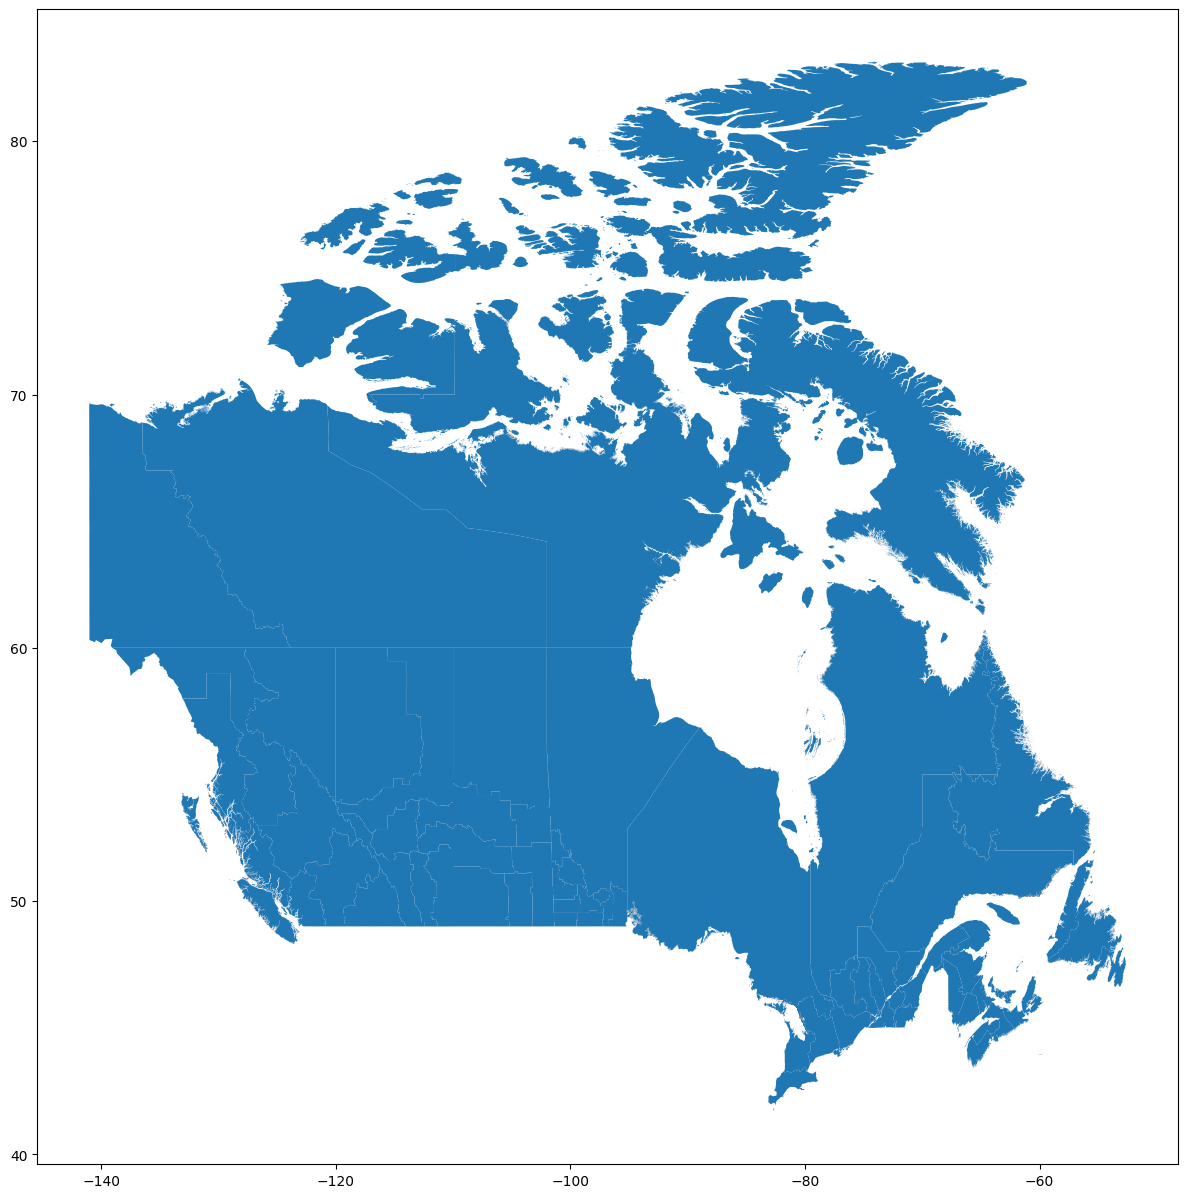

In [6]:
df_boundaries.plot()

On télécharge également les fichiers des [limites géographiques des divisions de recensement (CD)](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-fra.cfm?year=21) à partir du site de Statistique Canada.

In [7]:
df_boundaries_CD = geopandas.read_file(
    DATA_PATH / "boundaries" / "ldr_000b21a_f.shp"
).to_crs(
    CRS
).drop(
    ["DRIDU", "DRGENRE", "SUPTERRE"], 
    axis=1
).rename(
    columns={
        "DRNOM": "area_name", 
        "IDUGD": "DGUID", 
        "PRIDU": "PRUID"
    }
)

df_boundaries_CD["DGUID"] = df_boundaries_CD.apply(
    lambda row: row["DGUID"][4:], 
    axis=1
)

df_boundaries_CD

DGUID                                     area_name PRUID  \
0    A00031001                               Division No.  1    10   
1    A00031002                               Division No.  2    10   
2    A00031003                               Division No.  3    10   
3    A00031004                               Division No.  4    10   
4    A00031005                               Division No.  5    10   
5    A00031006                               Division No.  6    10   
6    A00031007                               Division No.  7    10   
7    A00031008                               Division No.  8    10   
8    A00031009                               Division No.  9    10   
9    A00031010                               Division No. 10    10   
10   A00031011                               Division No. 11    10   
11   A00031101                                         Kings    11   
12   A00031102                                        Queens    11   
13   A00031103                                        Prince    11   
14   A00031201                                     Shelburne    12   
15   A00031202                                      Yarmouth    12   
16   A00031203                                         Digby    12   
17   A00031204                                        Queens    12   
18   A00031205                                     Annapolis    12   
19   A00031206                                     Lunenburg    12   
20   A00031207                                         Kings    12   
21   A00031208                                         Hants    12   
22   A00031209                                       Halifax    12   
23   A00031210                                    Colchester    12   
24   A00031211                                    Cumberland    12   
25   A00031212                                        Pictou    12   
26   A00031213                                   Guysborough    12   
27   A00031214                                    Antigonish    12   
28   A00031215                                     Inverness    12   
29   A00031216                                      Richmond    12   
30   A00031217                                   Cape Breton    12   
31   A00031218                                      Victoria    12   
32   A00031301                                    Saint John    13   
33   A00031302                                     Charlotte    13   
34   A00031303                                       Sunbury    13   
35   A00031304                                        Queens    13   
36   A00031305                                         Kings    13   
37   A00031306                                        Albert    13   
38   A00031307                                   Westmorland    13   
39   A00031308                                          Kent    13   
40   A00031309                                Northumberland    13   
41   A00031310                                          York    13   
42   A00031311                                      Carleton    13   
43   A00031312                                      Victoria    13   
44   A00031313                                     Madawaska    13   
45   A00031314                                   Restigouche    13   
46   A00031315                                    Gloucester    13   
47   A00032401  Communauté maritime des Îles-de-la-Madeleine    24   
48   A00032402                               Le Rocher-Percé    24   
49   A00032403                              La Côte-de-Gaspé    24   
50   A00032404                             La Haute-Gaspésie    24   
51   A00032405                                   Bonaventure    24   
52   A00032406                                       Avignon    24   
53   A00032407                                  La Matapédia    24   
54   A00032408                                    La Matanie    24   
55   A00032409                                      La Mitis    24   
56   A00032410     

On visualise les limites géographiques des Divisions de Recensement.

<AxesSubplot: >

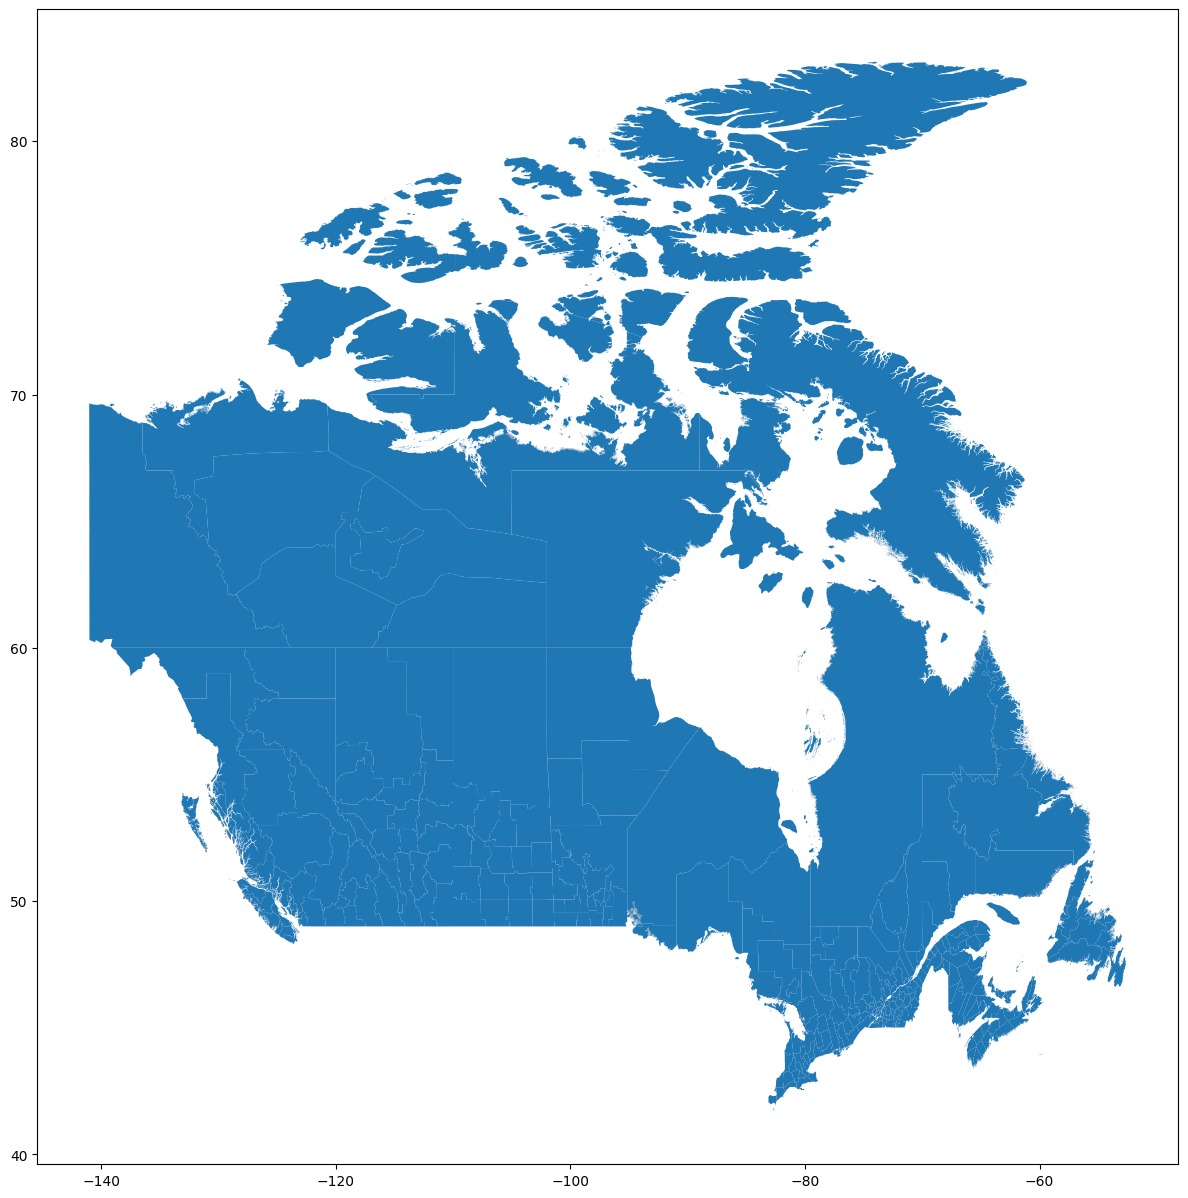

In [8]:
df_boundaries_CD.plot()

### 1.3. Projections de l'enveloppe climatique propice à l'érable à sucre 

On télécharge ensuite les fichiers de projections climatiques pour l'érable à sucre et l’érable rouge (selon le scénario SDM ANUCLIM et le RCP 8.5) pour les horizons 2011-2040, 2041-2070 et 2071-2100.

On considère une enveloppe "marginale" et une enveloppe "core", selon les définitions suivantes :
- "marginale" : enveloppe climatique pour une période définie calibrée selon le min/max des conditions climatiques observées durant la période de référence.
- "core" : Enveloppe climatique selon le 5e à 95e centile des conditions climatiques observées durant la période de référence 

_Source : https://protect-eu.mimecast.com/s/G3lTCVNkkFqzB6DHGqvem?domain=planthardiness.gc.ca ET McKENNEY, D. W., Pedlar, J. H., Rood, R. B., & Price, D. (2011). Revisiting projected shifts in the climate envelopes of North American trees using updated general circulation models. Global Change Biology, 17(8), 2720-2730._

#### 1.3.1. Projection 2011-2040

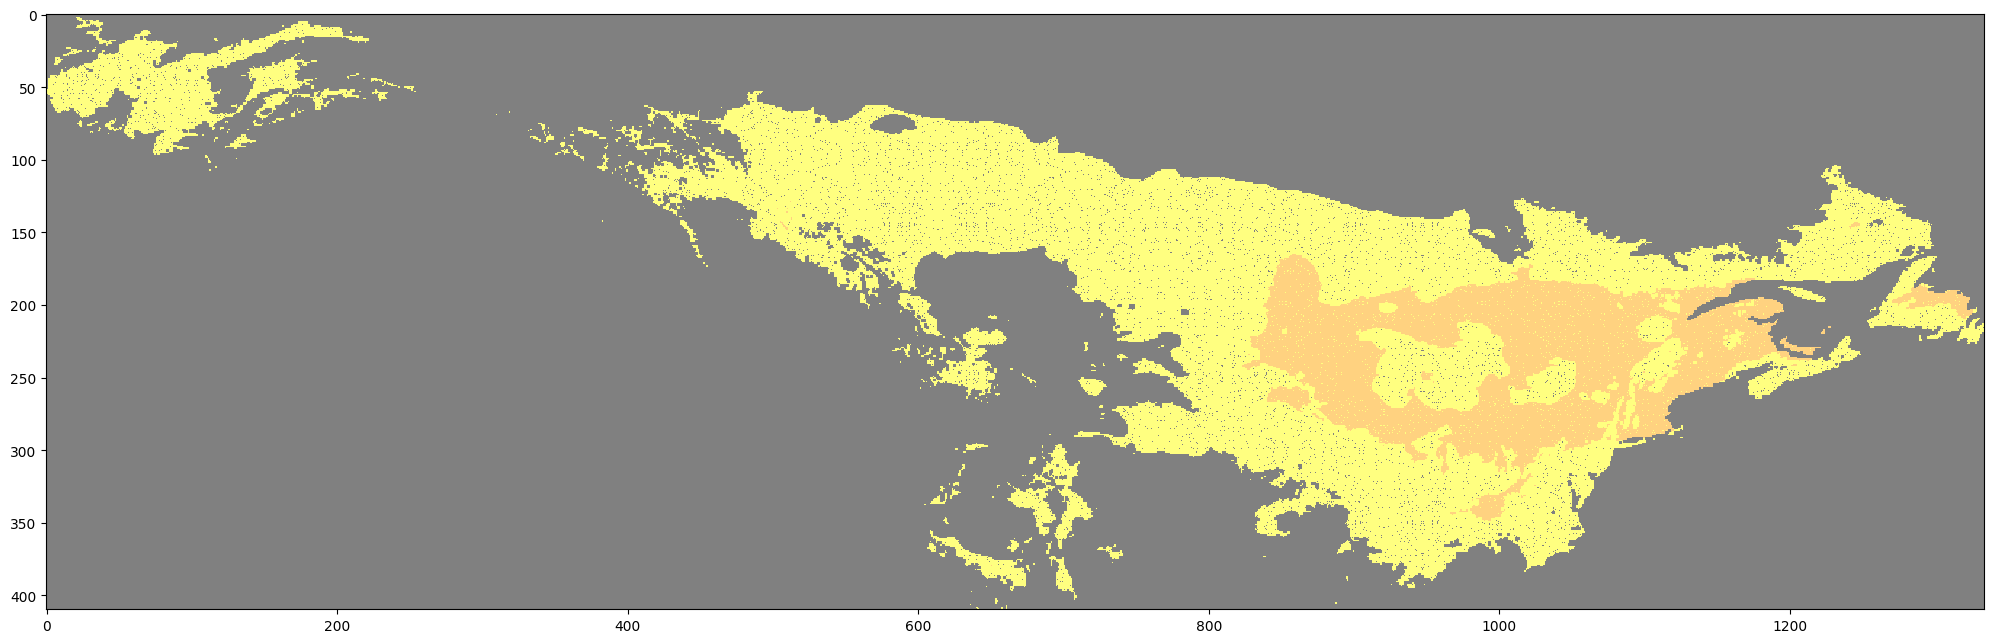

In [9]:
filename = DATA_PATH / "rasters" / "arcp8510000532011-2040.asc"

raster_2011_2040 = read_raster(filename, crs=CRS)
    
cmap = mpl.colors.ListedColormap(['black', 'yellow', 'orange'])
bounds = [raster_2011_2040.nodata, 1, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

raster_2011_2040_data = raster_2011_2040.read(1)
plt.imshow(raster_2011_2040_data, cmap=cmap, norm=norm, alpha=0.5)
plt.show()

Pour chacune des régions agricoles de recensement, on calcule le nombre de pixels pour chacune des catégories ("marginale", "core" et "autres").

In [10]:
period = "2011-2040"

for value, name in [
    (1, "marginal"), 
    (3, "core"), 
    (raster_2011_2040.nodata, "rest")
]:
    df_boundaries[f"{name}_{period}"] = zonal_stats_for_value(
        raster=raster_2011_2040, 
        vectors=df_boundaries["geometry"], 
        value=value, 
        data_value=100, 
        stats="count", 
        resolution=2.5
    )

#### 1.3.2. Projection 2041-2070

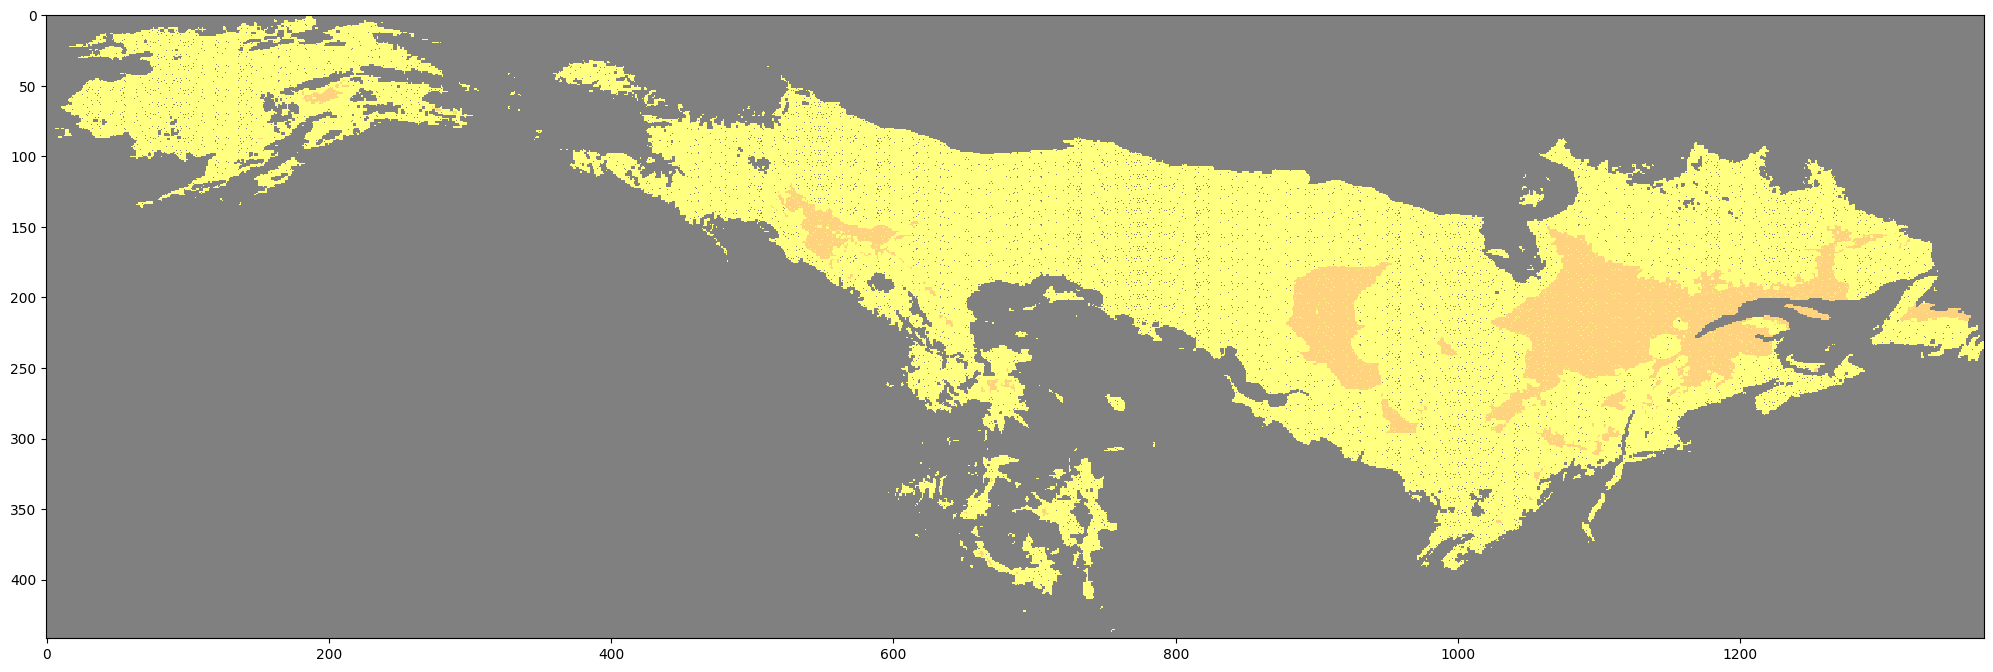

In [11]:
filename = DATA_PATH / "rasters" / "arcp8510000532041-2070.asc"

raster_2041_2070 = read_raster(filename, crs=CRS)

raster_2041_2070_data = raster_2041_2070.read(1)
plt.imshow(raster_2041_2070_data, cmap=cmap, norm=norm, alpha=0.5)
plt.show()

Pour chacune des régions agricoles de recensement, on calcule le nombre de pixels pour chacune des catégories ("marginale", "core" et "autres").

In [12]:
period = "2041-2070"

for value, name in [
    (1, "marginal"), 
    (3, "core"), 
    (raster_2041_2070.nodata, "rest")
]:
    df_boundaries[f"{name}_{period}"] = zonal_stats_for_value(
        raster=raster_2041_2070, 
        vectors=df_boundaries["geometry"], 
        value=value, 
        data_value=100, 
        stats="count", 
        resolution=2.5
    )

#### 1.3.3. Projection 2071-2100

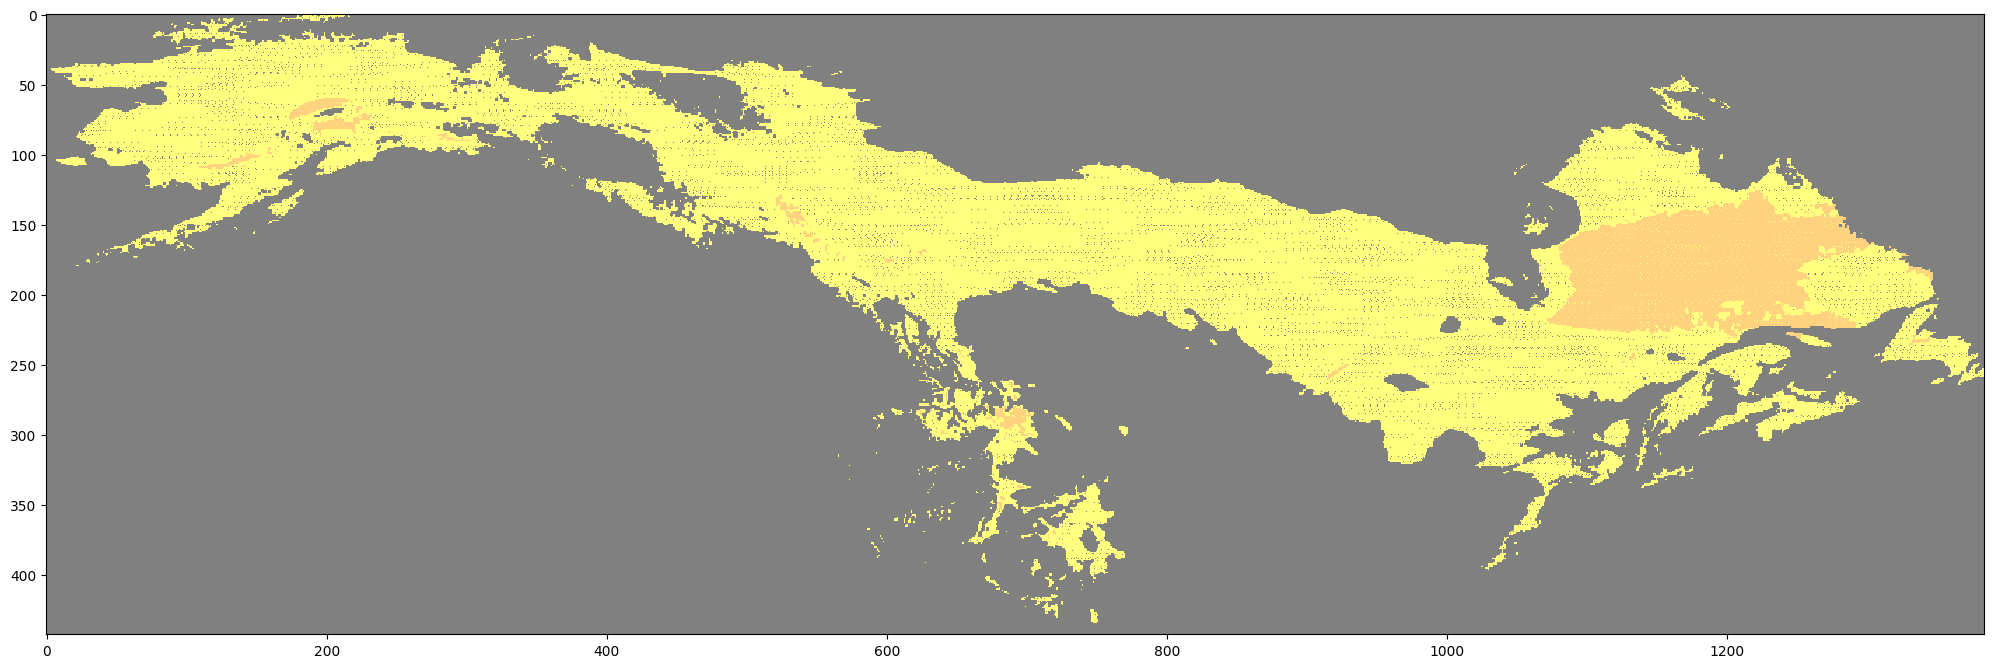

In [13]:
filename = DATA_PATH / "rasters" / "arcp8510000532071-2100.asc"
raster_2071_2100 = read_raster(filename, crs=CRS)

raster_2071_2100_data = raster_2071_2100.read(1)
plt.imshow(raster_2071_2100_data, cmap=cmap, norm=norm, alpha=0.5)
plt.show()

Pour chacune des régions agricoles de recensement, on calcule le nombre de pixels pour chacune des catégories ("marginale", "core" et "autres").

In [14]:
period = "2071-2100"

for value, name in [
    (1, "marginal"), 
    (3, "core"), 
    (raster_2071_2100.nodata, "rest")
]:
    df_boundaries[f"{name}_{period}"] = zonal_stats_for_value(
        raster=raster_2071_2100, 
        vectors=df_boundaries["geometry"], 
        value=value, 
        data_value=100, 
        stats="count", 
        resolution=2.5
    )

### 1.4. Intersection des projections

Pour chacune des régions, on observe la proportion qui demeure intacte d'une période à une autre.

In [15]:
rasters, transform = register_rasters(
    raster_2011_2040, 
    raster_2041_2070, 
    raster_2071_2100
)

registered_raster_2011_2040, registered_raster_2041_2070, registered_raster_2071_2100 = rasters

In [16]:
stats, marginal_2011_and_2041_raster = zonal_stats_intersection(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    affine=transform, 
    data_values=[1, 3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"marginal_2011_and_2041"] = stats

stats, core_2011_and_2041_raster = zonal_stats_intersection(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    affine=transform, 
    data_values=[3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"core_2011_and_2041"] = stats
    
stats, marginal_2011_and_2071_raster = zonal_stats_intersection(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    affine=transform, 
    data_values=[1, 3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"marginal_2011_and_2071"] = stats

stats, core_2011_and_2071_raster = zonal_stats_intersection(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    affine=transform, 
    data_values=[3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"core_2011_and_2071"] = stats

In [17]:
stats, marginal_2011_and_2041_raster = zonal_stats_intersection_gain(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    affine=transform, 
    data_values=[1, 3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"gain_marginal_2041"] = stats

stats, core_2011_and_2041_raster = zonal_stats_intersection_gain(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    affine=transform, 
    data_values=[3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"gain_core_2041"] = stats
    
stats, marginal_2011_and_2071_raster = zonal_stats_intersection_gain(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    affine=transform, 
    data_values=[1, 3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"gain_marginal_2071"] = stats

stats, core_2011_and_2071_raster = zonal_stats_intersection_gain(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    affine=transform, 
    data_values=[3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"gain_core_2071"] = stats

### 1.4. Limites de la forêt boréale

On télécharge ensuite le fichier des limites des [zones de végétation du Canada](https://open.canada.ca/data/fr/dataset/22b0166b-9db3-46b7-9baf-6584a3acc7b1). 

<AxesSubplot: >

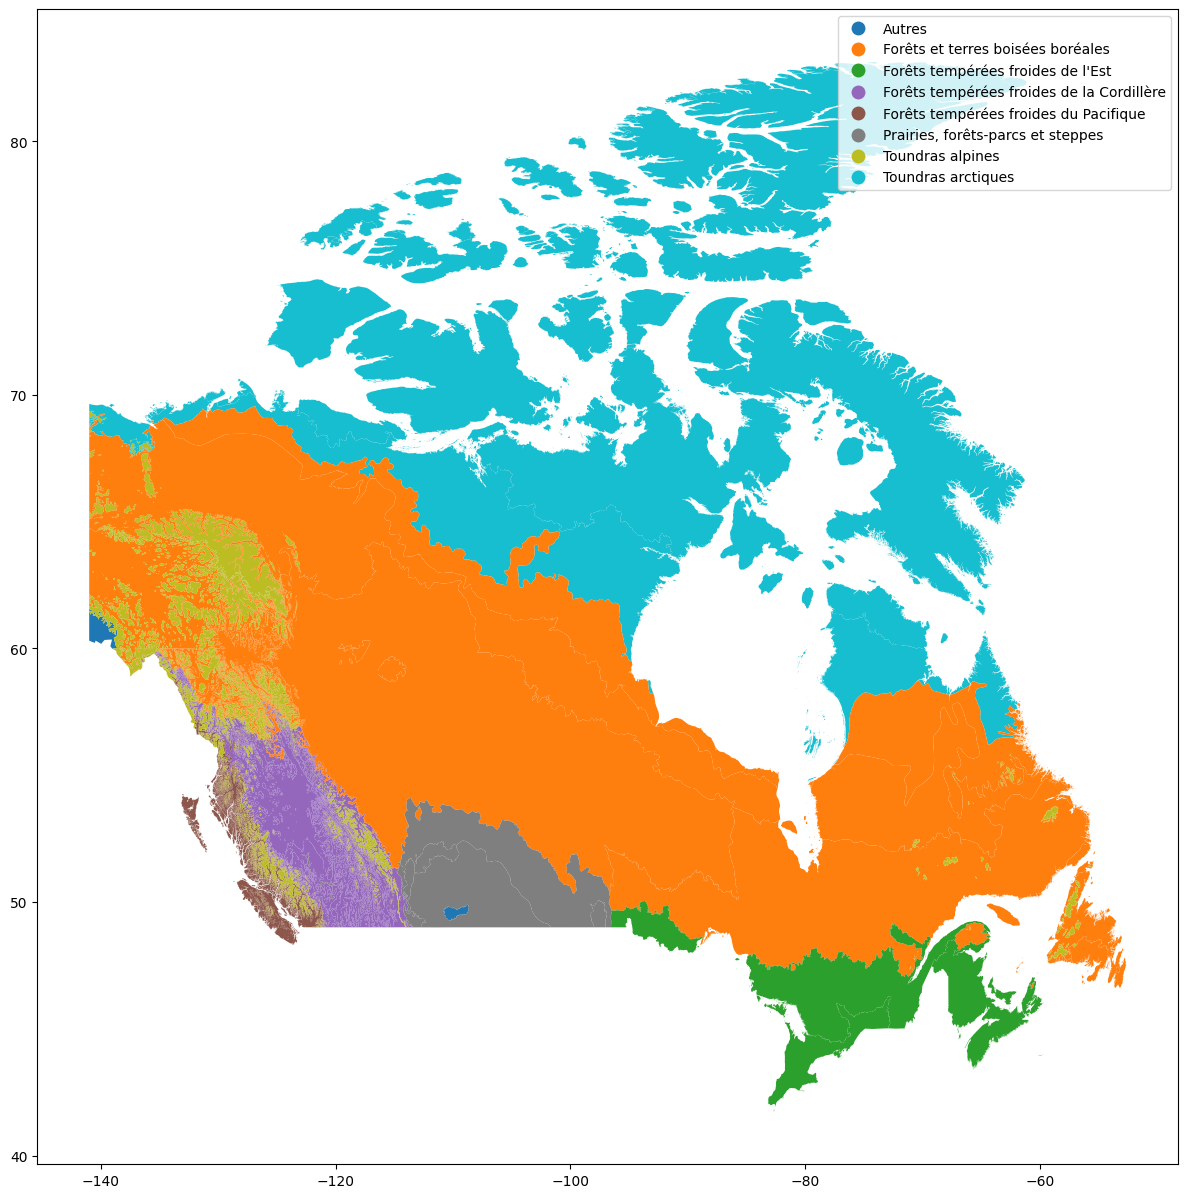

In [79]:
vegetation_zones_df = geopandas.read_file(
    DATA_PATH / "vegetation" / "vegetation_zones_of_canada_2020.shp"
).to_crs(
    CRS
)

vegetation_zones_df.plot(column='niveau_1', legend=True)

### 1.5. Aires colonisées par l'érable à sucre

On télécharge également les fichiers des [aires colonisées par l'érable à scure](https://doi.org/10.1111/ddi.13630).

In [ ]:
colonized_areas_raster = read_raster(DATA_PATH / "colonized" / "ACESAC_250_iniDist.tiff", crs=CRS)

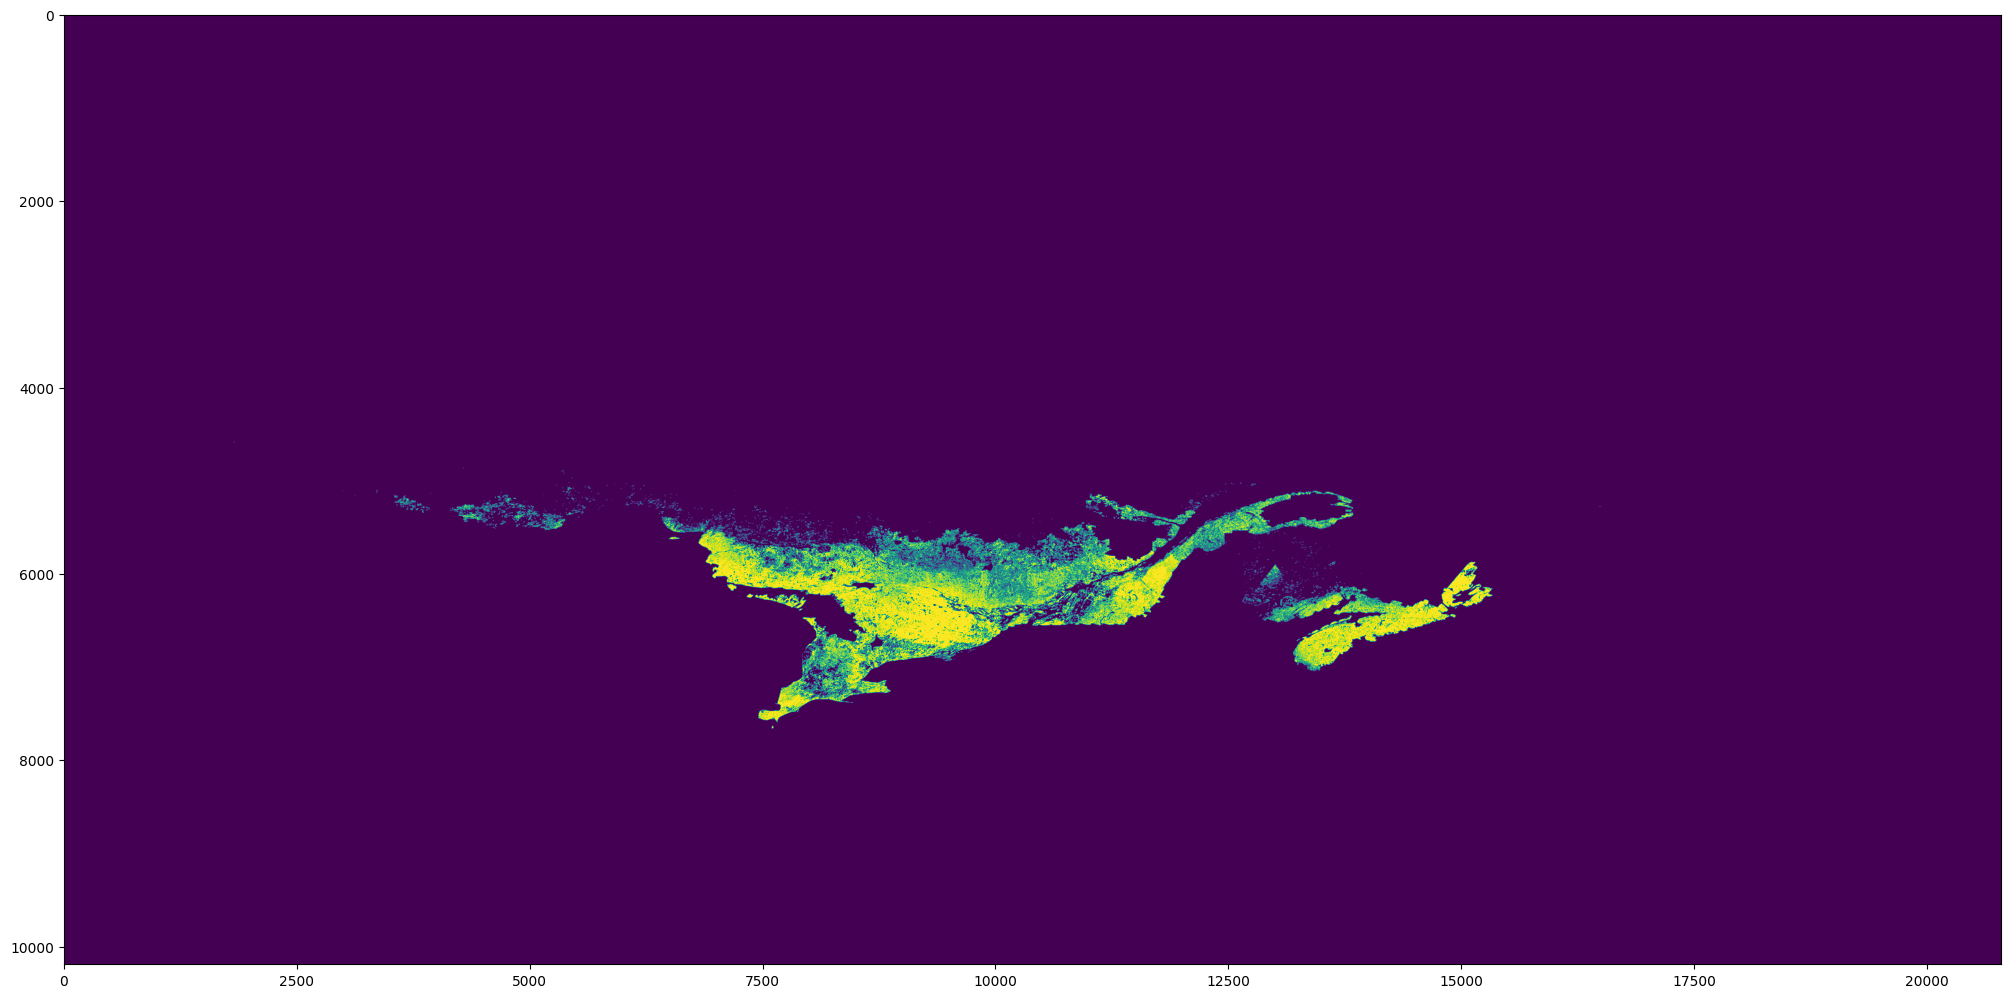

In [105]:
colonized_areas_raster_data = colonized_areas_raster.read(1)
colonized_areas_raster_data[np.where(colonized_areas_raster_data != 1)] = 0
plt.imshow(colonized_areas_raster_data)
plt.show()

# 2. Création de la table de données de travail

On joint les données téléchargées dans un dataframe comprenant toutes les informations requises pour répondre aux questions de recherche. On calcule quelques statistiques préalables et on nettoie la table de données finale.

In [18]:
df = pd.merge(
    df_boundaries, 
    df_farms, 
    on="DGUID"
)

pr_df = pd.DataFrame({
    "PRUID": ["10", "11", "12", "13", "24", "35", "46", "47", "48", "59", "60", "61", "62"], 
    "province": [
        "Terre-Neuve-et-Labrador", 
        "Île-du-Prince-Édouard", 
        "Nouvelle-Écosse",
        "Nouveau-Brunswick",
        "Québec",
        "Ontario",
        "Manitoba",
        "Saskatchewan",
        "Alberta",
        "Colombie-Britannique",
        "Yukon",
        "Territoires du Nord-Ouest",
        "Nunavut"
    ]
}
)

df = df.merge(
    pr_df, 
    on="PRUID"
).drop("PRUID", axis=1)

df["rank_entailles"] = df["2021_num_entailles"].rank(method="min", na_option="bottom", ascending=False)
df["rank_exploitations"] = df["2021_num_exploitations"].rank(method="min", na_option="bottom", ascending=False)

df = df.rename({
    "all_2011-2040": "rest_2011-2040", 
    "all_2041-2070": "rest_2041-2070", 
    "all_2071-2100": "rest_2071-2100", 
}, axis=1)

df

DGUID                              area_name  \
0   S05011001       Région agricole de recensement 1   
1   S05011002       Région agricole de recensement 2   
2   S05011003       Région agricole de recensement 3   
3   S05011101       Région agricole de recensement 1   
4   S05011102       Région agricole de recensement 2   
5   S05011103       Région agricole de recensement 3   
6   S05011201       Région agricole de recensement 1   
7   S05011202       Région agricole de recensement 2   
8   S05011203       Région agricole de recensement 3   
9   S05011204       Région agricole de recensement 4   
10  S05011205       Région agricole de recensement 5   
11  S05011301       Région agricole de recensement 1   
12  S05011302       Région agricole de recensement 2   
13  S05011303       Région agricole de recensement 3   
14  S05011304       Région agricole de recensement 4   
15  S05012401                      Bas-Saint-Laurent   
16  S05012402    Saguenay--Lac-Saint-Jean--Côte-Nord   
17  S05012403                                 Québec   
18  S05012404                               Mauricie   
19  S05012405                                 Estrie   
20  S05012406                        Montréal--Laval   
21  S05012407                             Lanaudière   
22  S05012408                              Outaouais   
23  S05012409                            Laurentides   
24  S05012410  Abitibi-Témiscamingue--Nord-du-Québec   
25  S05012411         Gaspésie--Îles-de-la-Madeleine   
26  S05012412                   Chaudière-Appalaches   
27  S05012413                             Montérégie   
28  S05012414                       Centre-du-Québec   
29  S05013501             Région du Sud de l'Ontario   
30  S05013502         Région de l'Ouest de l'Ontario   
31  S05013503          Région du Centre de l'Ontario   
32  S05013504           Région de l'Est de l'Ontario   
33  S05013505            Région du Nord de l'Ontario   
34  S05014601       Région agricole de recensement 1   
35  S05014602       Région agricole de recensement 2   
36  S05014603       Région agricole de recensement 3   
37  S05014604       Région agricole de recensement 4   
38  S05014605       Région agricole de recensement 5   
39  S05014606       Région agricole de recensement 6   
40  S05014607       Région agricole de recensement 7   
41  S05014608       Région agricole de recensement 8   
42  S05014609       Région agricole de recensement 9   
43  S05014610      Région agricole de recensement 10   
44  S05014611      Région agricole de recensement 11   
45  S05014612      Région agricole de recensement 12   
46  S05014701       Région agricole de recensement 1   
47  S05014702       Région agricole de recensement 2   
48  S05014703       Région agricole de recensement 3   
49  S05014704       Région agricole de recensement 4   
50  S05014705       Région agricole de recensement 5   
51  S05014706       Région agricole de recensement 6   
52  S05014707       Région agricole de recensement 7   
53  S05014810       Région agricole de recensement 1   
54  S05014820       Région agricole de recensement 2   
55  S05014830       Région agricole de recensement 3   
56  S05014840      Région agricole de recensement 4A   
57  S05014841      Région agricole de recensement 4B   
58  S05014850       Région agricole de recensement 5   
59  S05014860       Région agricole de recensement 6   
60  S05014870       Région agricole de recensement 7   
61  S05015901                 Vancouver Island-Coast   
62  S05015902               Lower Mainland-Southwest   
63  S05015903                      Thompson-Okanagan   
64  S05015904                               Kootenay   
65  S05015905                                Cariboo   
66  S05015906                            North Coast   
67  S05015907                                Nechako   
68  S05015908                            Peace River   

                                             geometry     total_area  \
0   MULTIPOLYGO

On crée également une table de données avec différents niveaux de délimitation des régions (CD ou RAR) selon la province. Ces données ne seront utilisées que pour la visualisation.

In [19]:
df_CD_and_RAR = geopandas.GeoDataFrame(
    pd.concat([
        pd.merge(
            df_farms_CD,
            df_boundaries_CD,  
            on="DGUID", 
            how="left"
        ),  
        pd.merge(
            df_farms_RAR,
            df_boundaries,  
            on="DGUID", 
            how="left"
        )
    ])
)

df_CD_and_RAR

DGUID  2021_num_exploitations  2021_num_entailles level  \
0   A00031306                     8.0                 NaN    CD   
1   A00033557                    53.0            133083.0    CD   
2   A00033529                    19.0                 NaN    CD   
3   A00033541                    83.0             73331.0    CD   
4   A00031311                    24.0            472400.0    CD   
5   A00031302                     3.0                 NaN    CD   
6   A00033536                    18.0             13477.0    CD   
7   A00033556                     2.0                 NaN    CD   
8   A00033522                    30.0                 NaN    CD   
9   A00033518                    60.0             60236.0    CD   
10  A00033534                    33.0             16486.0    CD   
11  A00033537                    15.0                 NaN    CD   
12  A00033510                    45.0             22101.0    CD   
13  A00031315                    13.0                 NaN    CD   
14  A00033553                     4.0                 NaN    CD   
15  A00033542                   198.0            210348.0    CD   
16  A00033528                    50.0             17582.0    CD   
17  A00033546                    14.0             14967.0    CD   
18  A00033524                    27.0              6496.0    CD   
19  A00033525                    18.0                 NaN    CD   
20  A00033512                    65.0             48321.0    CD   
21  A00033540                    95.0            121397.0    CD   
22  A00033516                    66.0             35042.0    CD   
23  A00033560                     0.0                 0.0    CD   
24  A00031308                     2.0                 NaN    CD   
25  A00031305                    16.0                 NaN    CD   
26  A00033538                    39.0             13199.0    CD   
27  A00033509                    89.0            208832.0    CD   
28  A00033507                    77.0             38179.0    CD   
29  A00033511                    42.0                 NaN    CD   
30  A00031313                    29.0            635532.0    CD   
31  A00033551                    23.0                 NaN    CD   
32  A00033539                    53.0             39170.0    CD   
33  A00033544                    20.0                 NaN    CD   
34  A00033526                    14.0                 NaN    CD   
35  A00033548                    14.0             13108.0    CD   
36  A00031309                     0.0                 0.0    CD   
37  A00033514                    46.0                 NaN    CD   
38  A00033506                    67.0                 NaN    CD   
39  A00033532                    69.0             41505.0    CD   
40  A00033549                    37.0             70022.0    CD   
41  A00033521                    15.0                 NaN    CD   
42  A00033531                    76.0             38554.0    CD   
43  A00033515                    67.0             27968.0    CD   
44  A00033502                    55.0             45243.0    CD   
45  A00033513                    24.0                 NaN    CD   
46  A00031304                     5.0                 NaN    CD   
47  A00033559                     3.0                 NaN    CD   
48  A00033547                    81.0             33426.0    CD   
49  A00031314                    54.0           2102766.0    CD   
50  A00031301                     0.0                 0.0    CD   
51  A00033543                   111.0             57191.0    CD   
52  A00033501                    87.0             57897.0    CD   
53  A00033552                     9.0                 NaN    CD   
54  A00031303                     2.0                 NaN    CD   
55  A00033558                     1.0                 NaN    CD   
56  A00033554                     6.0                 NaN    CD   
57  A00033520                     2.0                 NaN    CD   
58  A00031312                     7.0            127212

# 3. Visualisation des données 

## 3.1. Projection des niches climatiques

On visualise la distribution des entailles en 2021 par rapport à la carte des niches climatiques.

La niche climatique marginale est en jaune et la niche climatique core, en orange. Les cercles bleus pointent vers le centroïde de chacune des régions agricoles de recensement et la taille du cercle est proportionnelle au nombre d'entailles en 2021.

### 3.1.1. Projection 2011-2040

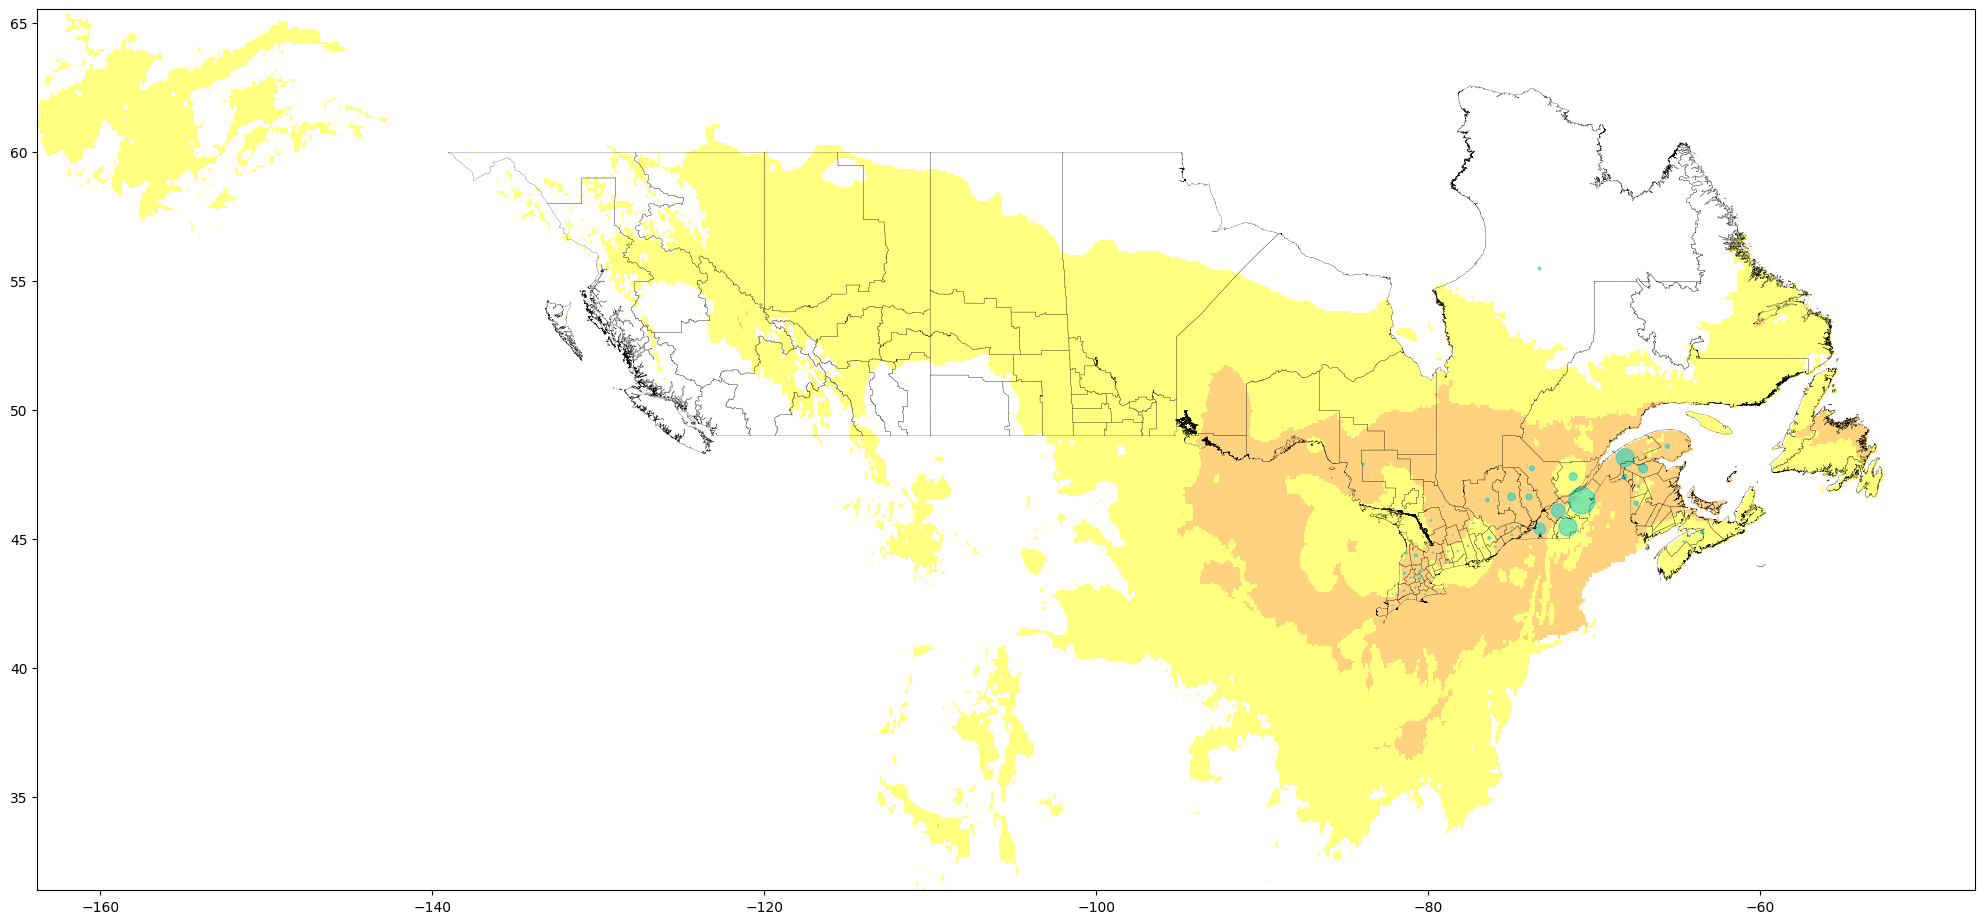

In [20]:
def _plot(df, raster, markersize_factor=50000, extent=None):
    fig, ax = plt.subplots()

    ax = show(
        raster, 
        extent=[
            raster.bounds[0], 
            raster.bounds[2], 
            raster.bounds[1], 
            raster.bounds[3]
        ], 
        alpha=0.5,
        cmap=cmap, 
        norm=norm,
        with_bounds=True, 
        ax=ax
    )

    df.boundary.plot(ax=ax, lw=0.15, color="black")
    df.centroid.plot(
        markersize=df['2021_num_entailles'] / markersize_factor, 
        alpha=0.5,
        color="DarkTurquoise", 
        ax=ax
    )
    
_plot(df_CD_and_RAR, raster_2011_2040)

### 3.1.2. Projection 2041-2070

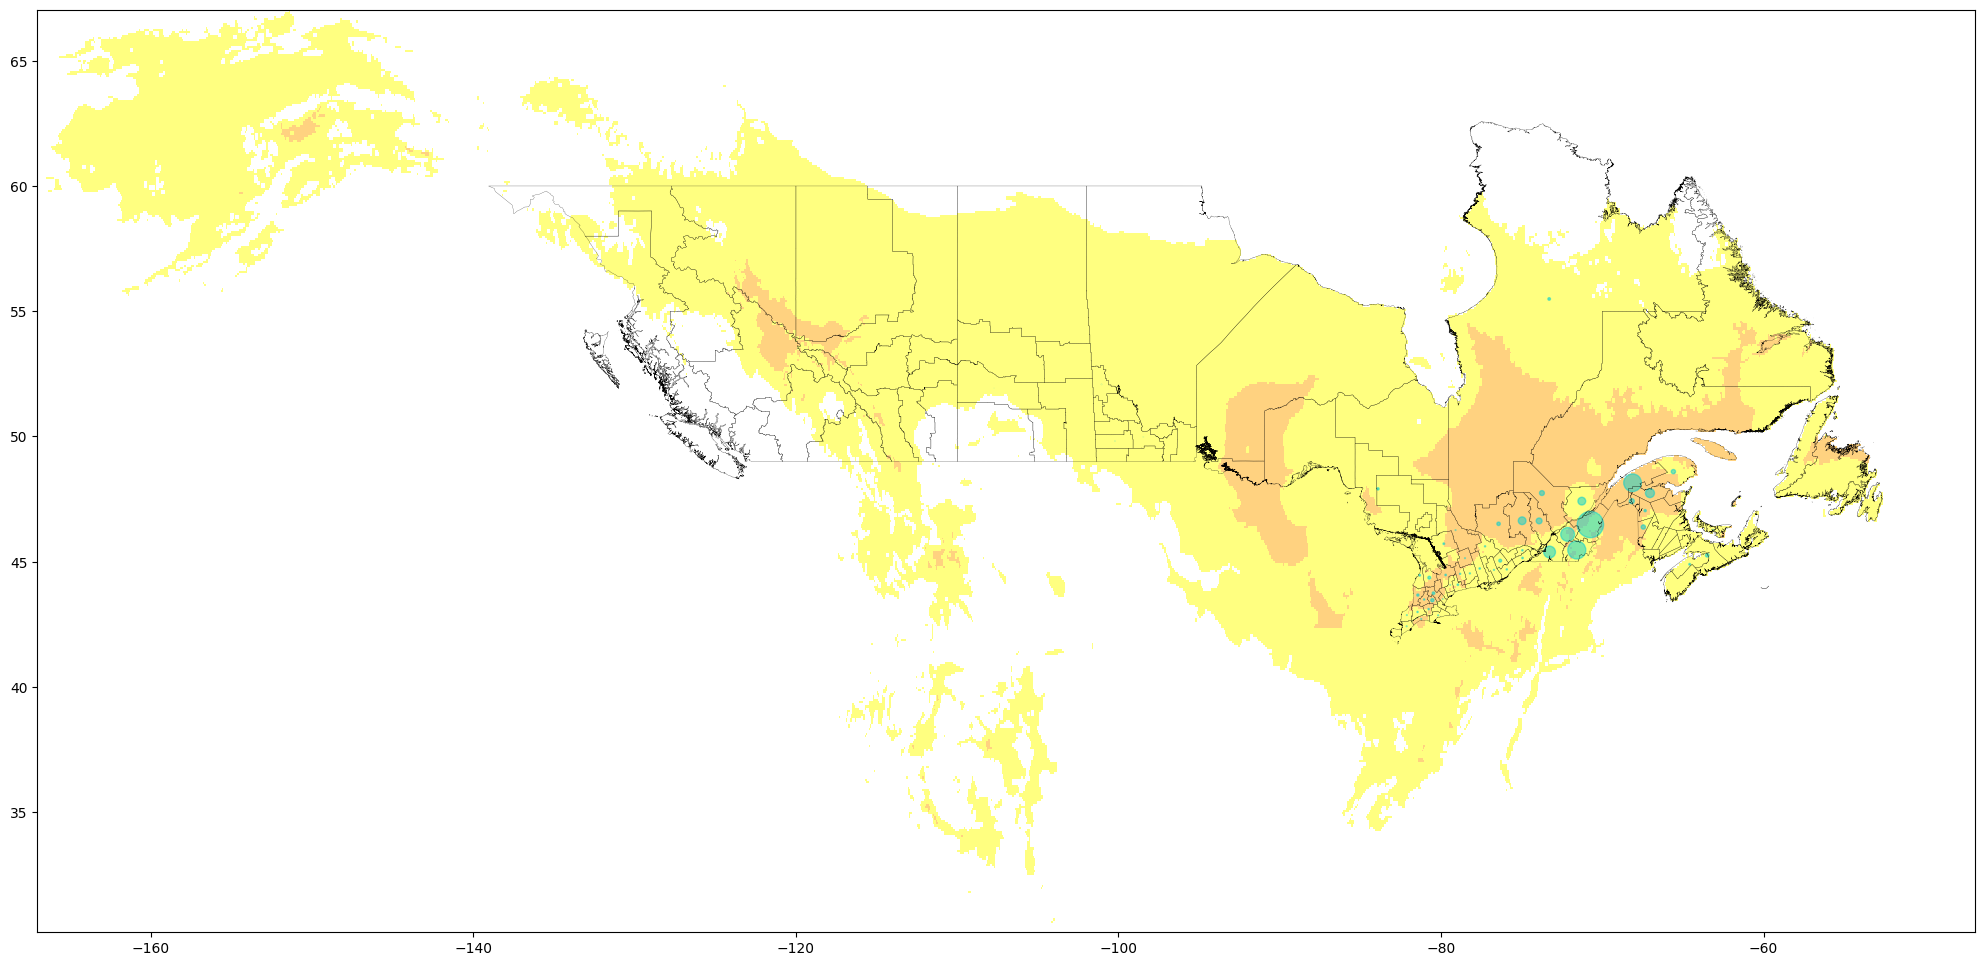

In [21]:
_plot(df_CD_and_RAR, raster_2041_2070)

### 3.1.3. Projection 2071-2100

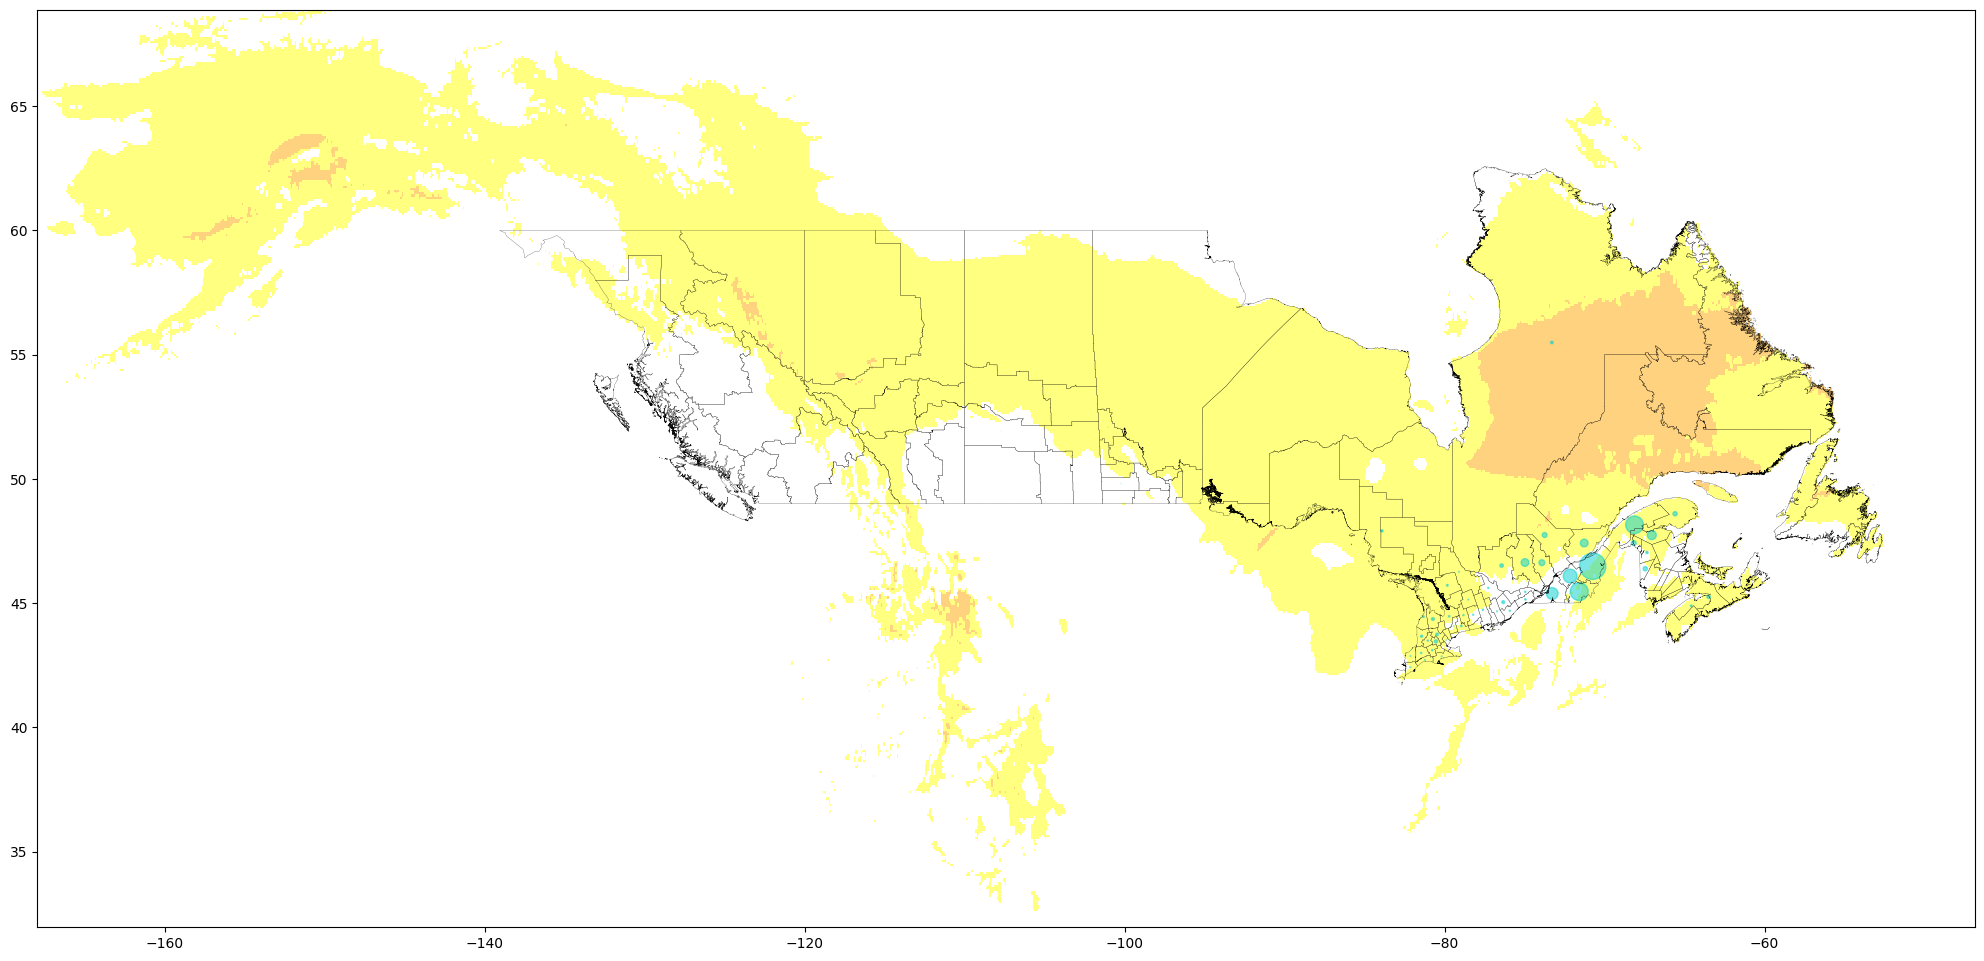

In [22]:
_plot(df_CD_and_RAR, raster_2071_2100)

On zoom ici sur l'Est du pays, où se concentre la production acéricole.

### 3.1.4. Projection 2011-2040

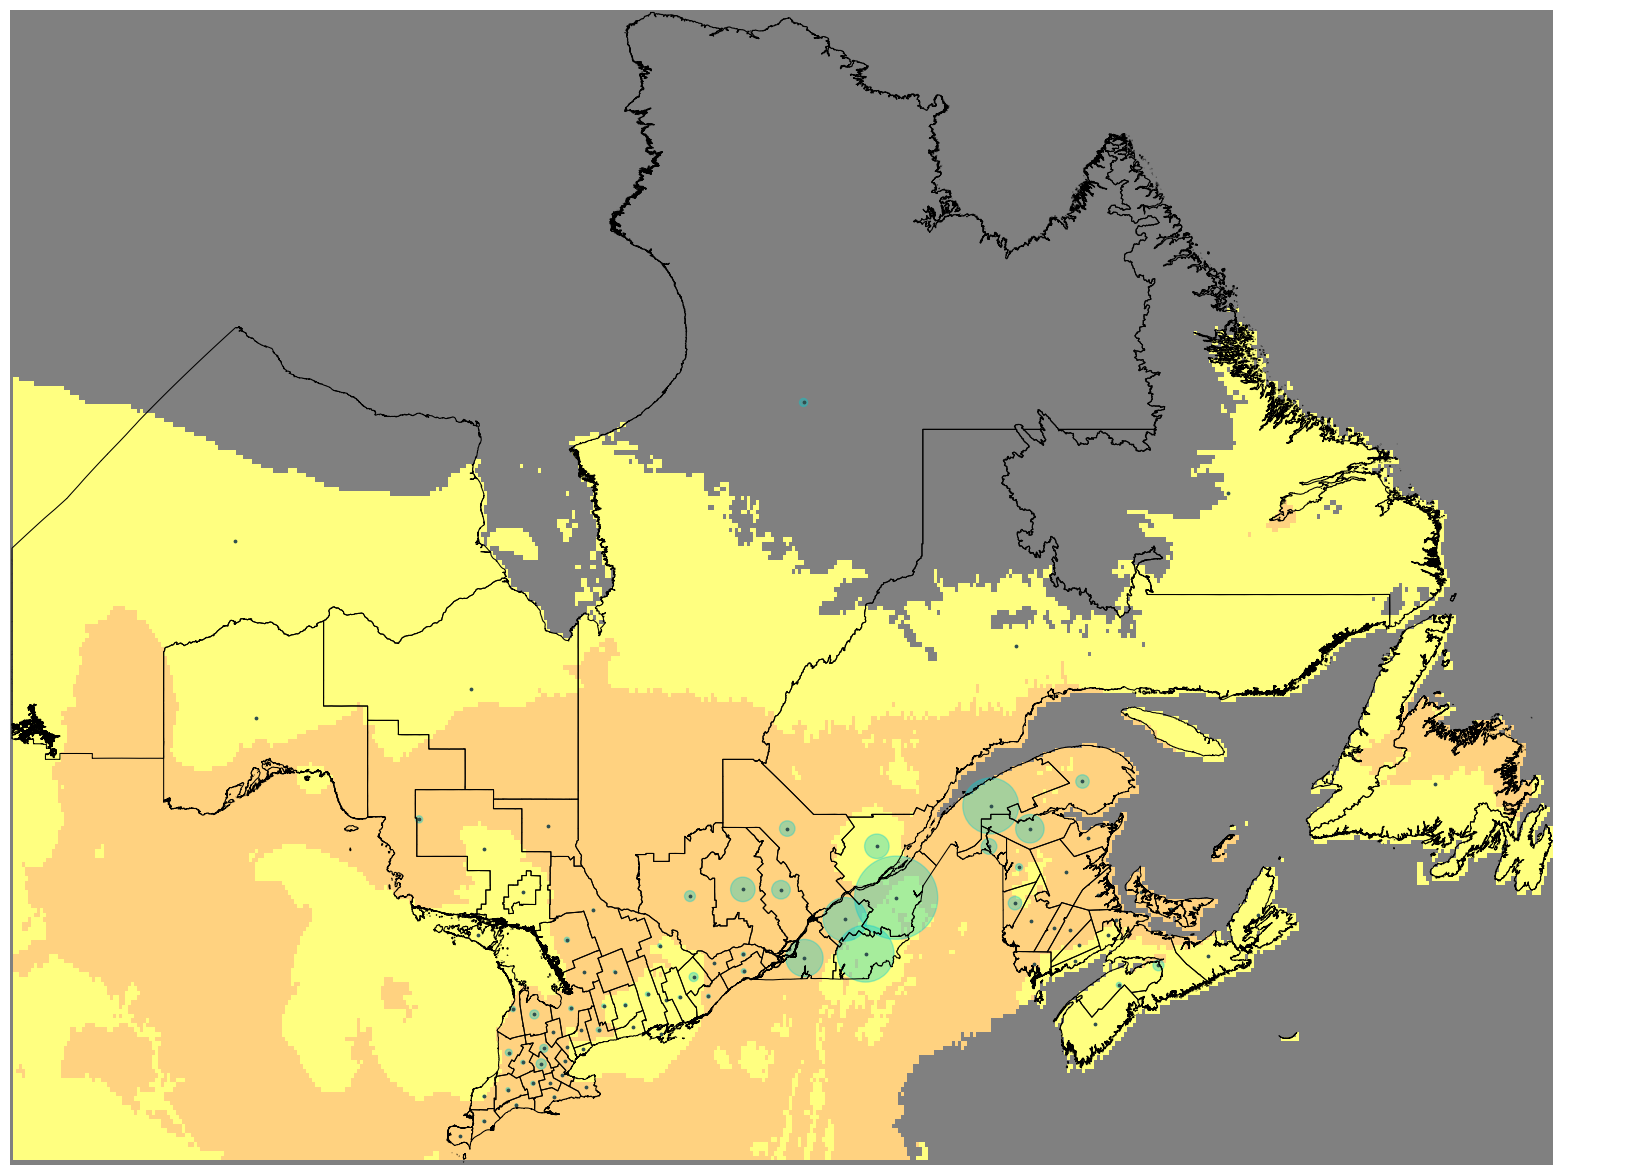

In [23]:
def _plot_zoom(df, raster, markersize_factor=5000):
    xmin = -90
    xmax = -40
    ymin = 42
    ymax = 55
    
    crop_df = df.cx[xmin: xmax, ymin: ymax]
    
    xmin = min(crop_df.bounds["minx"])
    ymin = min(crop_df.bounds["miny"])
    xmax = max(crop_df.bounds["maxx"])
    ymax = max(crop_df.bounds["maxy"])
    
    fig, ax = plt.subplots()
    
    out_image, out_transform = mask(
        raster, 
        [Polygon(((xmin, ymin), (xmax, ymin) ,(xmax, ymax), (xmin, ymax),  (xmin, ymin)))], 
        crop=True
    )

    ax = show(
        out_image, 
        transform=out_transform, 
        alpha=0.5,
        cmap=cmap, 
        norm=norm,
        with_bounds=True, 
        ax=ax
    )

    crop_df.boundary.plot(ax=ax, lw=0.75, color="black")
    
    centroids = crop_df.centroid
    centroids.plot(
        markersize=crop_df['2021_num_entailles'] / markersize_factor, 
        alpha=0.35,
        color="DarkTurquoise", 
        ax=ax, 
    )
    centroids.plot(
        markersize=3,
        alpha=1,
        color="DarkSlateGrey", 
        ax=ax, 
    )

    ax.set_axis_off()
    
_plot_zoom(df_CD_and_RAR, raster_2011_2040)

### 3.1.5. Projection 2041-2070

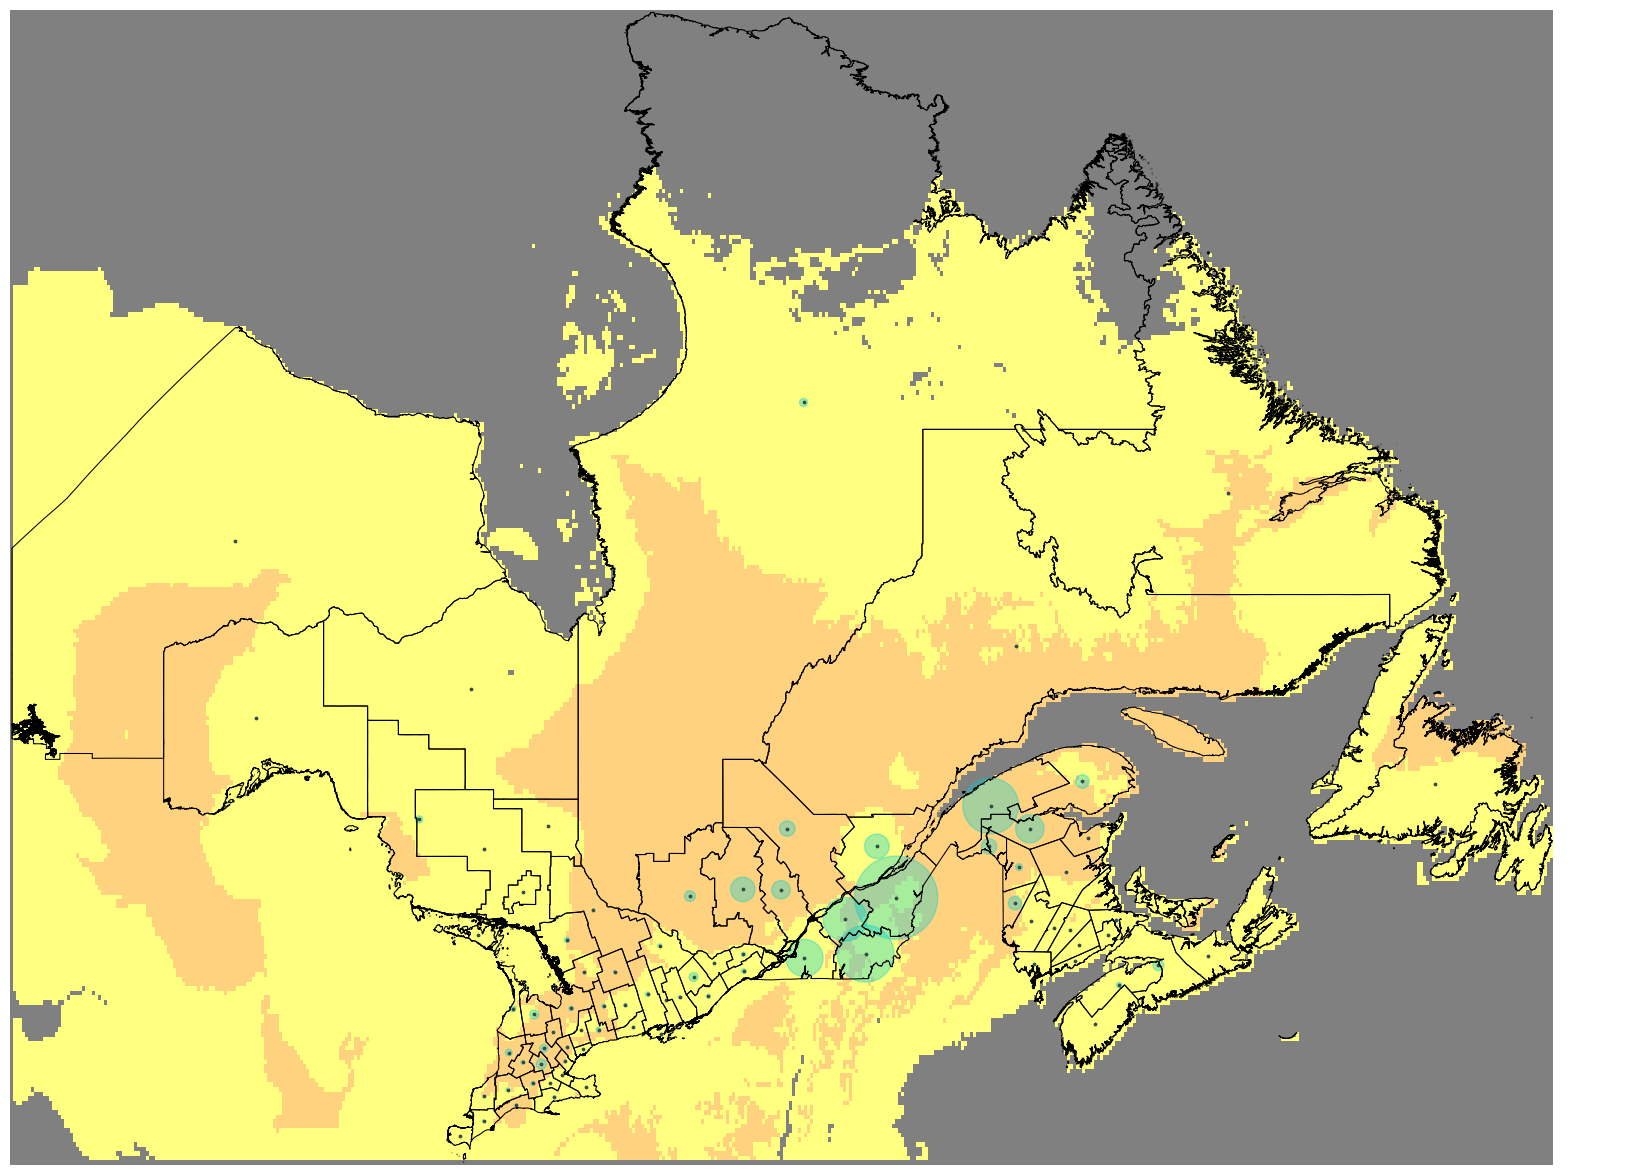

In [24]:
_plot_zoom(df_CD_and_RAR, raster_2041_2070)

### 3.1.6. Projection 2071-2100

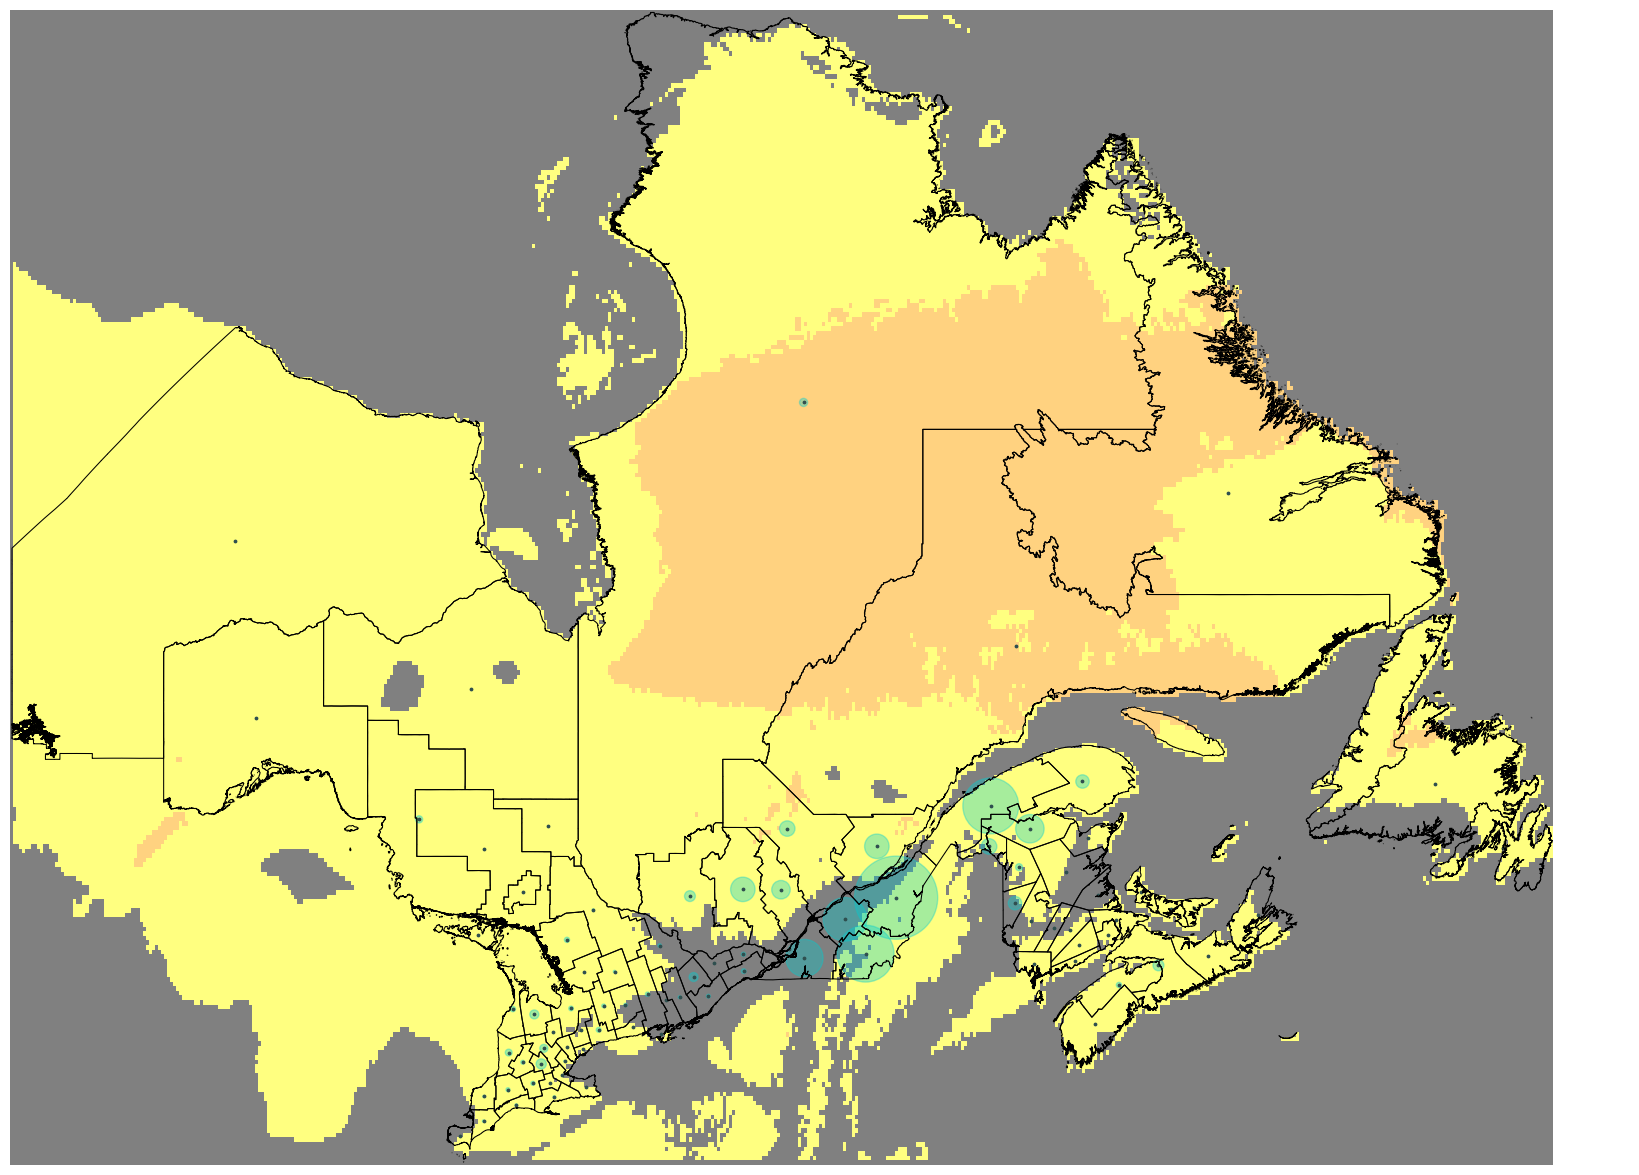

In [25]:
_plot_zoom(df_CD_and_RAR, raster_2071_2100)

## 3.2. Déplacement des niches climatiques

On visualise maintenant les régions qui gagnent ou perdent les conditions favorables au développement de l'érable à sucre. 

### 3.2.1. Pertes de conditions favorables 

On observe en rouge les régions qui faisaient partie de la niche climatique dans la période de projection initiale (2011-2040), mais qui n'en font plus partie dans la période de projection finale.

#### Conditions cores seulement : 2011-2040 à 2041-2070

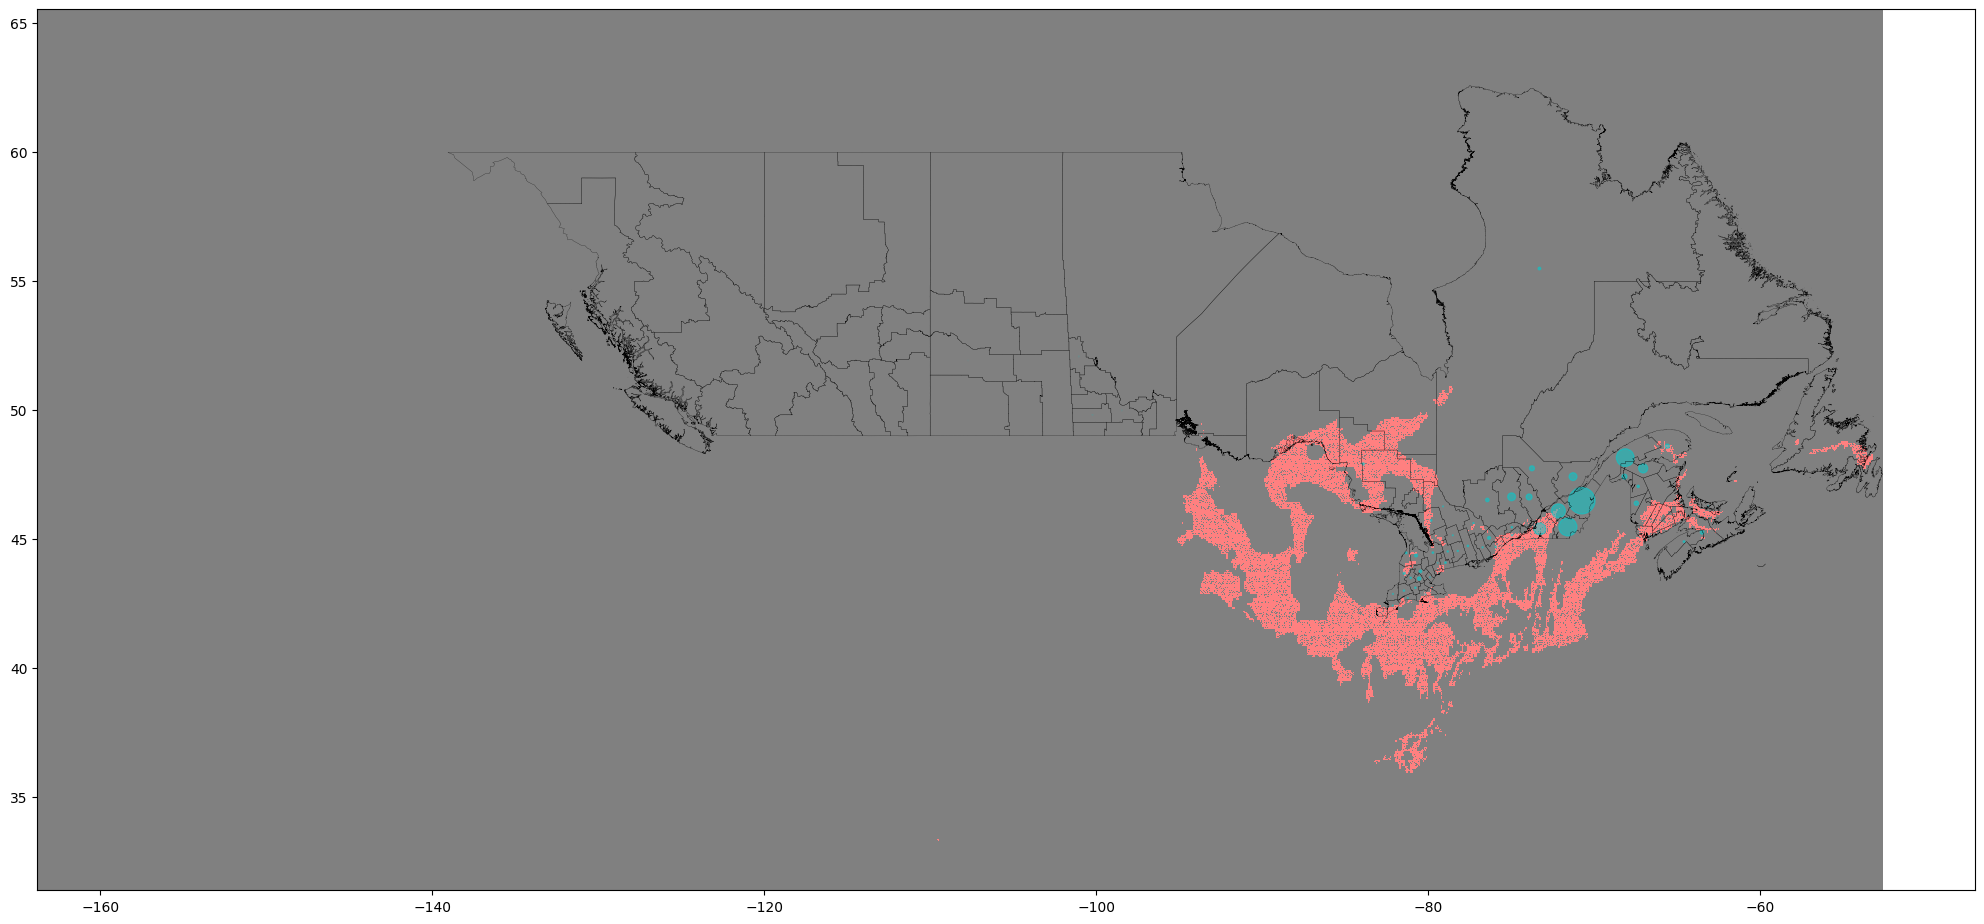

In [26]:
def _plot_lost_terrain(df, raster1, raster2, extent, data_value, color, nodata_value=-999, markersize_factor=50000):
    new_raster = np.ones(raster1.shape) * nodata_value
    new_raster[np.where((raster1 >= data_value) & (raster2 < data_value))] = 1
    
    fig, ax = plt.subplots()

    cmap = mpl.colors.ListedColormap(['black', color])
    bounds = [nodata_value, 1, 3]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    
    ax = show(
        new_raster,
        extent=extent,
        alpha=0.5,
        cmap=cmap, 
        norm=norm,
        with_bounds=True, 
        ax=ax
    )

    df.boundary.plot(ax=ax, lw=0.15, color="black")
    df.centroid.plot(
        markersize=df['2021_num_entailles'] / markersize_factor, 
        alpha=0.5,
        color="DarkTurquoise", 
        ax=ax
    )

_plot_lost_terrain(
    df_CD_and_RAR,
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=3, 
    color="red"
)

#### Conditions cores seulement : 2011-2040 à 2071-2100

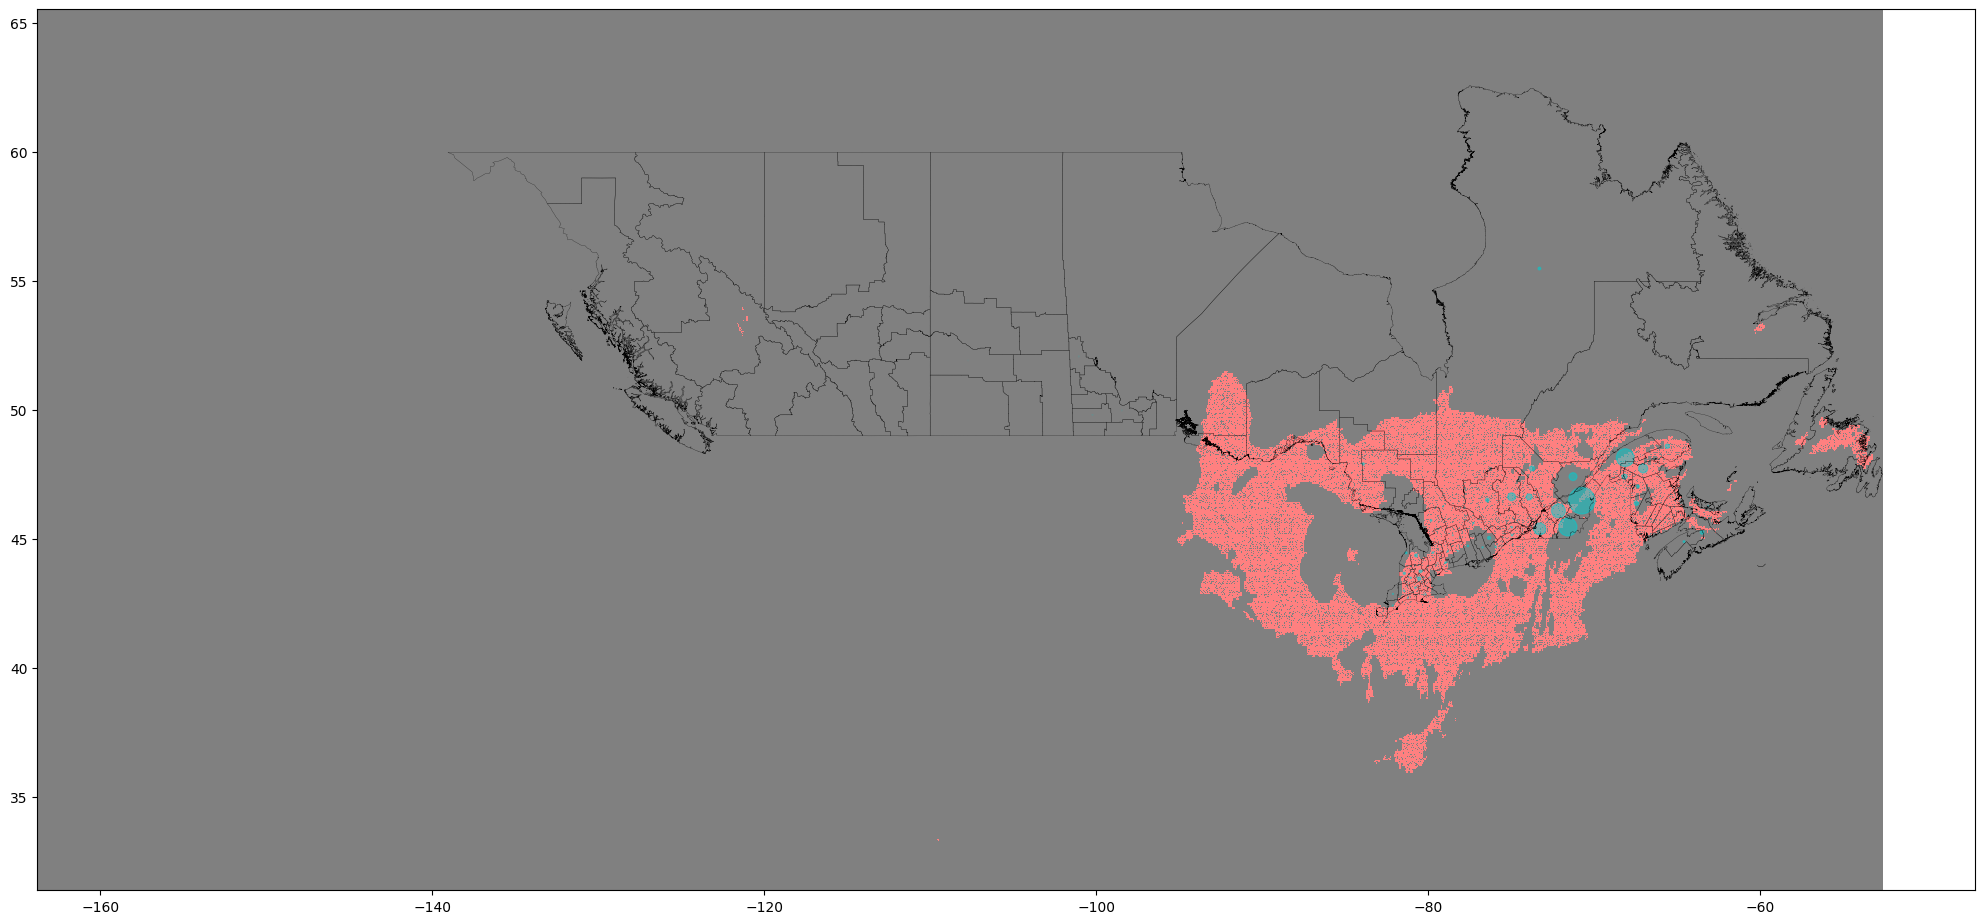

In [27]:
_plot_lost_terrain(
    df_CD_and_RAR, 
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=3, 
    color="red"
)

#### Conditions cores et marginales : 2011-2040 vs 2041-2070

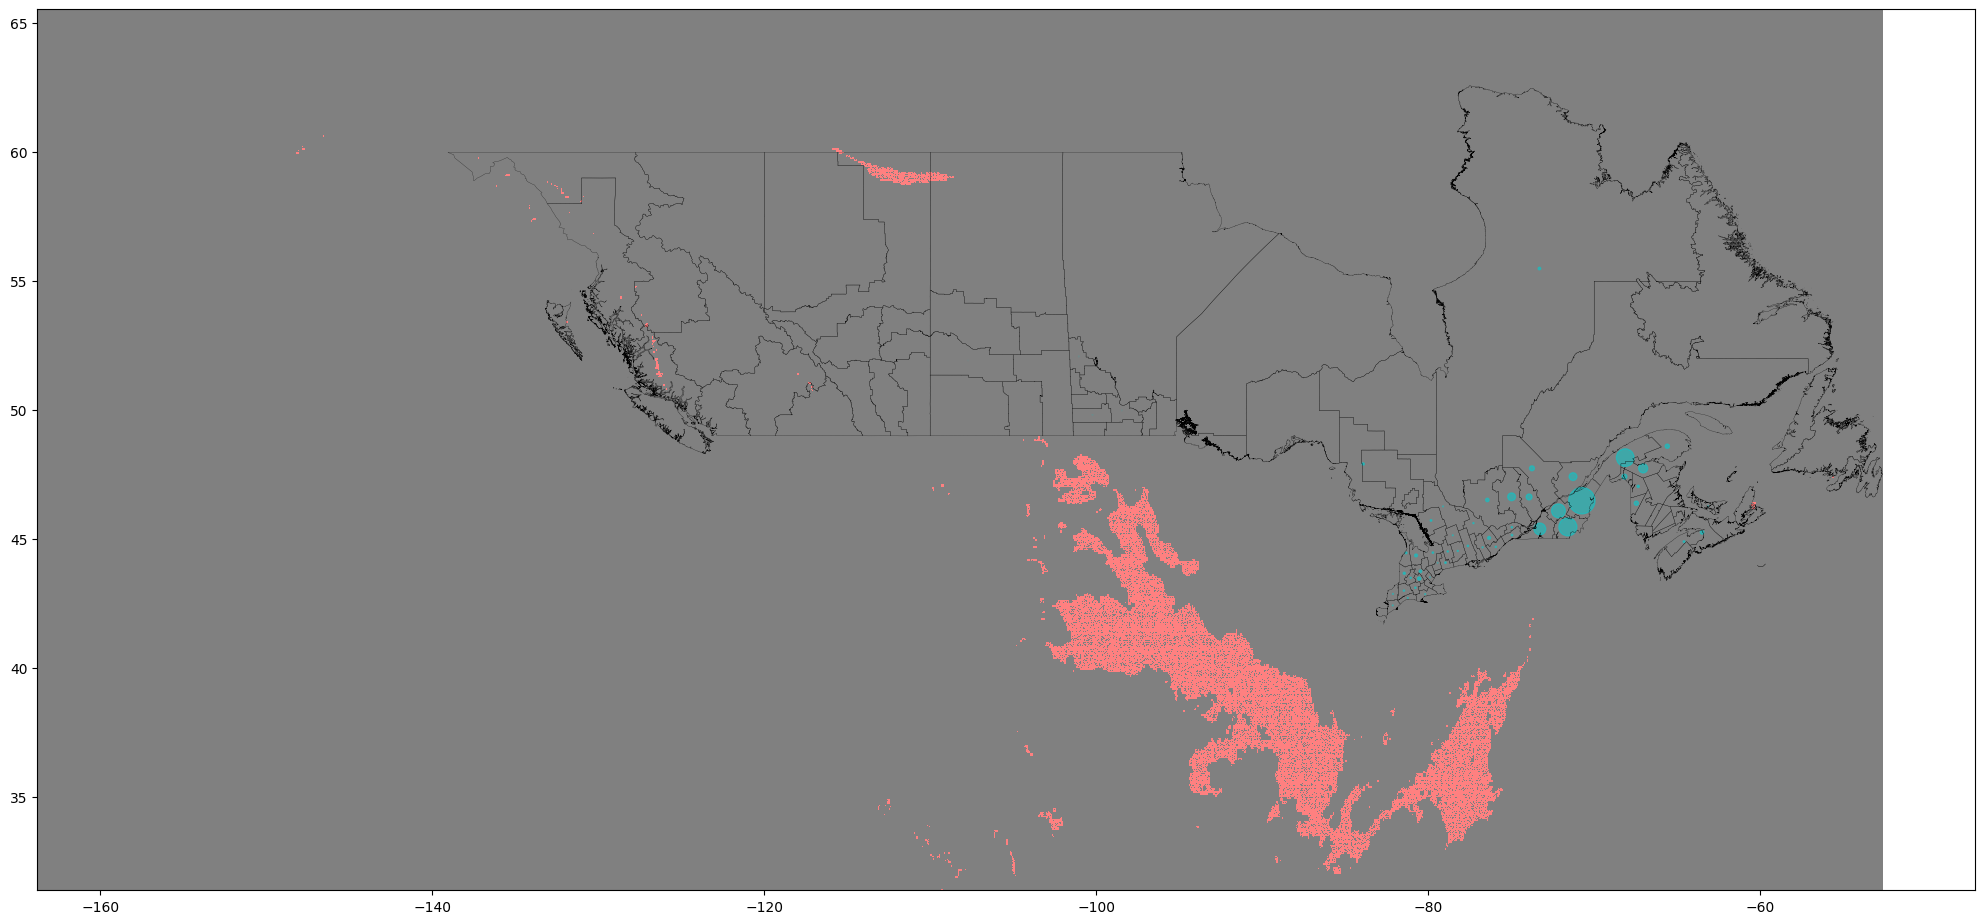

In [28]:
_plot_lost_terrain(
    df_CD_and_RAR, 
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=1, 
    color="red"
)

#### Conditions cores et marginales : 2011-2040 vs 2071-2100

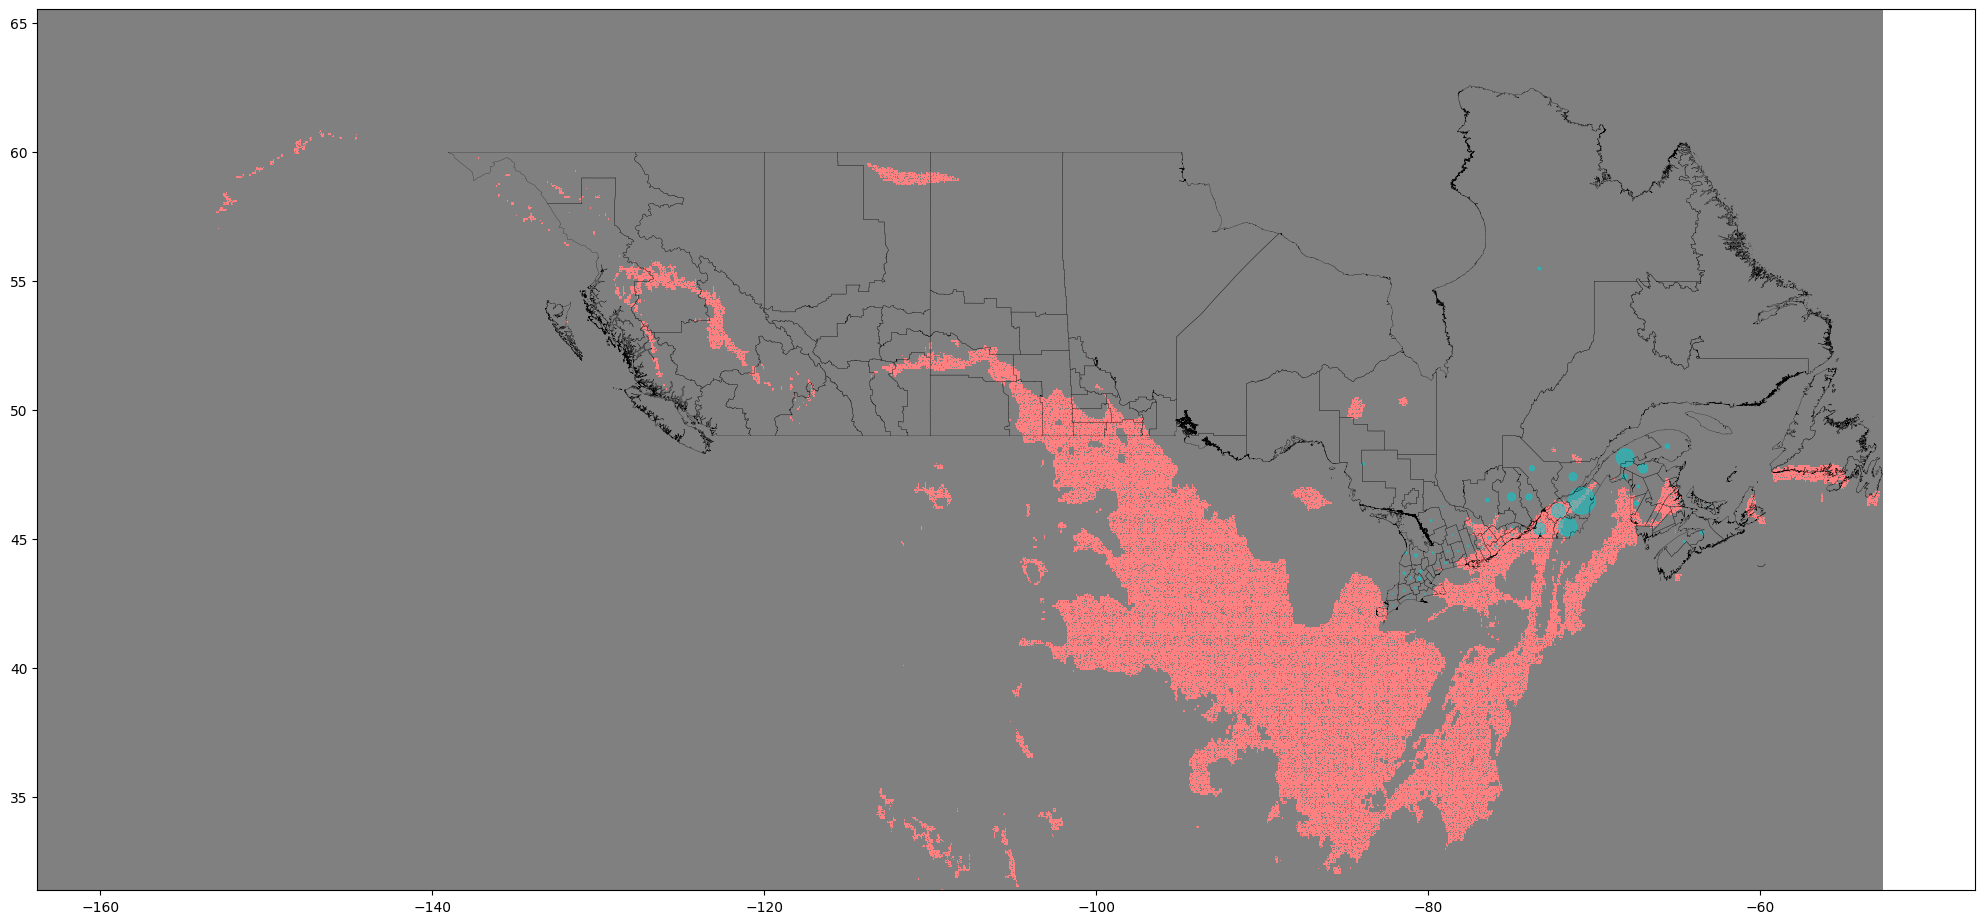

In [29]:
_plot_lost_terrain(
    df_CD_and_RAR, 
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=1, 
    color="red"
)

### 3.2.2. Gains de conditions favorables 

On observe en vert les régions qui ne faisaient partie de la niche climatique dans la période de projection initiale (2011-2040), mais qui en font partie dans la période de projection finale.

#### Conditions cores seulement : 2011-2040 à 2041-2070

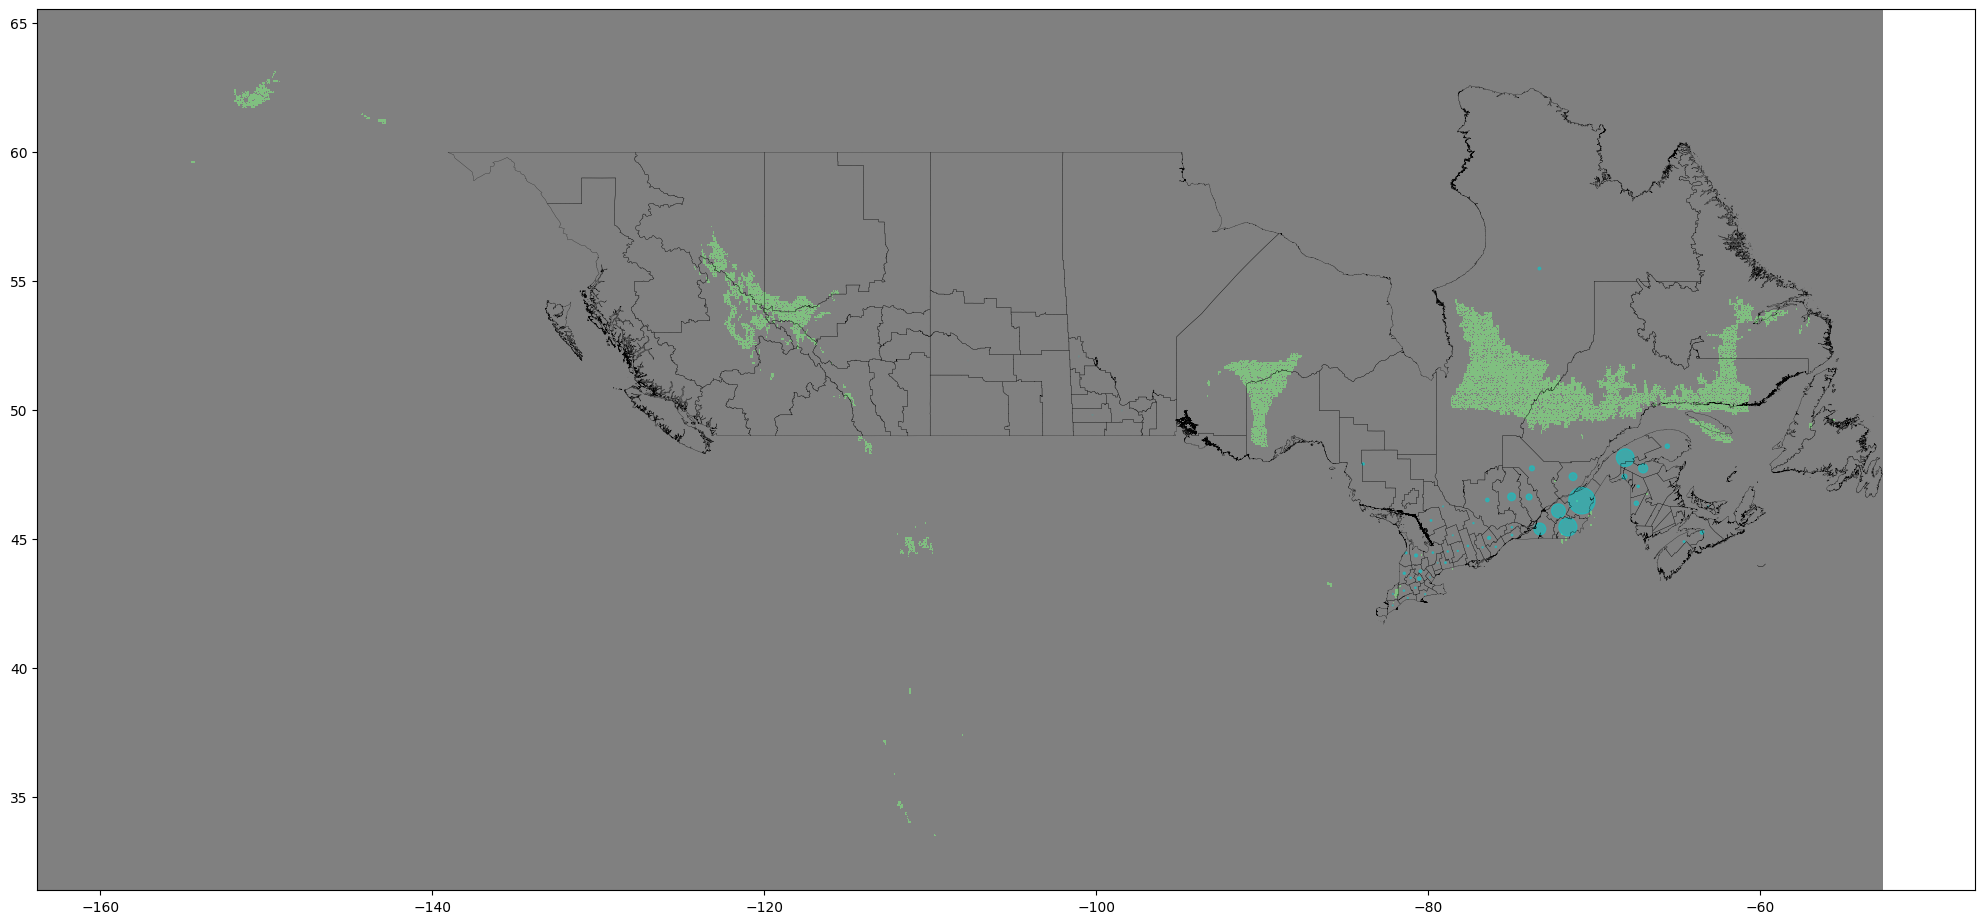

In [30]:
_plot_lost_terrain(
    df_CD_and_RAR, 
    registered_raster_2041_2070, 
    registered_raster_2011_2040, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=3, 
    color="green"
)

#### Conditions cores seulement : 2011-2040 à 2071-2100

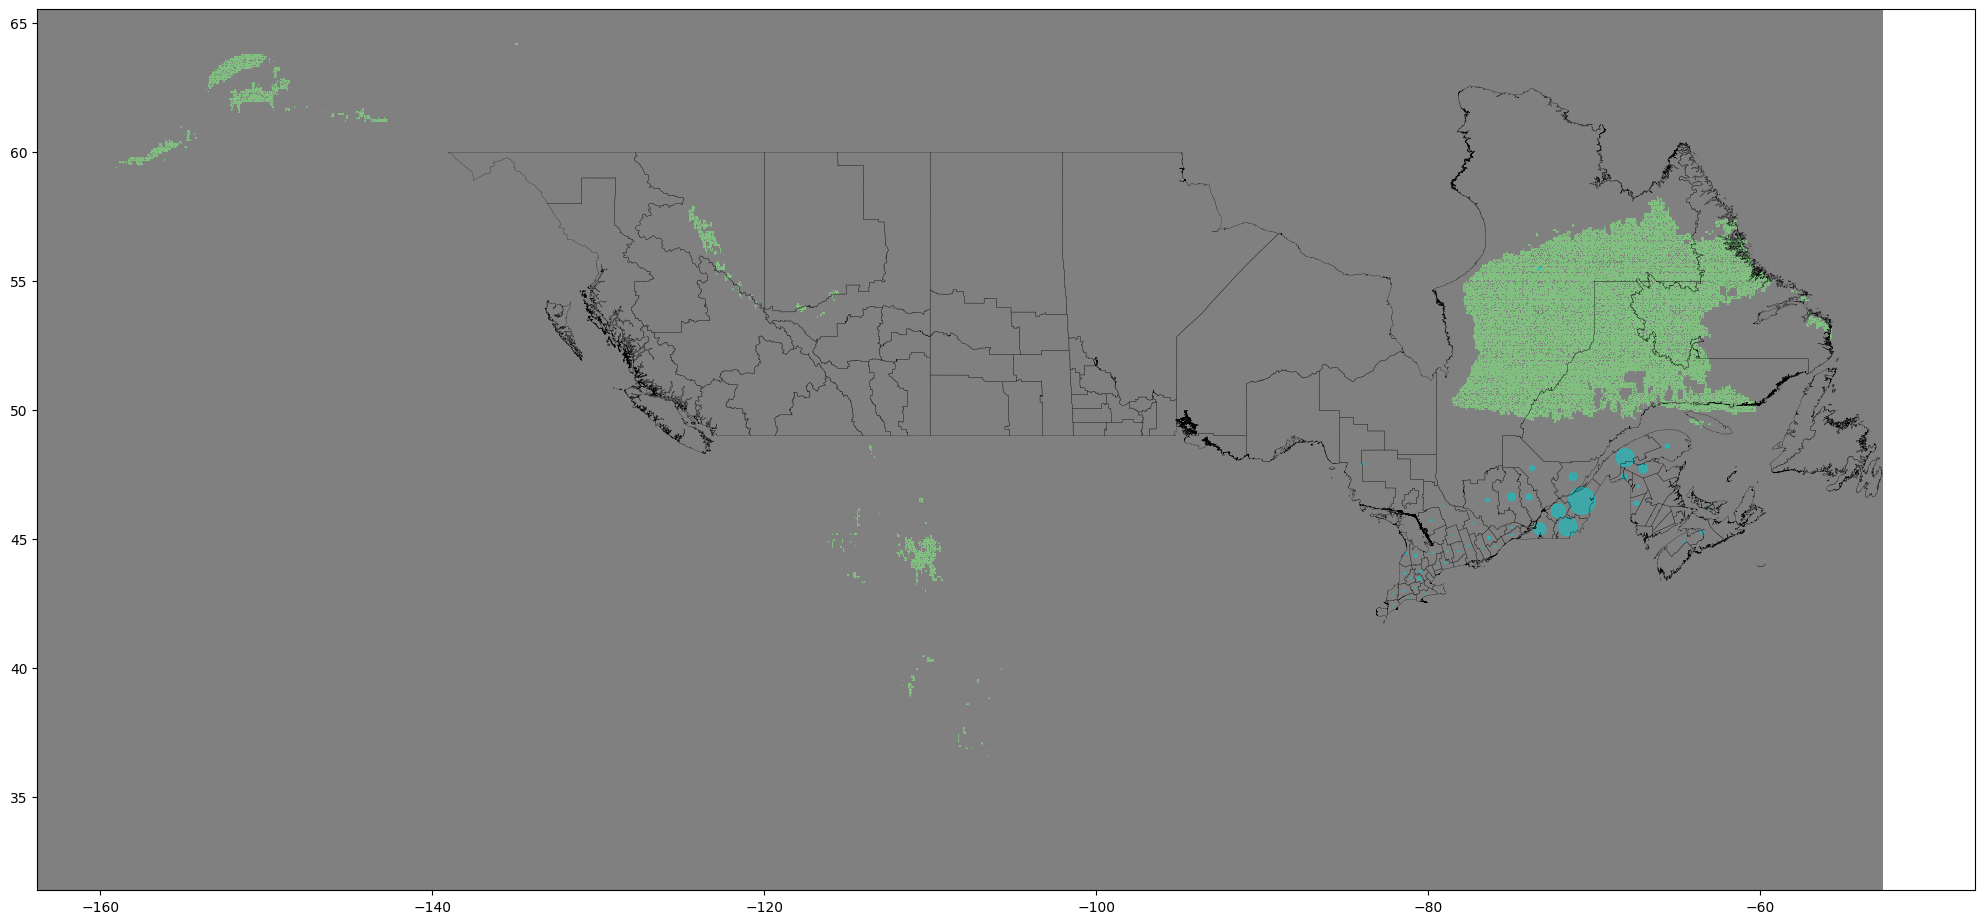

In [31]:
_plot_lost_terrain(
    df_CD_and_RAR, 
    registered_raster_2071_2100, 
    registered_raster_2011_2040, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=3, 
    color="green"
)

#### Conditions cores et marginales : 2011-2040 à 2041-2070

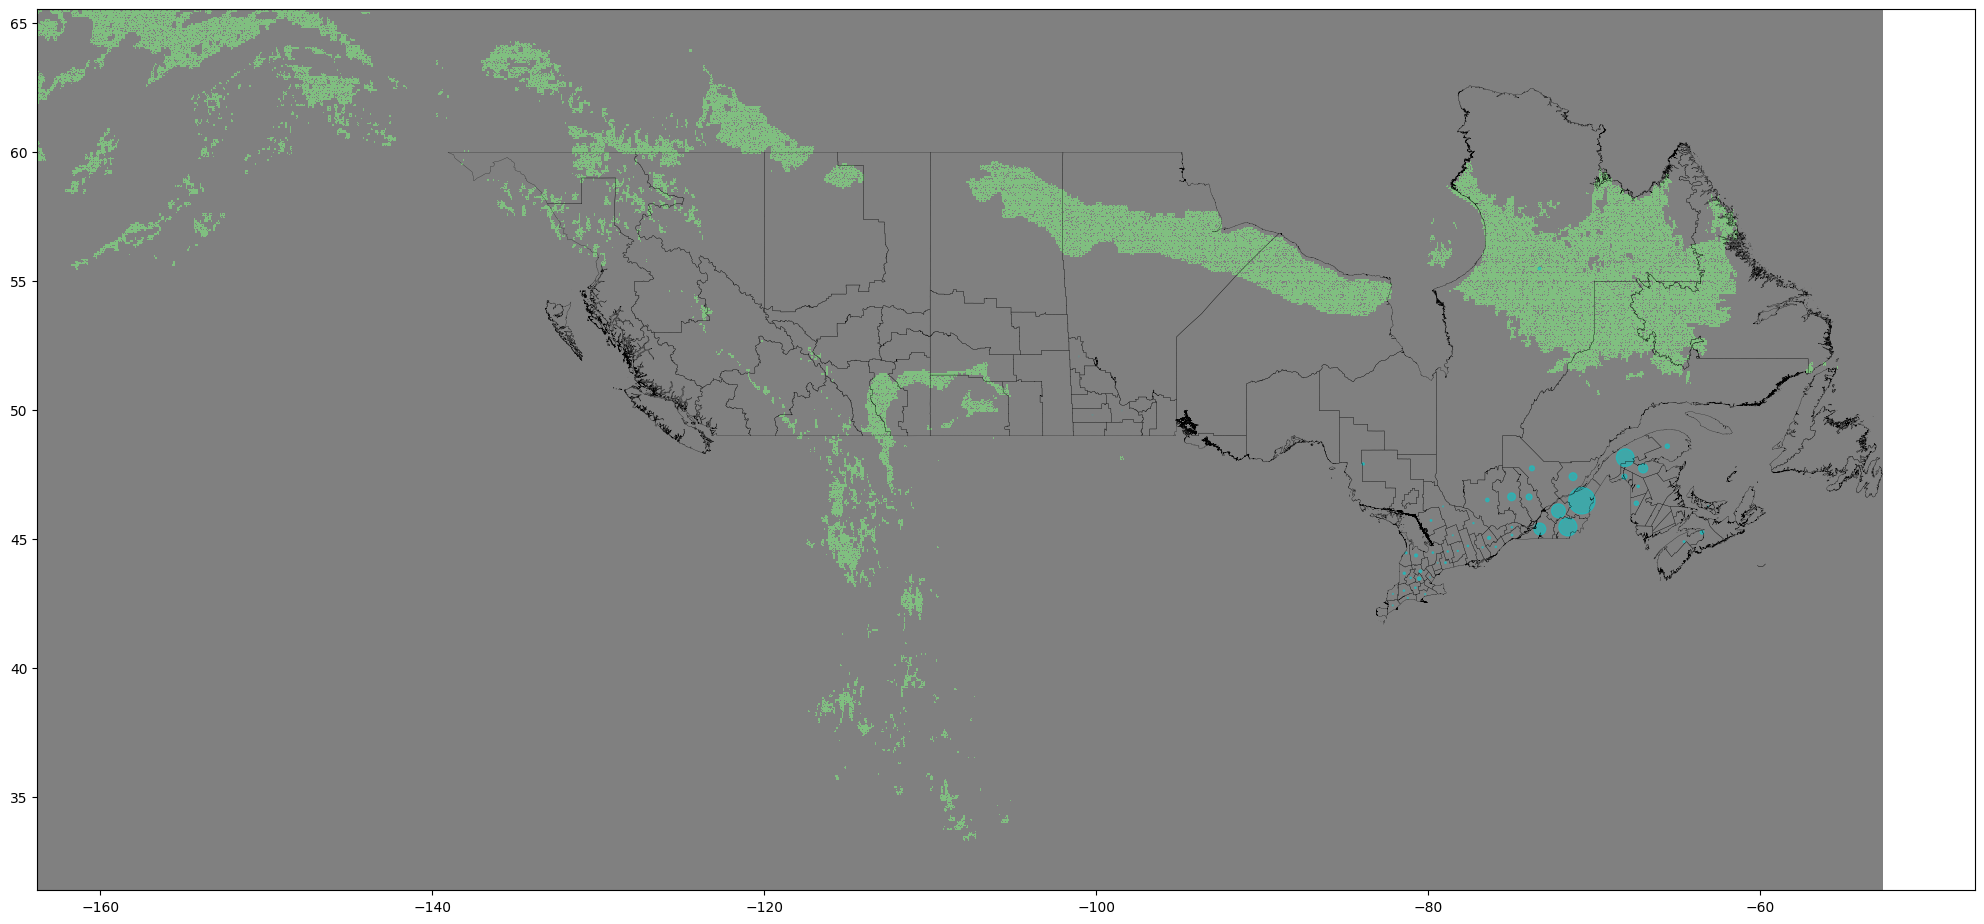

In [32]:
_plot_lost_terrain(
    df_CD_and_RAR, 
    registered_raster_2041_2070, 
    registered_raster_2011_2040, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=1, 
    color="green"
)

#### Conditions cores et marginales : 2011-2040 à 2071-2100

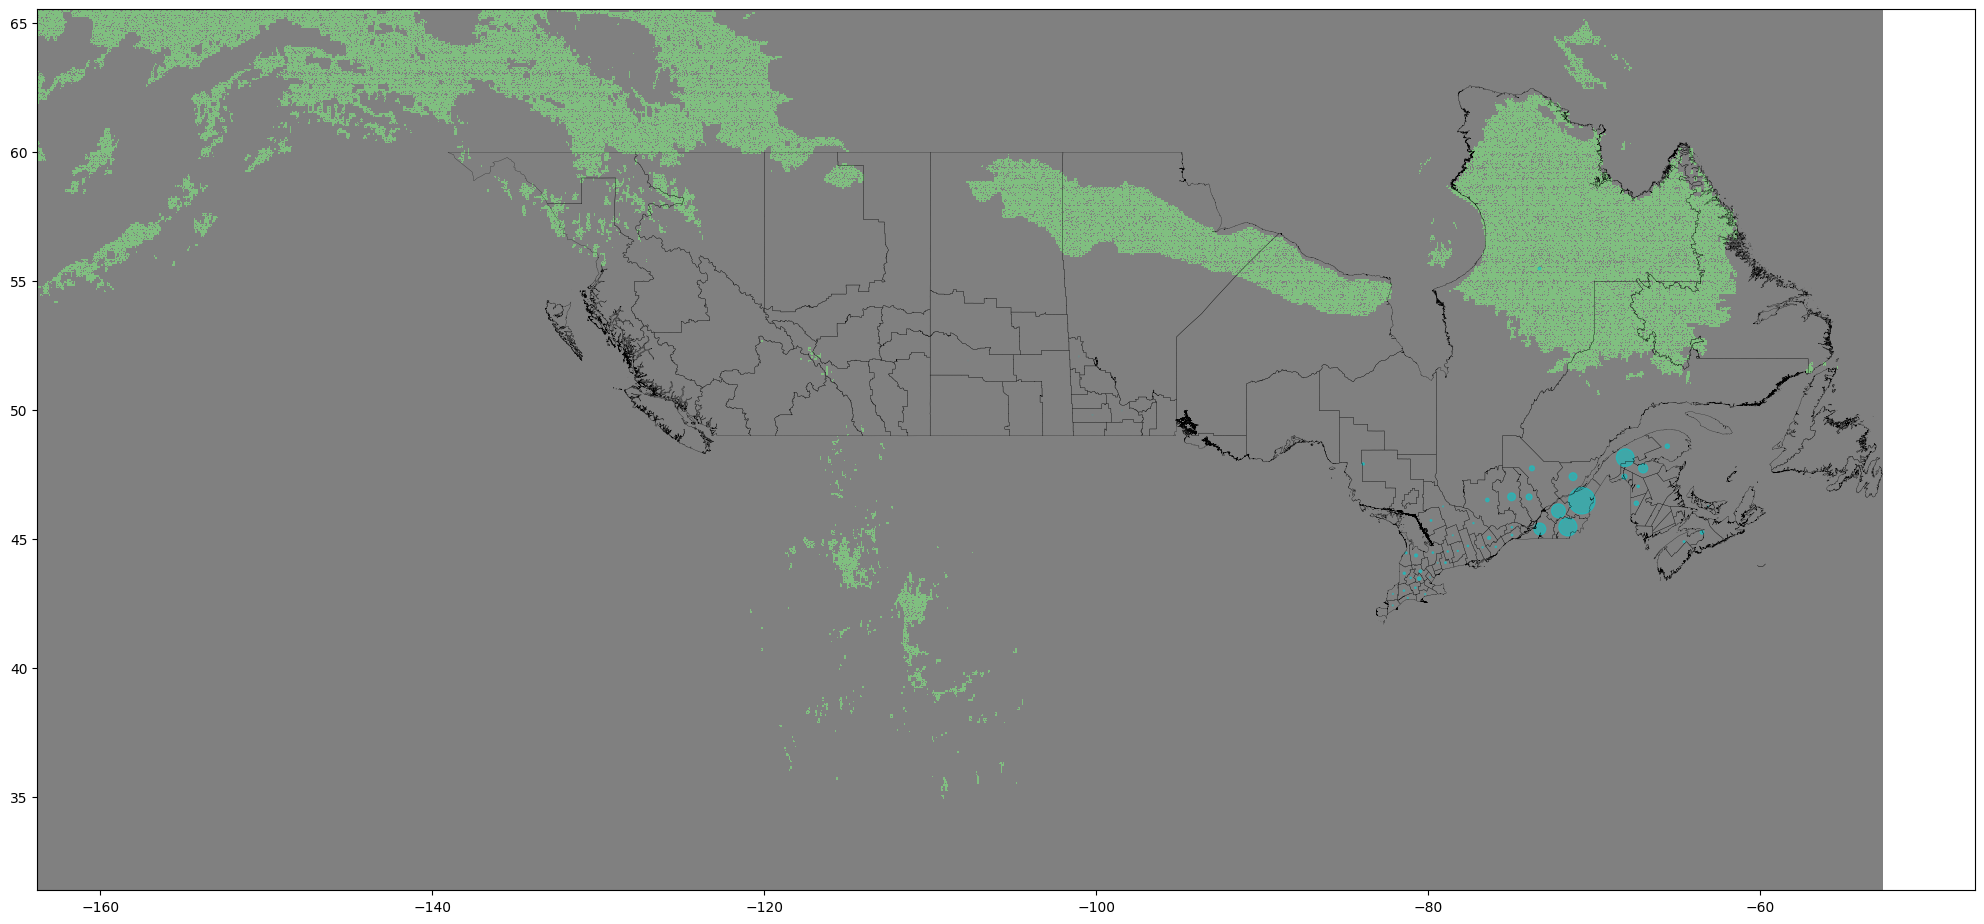

In [33]:
_plot_lost_terrain(
    df_CD_and_RAR, 
    registered_raster_2071_2100, 
    registered_raster_2011_2040, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=1, 
    color="green"
)

# 4. Réponses aux questions de recherche

Pour répondre aux questions de recherche, on définit deux scénarios :
- Scénario A : on ne considère que les zones avec les conditions climatiques cores.
- Scénario B : on considère les zones avec les conditions climatiques cores et marginales.

On décline également la réponse par rapport aux projections de 2041-2070, puis aux projections de 2071-2100.

On s'attend à ce que les différences les plus marquées soient observées selon le scénario A, avec les projections de 2071-2100, et les différences les moins marquées avec le scénario B et les projections de 2041-2070.

Les conclusions aux questions de recherche sont affichées <span style="color:red"> en rouge </span>.

## 4.1. Où se situent les zones propices au développement de l’érable à sucre au Canada et comment seront-elles affectées par le réchauffement climatique?

### 4.1.1.  Y a-t-il des zones actuellement propices qui ne le seront plus du tout?

In [34]:
# Scénario A 
df["diff_A_2011_vs_2041"] = df["core_2011-2040"] - df["core_2011_and_2041"]
df["diff_A_2011_vs_2071"] = df["core_2011-2040"] - df["core_2011_and_2071"]

# Scénario B
df["core_marginal_2011-2040"] = df["core_2011-2040"] + df["marginal_2011-2040"]
df["core_marginal_2041-2070"] = df["core_2041-2070"] + df["marginal_2041-2070"]
df["core_marginal_2071-2100"] = df["core_2071-2100"] + df["marginal_2071-2100"]
df["diff_B_2011_vs_2041"] = df["core_marginal_2011-2040"] - df["marginal_2011_and_2041"]
df["diff_B_2011_vs_2071"] = df["core_marginal_2011-2040"] - df["marginal_2011_and_2071"]

#### Scénario A (2011-2040 vs 2041-2070)

On affiche les données ordonnées en fonction des pertes de zones idéales (`diff_A_2011_vs_2041`). 
- `core_2011-2040` et `core_2041-2070` représentent l'aire totale (en kilomètres carrés) des zones idéales pour les périodes de projection.
- `core_2011_and_2041` représente l'aire totale idéale en 2011 et qui le serait toujours en 2041.

<span style="color:red"> 
On constate que les régions du Nord, du Sud et de l'Est de l'Ontario sont On constate que le Nord, le Sud et l'Est de l'Ontario sont les régions où on enregistrerait les plus importantes pertes de zones idéales. Malgré tout, les projections de 2041-2070 indiquent qu'une grande partie de ces régions serait encore idéale au développement de l'érable à sucre (19 750 km carrés pour le Nord, 669 km carrés pour le Sud et 294 km carrés pour l'Est). De cette aire en 2041, une bonne partie est déjà dans des conditions optimales dans la période actuelle de projection (13 000 km carrés pour le Nord, 600 km carrés pour le Sud et 294 km carrés pour l'Est).
<br/>
<br/>
Il en va de même pour la région agricole de recensement 2 de Terre-Neuve-et-Labrador où 1788 km carrés demeureraient dans la niche climatique core de l’érable, la quasi-totalité de cette aire s’y trouvant également dans la période actuelle de projection.
    
À l'inverse, les régions agricoles de recensement 2 et 3 du Nouveau-Brunswick ainsi que la Montérégie (Québec) enregistreraient d'importantes pertes. On constate que ces régions se retrouveraient dans de nouvelles conditions de croissance pour l'érable à sucre en 2041 (moins de 56 km carrés demeureraient dans la niche climatique core).
    
De même, la région agricole de recensement 3 de la Nouvelle-Écosse ainsi que les régions agricoles de recensement 2 et 3 de l'Île-du-Prince-Édouard sont actuellement dans la niche climatique core, mais ne seraient plus du tout (moins de 10 km carrés) en 2041.
</span>

In [35]:
df.sort_values(
    "diff_A_2011_vs_2041", 
    ascending=False
)[[
    "area_name", 
    "province", 
    "diff_A_2011_vs_2041", 
    "core_2011-2040",
    "core_2041-2070",
    "core_2011_and_2041"
]].reset_index()

index                              area_name                 province  \
0      33            Région du Nord de l'Ontario                  Ontario   
1      29             Région du Sud de l'Ontario                  Ontario   
2      32           Région de l'Est de l'Ontario                  Ontario   
3       1       Région agricole de recensement 2  Terre-Neuve-et-Labrador   
4      12       Région agricole de recensement 2        Nouveau-Brunswick   
5      27                             Montérégie                   Québec   
6      13       Région agricole de recensement 3        Nouveau-Brunswick   
7      31          Région du Centre de l'Ontario                  Ontario   
8      25         Gaspésie--Îles-de-la-Madeleine                   Québec   
9      11       Région agricole de recensement 1        Nouveau-Brunswick   
10     14       Région agricole de recensement 4        Nouveau-Brunswick   
11     24  Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
12     30         Région de l'Ouest de l'Ontario                  Ontario   
13     28                       Centre-du-Québec                   Québec   
14      8       Région agricole de recensement 3          Nouvelle-Écosse   
15      5       Région agricole de recensement 3    Île-du-Prince-Édouard   
16      4       Région agricole de recensement 2    Île-du-Prince-Édouard   
17     21                             Lanaudière                   Québec   
18     23                            Laurentides                   Québec   
19      2       Région agricole de recensement 3  Terre-Neuve-et-Labrador   
20     22                              Outaouais                   Québec   
21      3       Région agricole de recensement 1    Île-du-Prince-Édouard   
22      9       Région agricole de recensement 4          Nouvelle-Écosse   
23     18                               Mauricie                   Québec   
24     20                        Montréal--Laval                   Québec   
25     15                      Bas-Saint-Laurent                   Québec   
26      7       Région agricole de recensement 2          Nouvelle-Écosse   
27     17                                 Québec                   Québec   
28     65                                Cariboo     Colombie-Britannique   
29     57      Région agricole de recensement 4B                  Alberta   
30     56      Région agricole de recensement 4A                  Alberta   
31     53       Région agricole de recensement 1                  Alberta   
32     55       Région agricole de recensement 3                  Alberta   
33     54       Région agricole de recensement 2                  Alberta   
34     59       Région agricole de recensement 6                  Alberta   
35     52       Région agricole de recensement 7             Saskatchewan   
36     51       Région agricole de recensement 6             Saskatchewan   
37     58       Région agricole de recensement 5                  Alberta   
38      0       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
39     60       Région agricole de recensement 7                  Alberta   
40     61                 Vancouver Island-Coast     Colombie-Britannique   
41     62               Lower Mainland-Southwest     Colombie-Britannique   
42     63                      Thompson-Okanagan     Colombie-Britannique   
43     49       Région agricole de recensement 4             Saskatchewan   
44     64                               Kootenay     Colombie-Britannique   
45     66                            North Coast     Colombie-Britannique   
46     67                                Nechako     Colombie-Britannique   
47     50       Région agricole de recensement 5             Saskatchewan   
48     34       Région agricole de recensement 1                 Manitoba   
49     48       Région agricole de recensement 3             Saskatchewan   
50     47       Région agricole de recensement 2             Saskatchewan   


<span style="color:red"> 
En outre, ces régions, qui se trouvaient aussi dans la niche climatique core en 2011-2040, en sortiraient en 2041-2070.
</span>

In [36]:
df[
    (df["core_2011-2040"] > 0) & 
    (df["core_2041-2070"] == 0) & 
    (df["core_2011_and_2041"] == 0)
].sort_values("core_2011-2040")[[
    "area_name", 
    "province",
    "core_2011-2040", 
    "core_2041-2070",
    "core_2011_and_2041"
]]

area_name               province  core_2011-2040  \
7   Région agricole de recensement 2        Nouvelle-Écosse            6.25   
20                   Montréal--Laval                 Québec           75.00   
9   Région agricole de recensement 4        Nouvelle-Écosse          100.00   
5   Région agricole de recensement 3  Île-du-Prince-Édouard          212.50   
8   Région agricole de recensement 3        Nouvelle-Écosse          268.75   

    core_2041-2070  core_2011_and_2041  
7              0.0                 0.0  
20             0.0                 0.0  
9              0.0                 0.0  
5              0.0                 0.0  
8              0.0                 0.0

#### Scénario A (2011-2040 vs 2071-2100)

On affiche les données ordonnées en fonction des pertes de zones idéales (`diff_A_2011_vs_2071`). 
- `core_2011-2040` et `core_2041-2100` représentent l'aire totale (en kilomètres carrés) des zones idéales pour les périodes de projection.
- `core_2011_and_2071` représente l'aire totale idéale en 2011 et qui le serait toujours en 2071.

<span style="color:red"> 
Les conclusions sont plus dramatiques en 2071-2100. Presque toutes les régions d’un bout à l’autre de pays, à l’exception du nord du Québec, sortiraient de la niche climatique core de l’érable. 
<br/>
<br/> 
On note quelques exceptions, notamment la Mauricie (Québec) et la région agricole de recensement 2 de Terre-Neuve-et-Labrador, où une faible partie du territoire demeurerait dans des conditions de croissance idéales pour l'érable à sucre (187 km carrés pour la Mauricie et 337 km carrés pour la Région agricole de recensement 2 de T.-N.-L.).
<br/>
<br/>
Les régions de l'Abitibi-Témiscamingue et du Saguenay-Lac-Saint-Jean-Côte-Nord feraient également exception. Ces régions enregistreraient parmi les pertes les plus importantes au pays, mais verraient un accroissement de l’aire idéale au sein même de leur territoire (54 000 km carrés pour l'Abitibi et 26 000 km carrés pour le Saguenay). Il s'agit toutefois de nouvelles zones, c'est-à-dire que les zones qui seraient idéales en 2071 ne le sont pas dans la période actuelle de projection.
</span>

In [37]:
df.sort_values(
    "diff_A_2011_vs_2071", 
    ascending=False
).reset_index()[[
    "area_name",  
    "province",
    "diff_A_2011_vs_2071", 
    "core_2011-2040",
    "core_2071-2100",
    "core_2011_and_2071",
]]

area_name                 province  \
0             Région du Nord de l'Ontario                  Ontario   
1   Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
2     Saguenay--Lac-Saint-Jean--Côte-Nord                   Québec   
3                                Mauricie                   Québec   
4                               Outaouais                   Québec   
5        Région agricole de recensement 4        Nouveau-Brunswick   
6        Région agricole de recensement 2  Terre-Neuve-et-Labrador   
7          Région de l'Ouest de l'Ontario                  Ontario   
8           Région du Centre de l'Ontario                  Ontario   
9                       Bas-Saint-Laurent                   Québec   
10                            Laurentides                   Québec   
11         Gaspésie--Îles-de-la-Madeleine                   Québec   
12             Région du Sud de l'Ontario                  Ontario   
13       Région agricole de recensement 1        Nouveau-Brunswick   
14           Région de l'Est de l'Ontario                  Ontario   
15                             Lanaudière                   Québec   
16       Région agricole de recensement 2        Nouveau-Brunswick   
17                             Montérégie                   Québec   
18       Région agricole de recensement 3        Nouveau-Brunswick   
19                   Chaudière-Appalaches                   Québec   
20                       Centre-du-Québec                   Québec   
21                                Cariboo     Colombie-Britannique   
22       Région agricole de recensement 3  Terre-Neuve-et-Labrador   
23                                 Québec                   Québec   
24       Région agricole de recensement 3          Nouvelle-Écosse   
25       Région agricole de recensement 3    Île-du-Prince-Édouard   
26       Région agricole de recensement 2    Île-du-Prince-Édouard   
27                            Peace River     Colombie-Britannique   
28       Région agricole de recensement 1    Île-du-Prince-Édouard   
29       Région agricole de recensement 4          Nouvelle-Écosse   
30                                 Estrie                   Québec   
31                        Montréal--Laval                   Québec   
32       Région agricole de recensement 2          Nouvelle-Écosse   
33       Région agricole de recensement 5             Saskatchewan   
34       Région agricole de recensement 5                  Alberta   
35       Région agricole de recensement 7             Saskatchewan   
36       Région agricole de recensement 1                  Alberta   
37       Région agricole de recensement 2                  Alberta   
38       Région agricole de recensement 3                  Alberta   
39      Région agricole de recensement 4A                  Alberta   
40      Région agricole de recensement 4B                  Alberta   
41                 Vancouver Island-Coast     Colombie-Britannique   
42       Région agricole de recensement 6                  Alberta   
43       Région agricole de recensement 7                  Alberta   
44               Lower Mainland-Southwest     Colombie-Britannique   
45                      Thompson-Okanagan     Colombie-Britannique   
46                               Kootenay     Colombie-Britannique   
47                                Nechako     Colombie-Britannique   
48                            North Coast     Colombie-Britannique   
49       Région agricole de recensement 6             Saskatchewan   
50       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
51       Région agricole de recensement 4             Saskatchewan   
52       Région agricole de recensement 3             Saskatchewan   
53       Région agricole de recensement 1          Nouvelle-Écosse   
54       Région agricole de recensement 5          Nouvelle-Écosse   
55       Région agricole de recensement 2                 Manitoba   
56       Région agricole de recensement 3 

<span style="color:red"> 
Ces régions se trouvaient en partie dans des conditions idéales en 2011-2040, mais en sortiraient complètement en 2071-2100.
</span>

In [38]:
df[
    (df["core_2011-2040"] > 0) & 
    (df["core_2071-2100"] == 0) & 
    (df["core_2011_and_2071"] == 0)
].sort_values("core_2011-2040", ascending=False)[[
    "area_name", 
    "province",
    "core_2011-2040", 
    "core_2071-2100", 
    "core_2011_and_2071"
]]

area_name               province  core_2011-2040  \
22                         Outaouais                 Québec         3550.00   
14  Région agricole de recensement 4      Nouveau-Brunswick         2718.75   
30    Région de l'Ouest de l'Ontario                Ontario         2506.25   
31     Région du Centre de l'Ontario                Ontario         2487.50   
15                 Bas-Saint-Laurent                 Québec         2443.75   
25    Gaspésie--Îles-de-la-Madeleine                 Québec         2187.50   
29        Région du Sud de l'Ontario                Ontario         1975.00   
11  Région agricole de recensement 1      Nouveau-Brunswick         1856.25   
32      Région de l'Est de l'Ontario                Ontario         1575.00   
27                        Montérégie                 Québec         1056.25   
12  Région agricole de recensement 2      Nouveau-Brunswick         1056.25   
13  Région agricole de recensement 3      Nouveau-Brunswick          850.00   
26              Chaudière-Appalaches                 Québec          700.00   
28                  Centre-du-Québec                 Québec          637.50   
8   Région agricole de recensement 3        Nouvelle-Écosse          268.75   
4   Région agricole de recensement 2  Île-du-Prince-Édouard          212.50   
5   Région agricole de recensement 3  Île-du-Prince-Édouard          212.50   
3   Région agricole de recensement 1  Île-du-Prince-Édouard          162.50   
9   Région agricole de recensement 4        Nouvelle-Écosse          100.00   
19                            Estrie                 Québec           87.50   
20                   Montréal--Laval                 Québec           75.00   
7   Région agricole de recensement 2        Nouvelle-Écosse            6.25   

    core_2071-2100  core_2011_and_2071  
22             0.0                 0.0  
14             0.0                 0.0  
30             0.0                 0.0  
31             0.0                 0.0  
15             0.0                 0.0  
25             0.0                 0.0  
29             0.0                 0.0  
11             0.0                 0.0  
32             0.0                 0.0  
27             0.0                 0.0  
12             0.0                 0.0  
13             0.0                 0.0  
26             0.0                 0.0  
28             0.0                 0.0  
8              0.0                 0.0  
4              0.0                 0.0  
5              0.0                 0.0  
3              0.0                 0.0  
9              0.0                 0.0  
19             0.0                 0.0  
20             0.0                 0.0  
7              0.0                 0.0

#### Scénario B (2011-2040 vs 2041-2070)

On affiche les données ordonnées en fonction des pertes de zones idéales et tolérables (`diff_B_2011_vs_2041`). 
- `core_marginal_2011-2040` et `core_marginal_2041-2070` représentent l'aire totale (en kilomètre carrés) des zones idéales et tolérables pour les périodes de projection.
- `marginal_2011_and_2041` représente l'aire totale aux conditions idéales et tolérables en 2011-2040 et qui le serait toujours en 2041-2070. 

<span style="color:red"> 
Lorsqu'on considère les conditions climatiques core et marginale, on observe les pertes les plus importantes dans des régions où l'aire propice serait plus grande en 2041-2070 qu'elle ne l'était en 2011-2040. On observe donc clairement un déplacement des aires au sein même de ces régions. On note entre autres la région du Nord de l'Ontario, qui enregistrerait une perte de 20 000 km carrés d'aire propice, mais qui verrait la création de plus 33 000 km carrés de nouvelle aire propice.
</span>

In [39]:
df.sort_values(
    "diff_B_2011_vs_2041", 
    ascending=False
).reset_index()[[
    "area_name",  
    "province",
    "diff_B_2011_vs_2041", 
    "core_marginal_2011-2040", 
    "core_marginal_2041-2070",
    "marginal_2011_and_2041"
]]

area_name                 province  \
0             Région du Nord de l'Ontario                  Ontario   
1     Saguenay--Lac-Saint-Jean--Côte-Nord                   Québec   
2   Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
3                                 Cariboo     Colombie-Britannique   
4        Région agricole de recensement 3  Terre-Neuve-et-Labrador   
5        Région agricole de recensement 6                  Alberta   
6                             Peace River     Colombie-Britannique   
7        Région agricole de recensement 7                  Alberta   
8              Région du Sud de l'Ontario                  Ontario   
9        Région agricole de recensement 2  Terre-Neuve-et-Labrador   
10           Région de l'Est de l'Ontario                  Ontario   
11       Région agricole de recensement 3                  Alberta   
12                                Nechako     Colombie-Britannique   
13       Région agricole de recensement 2        Nouveau-Brunswick   
14                             Montérégie                   Québec   
15          Région du Centre de l'Ontario                  Ontario   
16       Région agricole de recensement 3        Nouveau-Brunswick   
17       Région agricole de recensement 1        Nouveau-Brunswick   
18                      Thompson-Okanagan     Colombie-Britannique   
19         Gaspésie--Îles-de-la-Madeleine                   Québec   
20       Région agricole de recensement 4        Nouveau-Brunswick   
21                            North Coast     Colombie-Britannique   
22                 Vancouver Island-Coast     Colombie-Britannique   
23         Région de l'Ouest de l'Ontario                  Ontario   
24       Région agricole de recensement 7             Saskatchewan   
25                       Centre-du-Québec                   Québec   
26                   Chaudière-Appalaches                   Québec   
27       Région agricole de recensement 3          Nouvelle-Écosse   
28                               Kootenay     Colombie-Britannique   
29       Région agricole de recensement 5                  Alberta   
30       Région agricole de recensement 3    Île-du-Prince-Édouard   
31                                 Estrie                   Québec   
32       Région agricole de recensement 2    Île-du-Prince-Édouard   
33       Région agricole de recensement 2             Saskatchewan   
34                             Lanaudière                   Québec   
35                            Laurentides                   Québec   
36                              Outaouais                   Québec   
37                               Mauricie                   Québec   
38       Région agricole de recensement 1    Île-du-Prince-Édouard   
39       Région agricole de recensement 4          Nouvelle-Écosse   
40               Lower Mainland-Southwest     Colombie-Britannique   
41                                 Québec                   Québec   
42                        Montréal--Laval                   Québec   
43       Région agricole de recensement 5          Nouvelle-Écosse   
44       Région agricole de recensement 1             Saskatchewan   
45                      Bas-Saint-Laurent                   Québec   
46       Région agricole de recensement 2          Nouvelle-Écosse   
47      Région agricole de recensement 4B                  Alberta   
48      Région agricole de recensement 4A                  Alberta   
49       Région agricole de recensement 2                  Alberta   
50       Région agricole de recensement 1                  Alberta   
51       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
52       Région agricole de recensement 6             Saskatchewan   
53       Région agricole de recensement 7                 Manitoba   
54       Région agricole de recensement 1          Nouvelle-Écosse   
55       Région agricole de recensement 2                 Manitoba   
56       Région agricole de recensement 3 

<span style="color:red"> 
Ces régions se trouvaient dans des conditions de croissance idéales ou tolérables en 2011-2040, mais en sortiraient complètement en 2041-2070.
</span>

In [40]:
df[
    (df["core_marginal_2011-2040"] > 0) & 
    (df["core_marginal_2041-2070"] == 0) & 
    (df["marginal_2011_and_2041"] == 0)
].sort_values("core_2011-2040", ascending=False)[[
    "area_name", 
    "province",
    "core_marginal_2011-2040", 
    "core_marginal_2041-2070", 
    "marginal_2011_and_2041"
]]

area_name              province  core_marginal_2011-2040  \
62  Lower Mainland-Southwest  Colombie-Britannique                    93.75   

    core_marginal_2041-2070  marginal_2011_and_2041  
62                      0.0                     0.0

#### Scénario B (2011-2040 vs 2071-2100)


On affiche les données ordonnées en fonction des pertes de zones idéales et tolérables (`diff_B_2011_vs_2071`). 
- `core_marginal_2011-2040` et `core_marginal_2071-2100` représentent l'aire totale (en kilomètre carrés) des zones idéales ou tolérables pour les périodes de projection.
- `marginal_2011_and_2071` représente l'aire totale aux conditions idéales et tolérables en 2011 et qui le serait toujours en 2071.

<span style="color:red"> 
En 2071-2100, le portrait est similaire.
<br/>
<br/>
On note toutefois au 8e rang des pertes de zones propices, la région de l'Outaouais. L'entièreté des zones qui se trouvaient dans des conditions idéales ou tolérables dans la période actuelle de projection ne le serait plus en 2071-2100. Il en va de même pour la région agricole de recensement du Nouveau-Brunswick, le Bas-Saint-Laurent et les Laurentides, où moins de 100 km carrés de la zone actuelle resteraient propices en 2071-2100.
</span>

In [41]:
df.sort_values(
    "diff_B_2011_vs_2071", 
    ascending=False
).reset_index()[[
    "area_name",  
    "province",
    "diff_B_2011_vs_2071", 
    "core_marginal_2011-2040", 
    "core_marginal_2071-2100",
    "marginal_2011_and_2071",
]]

area_name                 province  \
0             Région du Nord de l'Ontario                  Ontario   
1   Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
2     Saguenay--Lac-Saint-Jean--Côte-Nord                   Québec   
3        Région agricole de recensement 3  Terre-Neuve-et-Labrador   
4        Région agricole de recensement 2  Terre-Neuve-et-Labrador   
5                                 Nechako     Colombie-Britannique   
6                                Mauricie                   Québec   
7                                 Cariboo     Colombie-Britannique   
8                               Outaouais                   Québec   
9        Région agricole de recensement 1             Saskatchewan   
10          Région du Centre de l'Ontario                  Ontario   
11       Région agricole de recensement 4             Saskatchewan   
12           Région de l'Est de l'Ontario                  Ontario   
13                            North Coast     Colombie-Britannique   
14       Région agricole de recensement 2             Saskatchewan   
15       Région agricole de recensement 4        Nouveau-Brunswick   
16         Région de l'Ouest de l'Ontario                  Ontario   
17                      Bas-Saint-Laurent                   Québec   
18                            Laurentides                   Québec   
19                            Peace River     Colombie-Britannique   
20         Gaspésie--Îles-de-la-Madeleine                   Québec   
21       Région agricole de recensement 6                  Alberta   
22             Région du Sud de l'Ontario                  Ontario   
23       Région agricole de recensement 1        Nouveau-Brunswick   
24                             Lanaudière                   Québec   
25                      Thompson-Okanagan     Colombie-Britannique   
26                             Montérégie                   Québec   
27       Région agricole de recensement 2                 Manitoba   
28       Région agricole de recensement 2        Nouveau-Brunswick   
29       Région agricole de recensement 7                 Manitoba   
30       Région agricole de recensement 1                 Manitoba   
31       Région agricole de recensement 3        Nouveau-Brunswick   
32       Région agricole de recensement 8                 Manitoba   
33                 Vancouver Island-Coast     Colombie-Britannique   
34                   Chaudière-Appalaches                   Québec   
35       Région agricole de recensement 6             Saskatchewan   
36                       Centre-du-Québec                   Québec   
37       Région agricole de recensement 1                  Alberta   
38       Région agricole de recensement 7             Saskatchewan   
39                                 Québec                   Québec   
40      Région agricole de recensement 4A                  Alberta   
41       Région agricole de recensement 5          Nouvelle-Écosse   
42       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
43       Région agricole de recensement 7                  Alberta   
44                               Kootenay     Colombie-Britannique   
45       Région agricole de recensement 3                 Manitoba   
46       Région agricole de recensement 2                  Alberta   
47                                 Estrie                   Québec   
48       Région agricole de recensement 3          Nouvelle-Écosse   
49       Région agricole de recensement 9                 Manitoba   
50       Région agricole de recensement 2    Île-du-Prince-Édouard   
51       Région agricole de recensement 3    Île-du-Prince-Édouard   
52       Région agricole de recensement 6                 Manitoba   
53       Région agricole de recensement 1    Île-du-Prince-Édouard   
54       Région agricole de recensement 4          Nouvelle-Écosse   
55       Région agricole de recensement 1          Nouvelle-Écosse   
56               Lower Mainland-Southwest 

<span style="color:red"> 
Ces régions se trouvaient en partie dans la niche climatique core et marginale de l’érable en 2011-2040, mais en sortiraient complètement en 2071-2100.
</span>

In [42]:
df[
    (df["core_marginal_2011-2040"] > 0) & 
    (df["core_marginal_2071-2100"] == 0) & 
    (df["marginal_2011_and_2071"] == 0)
].sort_values("core_2011-2040", ascending=False)[[
    "area_name", 
    "province",
    "core_marginal_2011-2040", 
    "core_marginal_2071-2100", 
    "marginal_2011_and_2071"
]]

area_name              province  \
20                   Montréal--Laval                Québec   
34  Région agricole de recensement 1              Manitoba   
48  Région agricole de recensement 3          Saskatchewan   
61            Vancouver Island-Coast  Colombie-Britannique   
62          Lower Mainland-Southwest  Colombie-Britannique   

    core_marginal_2011-2040  core_marginal_2071-2100  marginal_2011_and_2071  
20                    75.00                      0.0                     0.0  
34                   906.25                      0.0                     0.0  
48                    31.25                      0.0                     0.0  
61                   793.75                      0.0                     0.0  
62                    93.75                      0.0                     0.0

### 4.1.2. Quelle proportion du Canada et des provinces est actuellement favorable au développement de l’érable à sucre? Qu'elle deviendra cette proportion avec le réchauffement climatique?

#### Canada 

On calcule la proportion du Canada qui se trouve dans la niche climatique de l'érable en 2011-2040, 2041-2070 et 2071-2100, selon les scénarios A et B.

<span style="color:red"> 
On constate que la proportion du territoire canadien propice au développement de l'érable pourrait s'accroître avec le temps, qu'on se fit au scénario A ou B. En effet, l'enveloppe climatique ne rétrécirait pas, mais elle se déplacerait plutôt vers le Nord.
</span>

In [43]:
sum_A_2011 = df['core_2011-2040'].sum() / (df['rest_2011-2040'].sum() + df['core_marginal_2011-2040'].sum())
sum_B_2011 = df['core_marginal_2011-2040'].sum() / (df['rest_2011-2040'].sum() + df['core_marginal_2011-2040'].sum())

sum_A_2041 = df['core_2041-2070'].sum() / (df['rest_2041-2070'].sum() + df['core_marginal_2041-2070'].sum())
sum_B_2041 = df['core_marginal_2041-2070'].sum() / (df['rest_2041-2070'].sum() + df['core_marginal_2041-2070'].sum())

sum_A_2071 = df['core_2071-2100'].sum() / (df['rest_2071-2100'].sum() + df['core_marginal_2071-2100'].sum())
sum_B_2071 = df['core_marginal_2071-2100'].sum() / (df['rest_2071-2100'].sum() + df['core_marginal_2071-2100'].sum())

print(f"Scénario A : {round(sum_A_2011, 3)} (2011), {round(sum_A_2041, 3)} (2041), {round(sum_A_2071, 3)} (2071)")
print(f"Scénario B : {round(sum_B_2011, 3)} (2011), {round(sum_B_2041, 3)} (2041), {round(sum_B_2071, 3)} (2071)")

Scénario A : 0.122 (2011), 0.162 (2041), 0.142 (2071)
Scénario B : 0.641 (2011), 0.839 (2041), 0.814 (2071)


<span style="color:red"> 
Selon le scénario A, c'est 70 % de l'aire idéale actuelle qui le serait toujours en 2041-2070, contre seulement 2 % en 2071-2100.
<br/>
Selon le scénario B, c'est 81 % de l'aire idéale et tolérable actuelle qui le serait toujours en 2041-2070, contre seulement 65 % en 2071-2100. 
</span>

In [44]:
sum_A_2041 = df['core_2011_and_2041'].sum() / df['core_2011-2040'].sum()
sum_B_2041 = df['marginal_2011_and_2041'].sum() / df['core_marginal_2011-2040'].sum()

sum_A_2071 = df['core_2011_and_2071'].sum() / df['core_2011-2040'].sum()
sum_B_2071 = df['marginal_2011_and_2071'].sum() / df['core_marginal_2011-2040'].sum()

print(f"Scénario A : {round(sum_A_2041, 3)} (2041), {round(sum_A_2071, 3)} (2071)")
print(f"Scénario B : {round(sum_B_2041, 3)} (2041), {round(sum_B_2071, 3)} (2071)")

Scénario A : 0.696 (2041), 0.019 (2071)
Scénario B : 0.81 (2041), 0.648 (2071)


#### Provinces

On calcule ensuite ces mêmes proportions à l'échelle des provinces. 
- `sum_X_YYYY` représente la proportion pour l'année de départ d'une projection donnée (`YYYY`) et un scénario (`X`).

<span style="color:red"> 
On observe un recul important de la proportion de la niche climatique de l’érable dans les provinces du Nouveau-Brunswick, de l'Ontario et de l'Île-du-Prince-Édouard. En 2071-2100, l'entièreté de ces trois provinces se trouverait dans de nouvelles conditions de croissance (selon le scénario A). La proportion de zones idéales ou favorables demeure plus stable dans le temps en considérant plutôt le scénario B.
<br/>
<br/>
Au Québec, une plus grande portion de la province serait propice à la croissance de l’érable avec le temps, tant selon le scénario A que le scénario B. Il en va de même pour Terre-Neuve-et-Labrador, province qui est présentement exclue dans la niche climatique de l’érable.
</span>

In [45]:
df_pr = df.groupby(
    "province"
).sum()

df_pr["sum_A_2011"] = df_pr['core_2011-2040'] / (df_pr['rest_2011-2040'] + df_pr['core_marginal_2011-2040'])
df_pr["sum_B_2011"] = df_pr['core_marginal_2011-2040'] / (df_pr['rest_2011-2040'] + df_pr['core_marginal_2011-2040'])

df_pr["sum_A_2041"] = df_pr['core_2041-2070'] / (df_pr['rest_2041-2070'] + df_pr['core_marginal_2041-2070'])
df_pr["sum_B_2041"] = df_pr['core_marginal_2041-2070'] / (df_pr['rest_2041-2070'] + df_pr['core_marginal_2041-2070'])

df_pr["sum_A_2071"] = df_pr['core_2071-2100'] / (df_pr['rest_2071-2100'] + df_pr['core_marginal_2071-2100'])
df_pr["sum_B_2071"] = df_pr['core_marginal_2071-2100'] / (df_pr['rest_2071-2100'] + df_pr['core_marginal_2071-2100'])

df_pr[[
    "sum_A_2011", 
    "sum_A_2041", 
    "sum_A_2071", 
    "sum_B_2011", 
    "sum_B_2041", 
    "sum_B_2071", 
]]

sum_A_2011  sum_A_2041  sum_A_2071  sum_B_2011  \
province                                                                  
Alberta                    0.000000    0.057331    0.008279    0.824234   
Colombie-Britannique       0.006316    0.075851    0.026880    0.500809   
Manitoba                   0.000000    0.000000    0.000000    0.578708   
Nouveau-Brunswick          0.845151    0.466178    0.000000    1.000000   
Nouvelle-Écosse            0.065862    0.000000    0.000000    0.998902   
Ontario                    0.324458    0.219920    0.000111    0.890269   
Québec                     0.220767    0.377505    0.441704    0.489674   
Saskatchewan               0.000000    0.000000    0.000000    0.675455   
Terre-Neuve-et-Labrador    0.075133    0.123697    0.371218    0.609331   
Île-du-Prince-Édouard      1.000000    0.106383    0.000000    1.000000   

                         sum_B_2041  sum_B_2071  
province                                         
Alberta                    0.897396    0.831313  
Colombie-Britannique       0.628419    0.511767  
Manitoba                   0.823248    0.806491  
Nouveau-Brunswick          1.000000    0.666667  
Nouvelle-Écosse            0.987925    0.893524  
Ontario                    0.999889    0.957834  
Québec                     0.824652    0.951451  
Saskatchewan               0.823552    0.669769  
Terre-Neuve-et-Labrador    0.939995    0.934528  
Île-du-Prince-Édouard      1.000000    1.000000

<span style="color:red"> 
Selon le scénario A, la proportion des aires avec des conditions actuellement idéales, et qui le demeureraient en 2041-2070, est de 92 % pour le Québec, contre seulement 61 % pour T.-N.-L., 52 % pour le N.-B., 50 % pour l'Ontario, 10 % pour l'Î.-P.-É. et 0 % pour la N.-É. En 2071-2100, cette proportion s'effriterait : il ne resterait que 13 % du territoire propice à Terre-Neuve-et-Labrador et à peine 3 % au Québec. Pour toutes les autres provinces, la proportion d'aires avec des conditions actuellement idéales, et qui le seraient toujours en 2071-2100, est nulle.
</span>

In [46]:
df_pr = df.groupby(
    "province"
).sum()


df_pr["sum_A_2041"] = df_pr['core_2011_and_2041'] / df_pr['core_2011-2040']
df_pr["sum_B_2041"] = df_pr['marginal_2011_and_2041'] / df_pr['core_marginal_2011-2040']

df_pr["sum_A_2071"] = df_pr['core_2011_and_2071'] / df_pr['core_2011-2040']
df_pr["sum_B_2071"] = df_pr['marginal_2011_and_2071'] / df_pr['core_marginal_2011-2040']

df_pr[[
    "sum_A_2041",
    "sum_A_2071", 
    "sum_B_2041", 
    "sum_B_2071", 
]]

sum_A_2041  sum_A_2071  sum_B_2041  sum_B_2071
province                                                               
Alberta                         NaN         NaN    0.899479    0.943726
Colombie-Britannique       0.991736    0.000000    0.815927    0.730248
Manitoba                        NaN         NaN    1.000000    0.900157
Nouveau-Brunswick          0.521697    0.000000    0.570497    0.149959
Nouvelle-Écosse            0.000000    0.000000    0.923077    0.828571
Ontario                    0.496481    0.000000    0.750297    0.604768
Québec                     0.919864    0.030359    0.607656    0.206072
Saskatchewan                    NaN         NaN    0.987781    0.807444
Terre-Neuve-et-Labrador    0.617597    0.123519    0.824953    0.676403
Île-du-Prince-Édouard      0.106383    0.000000    0.106383    0.000000

## 4.2. Où se concentre la production de sirop d’érable au Canada. Et comment a-t-elle évolué au fil des années?

### 4.2.1. Où se concentre la production de sirop d’érable au Canada?

#### Proportions par région agricole de recensement

On affiche les données ordonnées en fonction du nombre d'entailles en 2021 (`2021_num_entailles`). On affiche également :
- le nombre d'exploitations en 2021 (`2021_num_exploitations`)
- le rang de la région agricole de recensement en fonction du nombre d'entailles (`rank_entailles`) et du nombre d'exploitations acéricoles (`rank_exploitations`).

<span style="color:red"> 
Le Québec domine l'exploitation des érables au Canada : 32 % des entailles sont dans la région de Chaudière-Appalaches, 15% en Estrie et 15% au Bas-Saint-Laurent. On retrouve également une importante production au Nouveau-Brunswick, en Ontario et, dans une moindre mesure, en Nouvelle-Écosse.
</span>

In [47]:
num_entailles_2021 = df["2021_num_entailles"].sum()
num_entailles_2016 = df["2016_num_entailles"].sum()
num_entailles_2011 = df["2011_num_entailles"].sum()

num_exploitations_2021 = df["2021_num_exploitations"].sum()
num_exploitations_2016 = df["2016_num_exploitations"].sum()
num_exploitations_2011 = df["2011_num_exploitations"].sum()

df["2021_percent_entailles"] = df["2021_num_entailles"] / num_entailles_2021
df["2021_percent_exploitations"] = df["2021_num_exploitations"] / num_exploitations_2021

df.sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()[[
    "area_name", 
    "province", 
    "2021_num_entailles", 
    "2021_percent_entailles", 
    "2021_num_exploitations", 
    "2021_percent_exploitations", 
    "rank_entailles",
    "rank_exploitations"
]]

area_name                 province  \
0                    Chaudière-Appalaches                   Québec   
1                                  Estrie                   Québec   
2                       Bas-Saint-Laurent                   Québec   
3                        Centre-du-Québec                   Québec   
4                              Montérégie                   Québec   
5        Région agricole de recensement 4        Nouveau-Brunswick   
6                                  Québec                   Québec   
7                             Laurentides                   Québec   
8        Région agricole de recensement 1        Nouveau-Brunswick   
9          Région de l'Ouest de l'Ontario                  Ontario   
10                             Lanaudière                   Québec   
11                               Mauricie                   Québec   
12         Gaspésie--Îles-de-la-Madeleine                   Québec   
13           Région de l'Est de l'Ontario                  Ontario   
14       Région agricole de recensement 3          Nouvelle-Écosse   
15          Région du Centre de l'Ontario                  Ontario   
16                              Outaouais                   Québec   
17  Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
18            Région du Nord de l'Ontario                  Ontario   
19             Région du Sud de l'Ontario                  Ontario   
20       Région agricole de recensement 2          Nouvelle-Écosse   
21       Région agricole de recensement 2    Île-du-Prince-Édouard   
22       Région agricole de recensement 2                 Manitoba   
23       Région agricole de recensement 5                 Manitoba   
24       Région agricole de recensement 7                 Manitoba   
25       Région agricole de recensement 4             Saskatchewan   
26                            North Coast     Colombie-Britannique   
27      Région agricole de recensement 4A                  Alberta   
28                                Nechako     Colombie-Britannique   
29       Région agricole de recensement 7                  Alberta   
30       Région agricole de recensement 6                  Alberta   
31       Région agricole de recensement 5                  Alberta   
32      Région agricole de recensement 4B                  Alberta   
33       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
34       Région agricole de recensement 3                  Alberta   
35       Région agricole de recensement 2                  Alberta   
36       Région agricole de recensement 1                  Alberta   
37       Région agricole de recensement 7             Saskatchewan   
38       Région agricole de recensement 2  Terre-Neuve-et-Labrador   
39       Région agricole de recensement 3  Terre-Neuve-et-Labrador   
40                            Peace River     Colombie-Britannique   
41       Région agricole de recensement 1    Île-du-Prince-Édouard   
42       Région agricole de recensement 3    Île-du-Prince-Édouard   
43       Région agricole de recensement 1          Nouvelle-Écosse   
44       Région agricole de recensement 4          Nouvelle-Écosse   
45       Région agricole de recensement 5          Nouvelle-Écosse   
46       Région agricole de recensement 2        Nouveau-Brunswick   
47       Région agricole de recensement 3        Nouveau-Brunswick   
48    Saguenay--Lac-Saint-Jean--Côte-Nord                   Québec   
49                        Montréal--Laval                   Québec   
50       Région agricole de recensement 1                 Manitoba   
51       Région agricole de recensement 3                 Manitoba   
52       Région agricole de recensement 4                 Manitoba   
53       Région agricole de recensement 6                 Manitoba   
54       Région agricole de recensement 8                 Manitoba   
55       Région agricole de recensement 9                 Manitoba   
56      Région agricole de recensement 10 

#### Proportions d'entailles par province 

<span style="color:red"> 
Au total, 90 % des entailles sont au Québec. Le Nouveau-Brunswick suit avec 6 % des entailles en 2021, puis l'Ontario avec 3 %.
</span>

In [48]:
df_pr = df.groupby(
    "province"
).sum()

df_pr["2021_percent_entailles"] = df_pr["2021_num_entailles"] / num_entailles_2021
df_pr["2016_percent_entailles"] = df_pr["2016_num_entailles"] / num_entailles_2016
df_pr["2011_percent_entailles"] = df_pr["2011_num_entailles"] / num_entailles_2011

df_pr[[
    "2021_percent_entailles",
    "2016_percent_entailles",
    "2011_percent_entailles"
]]

2021_percent_entailles  2016_percent_entailles  \
province                                                                  
Alberta                                0.000000                0.000000   
Colombie-Britannique                   0.000000                0.000085   
Manitoba                               0.000047                0.000113   
Nouveau-Brunswick                      0.063532                0.048735   
Nouvelle-Écosse                        0.007064                0.007761   
Ontario                                0.037025                0.036523   
Québec                                 0.892156                0.906764   
Saskatchewan                           0.000002                0.000008   
Terre-Neuve-et-Labrador                0.000000                0.000000   
Île-du-Prince-Édouard                  0.000174                0.000010   

                         2011_percent_entailles  
province                                         
Alberta                                0.000000  
Colombie-Britannique                   0.000066  
Manitoba                               0.000185  
Nouveau-Brunswick                      0.042699  
Nouvelle-Écosse                        0.008384  
Ontario                                0.033962  
Québec                                 0.914694  
Saskatchewan                           0.000000  
Terre-Neuve-et-Labrador                0.000000  
Île-du-Prince-Édouard                  0.000010

#### Proportions d'exploitations par province 

<span style="color:red"> 
La proportion d'exploitations québécoises est plus faible que sa proportion d'entailles. Il y a donc un plus grand nombre moyen d'entailles par exploitation. Le Québec compte tout de même entre 68 et 75 % des exploitations du pays, suivis de l'Ontario avec entre 21 et 26 % des exploitations.
</span>

In [49]:
df_pr = df.groupby(
    "province"
).sum()

df_pr["2021_percent_exploitations"] = df_pr["2021_num_exploitations"] / num_exploitations_2021
df_pr["2016_percent_exploitations"] = df_pr["2016_num_exploitations"] / num_exploitations_2016
df_pr["2011_percent_exploitations"] = df_pr["2011_num_exploitations"] / num_exploitations_2011

df_pr[[
    "2021_percent_exploitations", 
    "2016_percent_exploitations", 
    "2011_percent_exploitations", 
]]

2021_percent_exploitations  \
province                                              
Alberta                                    0.000000   
Colombie-Britannique                       0.002686   
Manitoba                                   0.004592   
Nouveau-Brunswick                          0.016290   
Nouvelle-Écosse                            0.010398   
Ontario                                    0.213933   
Québec                                     0.749762   
Saskatchewan                               0.001473   
Terre-Neuve-et-Labrador                    0.000000   
Île-du-Prince-Édouard                      0.000866   

                         2016_percent_exploitations  \
province                                              
Alberta                                    0.000000   
Colombie-Britannique                       0.006627   
Manitoba                                   0.007063   
Nouveau-Brunswick                          0.018486   
Nouvelle-Écosse                            0.016306   
Ontario                                    0.261859   
Québec                                     0.685647   
Saskatchewan                               0.002529   
Terre-Neuve-et-Labrador                    0.000000   
Île-du-Prince-Édouard                      0.001482   

                         2011_percent_exploitations  
province                                             
Alberta                                    0.000647  
Colombie-Britannique                       0.007576  
Manitoba                                   0.006191  
Nouveau-Brunswick                          0.017648  
Nouvelle-Écosse                            0.014044  
Ontario                                    0.246974  
Québec                                     0.705812  
Saskatchewan                               0.000000  
Terre-Neuve-et-Labrador                    0.000092  
Île-du-Prince-Édouard                      0.001016

### 4.2.2. Quelles régions ont connu la plus forte croissance au fil des ans?

On calcule ici les différences de nombre d'entailles entre 2021 et 2011 (`diff_percent_entailles`). 

<span style="color:red"> 
Si le Manitoba a connu la plus forte hausse relative, le nombre absolu d'entailles demeure extrêmement bas. Le Nouveau-Brunswick, l'Ontario et la Nouvelle-Écosse ont connu des croissances plus marquées que les régions du Québec.
</span>

In [50]:
df["diff_num_entailles"] = (df["2021_num_entailles"] - df["2011_num_entailles"])
df["diff_percent_entailles"] = df["diff_num_entailles"] / df["2021_num_entailles"]

df.sort_values(
    "diff_percent_entailles", 
    ascending=False
).reset_index()[[
    "area_name", 
    "province", 
    "diff_num_entailles",
    "diff_percent_entailles",
    "2021_num_entailles", 
    "2011_num_entailles", 
    "2021_num_exploitations",
    "2011_num_exploitations", 
    "rank_entailles",
    "rank_exploitations"
]]

area_name                 province  \
0        Région agricole de recensement 2                 Manitoba   
1        Région agricole de recensement 1        Nouveau-Brunswick   
2        Région agricole de recensement 4        Nouveau-Brunswick   
3          Région de l'Ouest de l'Ontario                  Ontario   
4        Région agricole de recensement 2          Nouvelle-Écosse   
5                                  Estrie                   Québec   
6                        Centre-du-Québec                   Québec   
7                              Montérégie                   Québec   
8                                Mauricie                   Québec   
9              Région du Sud de l'Ontario                  Ontario   
10                            Laurentides                   Québec   
11  Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
12           Région de l'Est de l'Ontario                  Ontario   
13                      Bas-Saint-Laurent                   Québec   
14                   Chaudière-Appalaches                   Québec   
15          Région du Centre de l'Ontario                  Ontario   
16                                 Québec                   Québec   
17       Région agricole de recensement 3          Nouvelle-Écosse   
18                              Outaouais                   Québec   
19            Région du Nord de l'Ontario                  Ontario   
20                             Lanaudière                   Québec   
21       Région agricole de recensement 5                 Manitoba   
22         Gaspésie--Îles-de-la-Madeleine                   Québec   
23       Région agricole de recensement 7                 Manitoba   
24       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
25       Région agricole de recensement 2  Terre-Neuve-et-Labrador   
26       Région agricole de recensement 3  Terre-Neuve-et-Labrador   
27       Région agricole de recensement 1    Île-du-Prince-Édouard   
28       Région agricole de recensement 2    Île-du-Prince-Édouard   
29       Région agricole de recensement 3    Île-du-Prince-Édouard   
30       Région agricole de recensement 1          Nouvelle-Écosse   
31       Région agricole de recensement 4          Nouvelle-Écosse   
32       Région agricole de recensement 5          Nouvelle-Écosse   
33       Région agricole de recensement 2        Nouveau-Brunswick   
34       Région agricole de recensement 3        Nouveau-Brunswick   
35    Saguenay--Lac-Saint-Jean--Côte-Nord                   Québec   
36                        Montréal--Laval                   Québec   
37       Région agricole de recensement 1                 Manitoba   
38       Région agricole de recensement 3                 Manitoba   
39       Région agricole de recensement 4                 Manitoba   
40       Région agricole de recensement 6                 Manitoba   
41       Région agricole de recensement 8                 Manitoba   
42       Région agricole de recensement 9                 Manitoba   
43      Région agricole de recensement 10                 Manitoba   
44      Région agricole de recensement 11                 Manitoba   
45      Région agricole de recensement 12                 Manitoba   
46       Région agricole de recensement 1             Saskatchewan   
47       Région agricole de recensement 2             Saskatchewan   
48       Région agricole de recensement 3             Saskatchewan   
49       Région agricole de recensement 4             Saskatchewan   
50       Région agricole de recensement 5             Saskatchewan   
51       Région agricole de recensement 6             Saskatchewan   
52       Région agricole de recensement 7             Saskatchewan   
53       Région agricole de recensement 1                  Alberta   
54       Région agricole de recensement 2                  Alberta   
55       Région agricole de recensement 3                  Alberta   
56      Région agricole de recensement 4A 

## 4.3. Croiser les données sur la répartition et l'abondance de l’érable à sucre du Canada, et les projections de niche climatique d’ici 2100, avec les données sur les entailles d’érable du recensement de l’agriculture 2021.

### 4.3.1. Quelle proportion (et quelles régions) des entailles actuelles se retrouverait dans de nouvelles conditions de croissance?



#### Scénario A (2041-2070)

Ici, on suppose que les entailles se retrouvent exclusivement dans des zones de croissance idéale. On affiche les régions agricoles de recensement qui ne se retrouveraient plus dans cette zone.

<span style="color:red"> 
Le climat des régions agricoles de recensement 2 et 3 de la Nouvelle-Écosse ne serait plus idéal au développement de l'érable à sucre dès 2041-2070. Ces régions comptent près de 400 000 entailles et 86 exploitations acéricoles en 2021.
<br/>
<br/>
On dénombre également 16 exploitations avec moins de 3000 entailles dans les régions agricoles de recensement 2, 5 et 7 du Manitoba qui se retrouveraient à l’extérieur de la niche climatique de l’érable.
</span>

In [51]:
# Scénario A (2041)
df["2041_A_is_propice"] = df["core_2011_and_2041"] > 0
is_not_propice_2041_A_df = df[df["2041_A_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

is_not_propice_2041_A_df[[
    "area_name", 
    "province", 
    "2021_num_entailles", 
    "2021_percent_entailles", 
    "2021_num_exploitations", 
    "2021_percent_exploitations", 
    "rank_entailles",
    "rank_exploitations"
]]

area_name                 province  \
0    Région agricole de recensement 3          Nouvelle-Écosse   
1    Région agricole de recensement 2          Nouvelle-Écosse   
2    Région agricole de recensement 2                 Manitoba   
3    Région agricole de recensement 5                 Manitoba   
4    Région agricole de recensement 7                 Manitoba   
5    Région agricole de recensement 4             Saskatchewan   
6    Région agricole de recensement 1  Terre-Neuve-et-Labrador   
7   Région agricole de recensement 4B                  Alberta   
8                         North Coast     Colombie-Britannique   
9    Région agricole de recensement 7                  Alberta   
10   Région agricole de recensement 6                  Alberta   
11   Région agricole de recensement 5                  Alberta   
12   Région agricole de recensement 2                  Alberta   
13  Région agricole de recensement 4A                  Alberta   
14   Région agricole de recensement 3                  Alberta   
15   Région agricole de recensement 1                  Alberta   
16   Région agricole de recensement 7             Saskatchewan   
17                            Nechako     Colombie-Britannique   
18   Région agricole de recensement 3    Île-du-Prince-Édouard   
19   Région agricole de recensement 1          Nouvelle-Écosse   
20   Région agricole de recensement 4          Nouvelle-Écosse   
21   Région agricole de recensement 5          Nouvelle-Écosse   
22                    Montréal--Laval                   Québec   
23   Région agricole de recensement 1                 Manitoba   
24   Région agricole de recensement 3                 Manitoba   
25   Région agricole de recensement 4                 Manitoba   
26   Région agricole de recensement 6                 Manitoba   
27   Région agricole de recensement 8                 Manitoba   
28   Région agricole de recensement 9                 Manitoba   
29  Région agricole de recensement 10                 Manitoba   
30  Région agricole de recensement 11                 Manitoba   
31  Région agricole de recensement 12                 Manitoba   
32   Région agricole de recensement 1             Saskatchewan   
33   Région agricole de recensement 2             Saskatchewan   
34   Région agricole de recensement 3             Saskatchewan   
35   Région agricole de recensement 5             Saskatchewan   
36   Région agricole de recensement 6             Saskatchewan   
37             Vancouver Island-Coast     Colombie-Britannique   
38           Lower Mainland-Southwest     Colombie-Britannique   
39                  Thompson-Okanagan     Colombie-Britannique   
40                           Kootenay     Colombie-Britannique   

    2021_num_entailles  2021_percent_entailles  2021_num_exploitations  \
0             311601.0                0.005730                    50.0   
1              72541.0                0.001334                    36.0   
2               1069.0                0.000020                     8.0   
3                945.0                0.000017                     3.0   
4                545.0                0.000010                     5.0   
5                106.0                0.000002                     3.0   
6                  0.0                0.000000                     0.0   
7                  0.0                0.000000                     0.0   
8                  0.0                0.000000                     0.0   
9                  0.0                0.000000                     0.0   
10                 0.0                0.000000                     0.0   
11                 0.0                0.000000                     0.0   
12                 0.0                0.000000                     0.0   
13                 0.0                0.000000                     0.0   
14                 0.0                0.000000                     0.0   
15                 0.0                0.000000                     0.0 

#### Scénario A (2071-2100)

On affiche les régions agricoles de recensement qui se retrouverait plus dans des conditions climatiques idéales.

<span style="color:red"> 
En 2071-2100, huit des dix régions comptant le plus grand nombre d'entailles en 2021 seraient exclues des conditions de croissance idéale pour l'érable. On note Chaudière-Appalaches, l'Estrie, le Bas-Saint-Laurent, le Centre-du-Québec et la Montérégie (Québec) ainsi que les régions agricoles de recensement 1 et 4 au Nouveau-Brunswick et la région de l'Ouest de l'Ontario.
</span>

In [52]:
# Scénario A (2071)
df["2071_A_is_propice"] = df["core_2011_and_2071"] > 0
is_not_propice_2071_A_df = df[df["2071_A_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

is_not_propice_2071_A_df[[
    "area_name", 
    "province", 
    "2021_num_entailles", 
    "2021_percent_entailles", 
    "2021_num_exploitations", 
    "2021_percent_exploitations", 
    "rank_entailles",
    "rank_exploitations"
]]

area_name                 province  \
0                Chaudière-Appalaches                   Québec   
1                              Estrie                   Québec   
2                   Bas-Saint-Laurent                   Québec   
3                    Centre-du-Québec                   Québec   
4                          Montérégie                   Québec   
5    Région agricole de recensement 4        Nouveau-Brunswick   
6    Région agricole de recensement 1        Nouveau-Brunswick   
7      Région de l'Ouest de l'Ontario                  Ontario   
8      Gaspésie--Îles-de-la-Madeleine                   Québec   
9        Région de l'Est de l'Ontario                  Ontario   
10   Région agricole de recensement 3          Nouvelle-Écosse   
11      Région du Centre de l'Ontario                  Ontario   
12                          Outaouais                   Québec   
13        Région du Nord de l'Ontario                  Ontario   
14         Région du Sud de l'Ontario                  Ontario   
15   Région agricole de recensement 2          Nouvelle-Écosse   
16   Région agricole de recensement 2    Île-du-Prince-Édouard   
17   Région agricole de recensement 2                 Manitoba   
18   Région agricole de recensement 5                 Manitoba   
19   Région agricole de recensement 7                 Manitoba   
20   Région agricole de recensement 4             Saskatchewan   
21  Région agricole de recensement 4B                  Alberta   
22                            Nechako     Colombie-Britannique   
23                        North Coast     Colombie-Britannique   
24   Région agricole de recensement 7                  Alberta   
25   Région agricole de recensement 6                  Alberta   
26   Région agricole de recensement 5                  Alberta   
27   Région agricole de recensement 1  Terre-Neuve-et-Labrador   
28  Région agricole de recensement 4A                  Alberta   
29   Région agricole de recensement 3                  Alberta   
30   Région agricole de recensement 2                  Alberta   
31   Région agricole de recensement 1                  Alberta   
32   Région agricole de recensement 7             Saskatchewan   
33                        Peace River     Colombie-Britannique   
34   Région agricole de recensement 1    Île-du-Prince-Édouard   
35   Région agricole de recensement 3    Île-du-Prince-Édouard   
36   Région agricole de recensement 1          Nouvelle-Écosse   
37   Région agricole de recensement 4          Nouvelle-Écosse   
38   Région agricole de recensement 5          Nouvelle-Écosse   
39   Région agricole de recensement 2        Nouveau-Brunswick   
40   Région agricole de recensement 3        Nouveau-Brunswick   
41                    Montréal--Laval                   Québec   
42   Région agricole de recensement 1                 Manitoba   
43   Région agricole de recensement 3                 Manitoba   
44   Région agricole de recensement 4                 Manitoba   
45   Région agricole de recensement 6                 Manitoba   
46   Région agricole de recensement 8                 Manitoba   
47   Région agricole de recensement 9                 Manitoba   
48  Région agricole de recensement 10                 Manitoba   
49  Région agricole de recensement 11                 Manitoba   
50  Région agricole de recensement 12                 Manitoba   
51   Région agricole de recensement 1             Saskatchewan   
52   Région agricole de recensement 2             Saskatchewan   
53   Région agricole de recensement 3             Saskatchewan   
54   Région agricole de recensement 5             Saskatchewan   
55   Région agricole de recensement 6             Saskatchewan   
56             Vancouver Island-Coast     Colombie-Britannique   
57           Lower Mainland-Southwest     Colombie-Britannique   
58                  Thompson-Okanagan     Colombie-Britannique   
59                           Kootenay     Colombie-Britannique   
60

#### Scénario B (2041-2070)

On affiche les régions agricoles de recensement qui se retrouverait plus dans des conditions climatiques idéales ou tolérables.

<span style="color:red"> 
Selon le scénario B, aucune région importante au développement des produits de l'érable ne se retrouverait totalement exclue de la niche climatique de l’érable en 2041-2070.
</span>

In [53]:
# Scénario B (2041)
df["2041_B_is_propice"] = df["marginal_2011_and_2041"] > 0
is_not_propice_2041_B_df = df[df["2041_B_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

is_not_propice_2041_B_df[[
    "area_name", 
    "province", 
    "2021_num_entailles", 
    "2021_percent_entailles", 
    "2021_num_exploitations", 
    "2021_percent_exploitations", 
    "rank_entailles",
    "rank_exploitations"
]]

area_name               province  \
0  Région agricole de recensement 3  Île-du-Prince-Édouard   
1                   Montréal--Laval                 Québec   
2          Lower Mainland-Southwest   Colombie-Britannique   

   2021_num_entailles  2021_percent_entailles  2021_num_exploitations  \
0                 NaN                     NaN                     1.0   
1                 NaN                     NaN                    12.0   
2                 NaN                     NaN                     5.0   

   2021_percent_exploitations  rank_entailles  rank_exploitations  
0                    0.000087            42.0                52.0  
1                    0.001040            42.0                27.0  
2                    0.000433            42.0                34.0

#### Scénario B (2071-2100)

On affiche les régions agricoles de recensement qui ne se retrouvent plus dans la niche climatique.

<span style="color:red"> 
Il en va de même en 2071-2100 : aucune région importante au développement des produits de l'érable ne se trouverait totalement exclue de la zone idéale ou tolérable.
</span>

In [54]:
# Scénario B (2071)
df["2071_B_is_propice"] = df["marginal_2011_and_2071"] > 0
is_not_propice_2071_B_df = df[df["2071_B_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

is_not_propice_2071_B_df[[
    "area_name", 
    "province", 
    "2021_num_entailles", 
    "2021_percent_entailles", 
    "2021_num_exploitations", 
    "2021_percent_exploitations", 
    "rank_entailles",
    "rank_exploitations"
]]

area_name               province  \
0                         Outaouais                 Québec   
1  Région agricole de recensement 2  Île-du-Prince-Édouard   
2  Région agricole de recensement 1  Île-du-Prince-Édouard   
3  Région agricole de recensement 3  Île-du-Prince-Édouard   
4                   Montréal--Laval                 Québec   
5  Région agricole de recensement 1               Manitoba   
6  Région agricole de recensement 3           Saskatchewan   
7            Vancouver Island-Coast   Colombie-Britannique   
8          Lower Mainland-Southwest   Colombie-Britannique   

   2021_num_entailles  2021_percent_entailles  2021_num_exploitations  \
0            305621.0                0.005620                    87.0   
1              9464.0                0.000174                     8.0   
2                 NaN                     NaN                     1.0   
3                 NaN                     NaN                     1.0   
4                 NaN                     NaN                    12.0   
5                 NaN                     NaN                     3.0   
6                 NaN                     NaN                     3.0   
7                 NaN                     NaN                    18.0   
8                 NaN                     NaN                     5.0   

   2021_percent_exploitations  rank_entailles  rank_exploitations  
0                    0.007538            17.0                15.0  
1                    0.000693            22.0                30.0  
2                    0.000087            42.0                52.0  
3                    0.000087            42.0                52.0  
4                    0.001040            42.0                27.0  
5                    0.000260            42.0                39.0  
6                    0.000260            42.0                39.0  
7                    0.001560            42.0                24.0  
8                    0.000433            42.0                34.0

#### Proportions d'entailles et d'exploitations ne se retrouvant plus dans les zones propices selon les scénarios A et B et pour les deux périodes de projection.

<span style="color:red"> 
Au total, selon le scénario A, c'est 91,2 % des entailles et 90,4 % des exploitations acéricoles qui se retrouveraient à l'extérieur de la niche climatique idéale en 2071-2100.
    
Les proportions sont minimes pour le scénario A en 2041-2070, ainsi que pour le scénario B. 
</span>

In [55]:
ratio_entailles_A_2041 = is_not_propice_2041_A_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()
ratio_entailles_A_2071 = is_not_propice_2071_A_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()

ratio_entailles_B_2041 = is_not_propice_2041_B_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()
ratio_entailles_B_2071 = is_not_propice_2071_B_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()

ratio_exploitations_A_2041 = is_not_propice_2041_A_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()
ratio_exploitations_A_2071 = is_not_propice_2071_A_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()

ratio_exploitations_B_2041 = is_not_propice_2041_B_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()
ratio_exploitations_B_2071 = is_not_propice_2071_B_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()


print(f"Scénario A (entailles) : {round(ratio_entailles_A_2041, 3)} (2041), {round(ratio_entailles_A_2071, 3)} (2071)")
print(f"Scénario A (exploitations) : {round(ratio_exploitations_A_2041, 3)} (2041), {round(ratio_exploitations_A_2071, 3)} (2071)")
print(f"Scénario B (entailles) : {round(ratio_entailles_B_2041, 3)} (2041), {round(ratio_entailles_B_2071, 3)} (2071)")
print(f"Scénario B (exploitations) : {round(ratio_exploitations_B_2041, 3)} (2041), {round(ratio_exploitations_B_2071, 3)} (2071)")

Scénario A (entailles) : 0.007 (2041), 0.912 (2071)
Scénario A (exploitations) : 0.02 (2041), 0.904 (2071)
Scénario B (entailles) : 0.0 (2041), 0.006 (2071)
Scénario B (exploitations) : 0.002 (2041), 0.012 (2071)


### 4.3.2. À quel point les régions qui ont connu la plus forte croissance resteront-elles dans des zones propices au développement de l’érable ou se retrouveront-elles au contraire dans les zones où sa croissance pourrait être affectée?

On affiche les données ordonnées selon la perte d'entailles entre 2021 et 2011 (`diff_num_entailles`). 
- On indique également si les régions se retrouvent dans la zone propice (`YYYY_X_is_propice`) selon l'année de début de la projection (`YYYY`) et le scénario (`X`). 

<span style="color:red"> 
Le climat des sept régions ayant connu la plus forte croissance du nombre d'entailles de 2011 à 2021 ne serait plus idéal au développement de l'érable en 2071-2100.
</span>

In [56]:
df.sort_values("diff_percent_entailles", ascending=False).reset_index()[[
    "area_name",
    "province",
    "diff_num_entailles",
    "diff_percent_entailles",
    "2021_percent_entailles",
    "rank_entailles",
    "2041_A_is_propice",
    "2071_A_is_propice",
    "2041_B_is_propice",
    "2071_B_is_propice"
]]

area_name                 province  \
0        Région agricole de recensement 2                 Manitoba   
1        Région agricole de recensement 1        Nouveau-Brunswick   
2        Région agricole de recensement 4        Nouveau-Brunswick   
3          Région de l'Ouest de l'Ontario                  Ontario   
4        Région agricole de recensement 2          Nouvelle-Écosse   
5                                  Estrie                   Québec   
6                        Centre-du-Québec                   Québec   
7                              Montérégie                   Québec   
8                                Mauricie                   Québec   
9              Région du Sud de l'Ontario                  Ontario   
10                            Laurentides                   Québec   
11  Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
12           Région de l'Est de l'Ontario                  Ontario   
13                      Bas-Saint-Laurent                   Québec   
14                   Chaudière-Appalaches                   Québec   
15          Région du Centre de l'Ontario                  Ontario   
16                                 Québec                   Québec   
17       Région agricole de recensement 3          Nouvelle-Écosse   
18                              Outaouais                   Québec   
19            Région du Nord de l'Ontario                  Ontario   
20                             Lanaudière                   Québec   
21       Région agricole de recensement 5                 Manitoba   
22         Gaspésie--Îles-de-la-Madeleine                   Québec   
23       Région agricole de recensement 7                 Manitoba   
24       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
25       Région agricole de recensement 2  Terre-Neuve-et-Labrador   
26       Région agricole de recensement 3  Terre-Neuve-et-Labrador   
27       Région agricole de recensement 1    Île-du-Prince-Édouard   
28       Région agricole de recensement 2    Île-du-Prince-Édouard   
29       Région agricole de recensement 3    Île-du-Prince-Édouard   
30       Région agricole de recensement 1          Nouvelle-Écosse   
31       Région agricole de recensement 4          Nouvelle-Écosse   
32       Région agricole de recensement 5          Nouvelle-Écosse   
33       Région agricole de recensement 2        Nouveau-Brunswick   
34       Région agricole de recensement 3        Nouveau-Brunswick   
35    Saguenay--Lac-Saint-Jean--Côte-Nord                   Québec   
36                        Montréal--Laval                   Québec   
37       Région agricole de recensement 1                 Manitoba   
38       Région agricole de recensement 3                 Manitoba   
39       Région agricole de recensement 4                 Manitoba   
40       Région agricole de recensement 6                 Manitoba   
41       Région agricole de recensement 8                 Manitoba   
42       Région agricole de recensement 9                 Manitoba   
43      Région agricole de recensement 10                 Manitoba   
44      Région agricole de recensement 11                 Manitoba   
45      Région agricole de recensement 12                 Manitoba   
46       Région agricole de recensement 1             Saskatchewan   
47       Région agricole de recensement 2             Saskatchewan   
48       Région agricole de recensement 3             Saskatchewan   
49       Région agricole de recensement 4             Saskatchewan   
50       Région agricole de recensement 5             Saskatchewan   
51       Région agricole de recensement 6             Saskatchewan   
52       Région agricole de recensement 7             Saskatchewan   
53       Région agricole de recensement 1                  Alberta   
54       Région agricole de recensement 2                  Alberta   
55       Région agricole de recensement 3                  Alberta   
56      Région agricole de recensement 4A 

# 4.4. Où enregistre-t-on les plus importants gains de territoire dans l'enveloppe climatique propice au développement de l'érable?

On observe ici les régions pour lesquelles il existe un potentiel de migration de l'érable. On affiche `gain_X_YYYY` où `X` représente les conditions climatiques considérées (cores ou marginales) et `YYYY` représente l'année de projection.

### Scénario A (2041-2070)
<br/>
<span style="color:red"> 
On observe d'importants gains dans des régions nordiques, notamment l'Abitibi-Témiscamingue et le Nord du Québec, où plus de 27 500 km carré du territoire n'avaient pas les conditions climatiques propices au développement de l'érable 2011-2040, mais les auront en 2041-2070. Il s'agit d'environ 30% de la superficie de la région agricole. Pour le Saguenay-Lac-Saint-Jean et la Côte-Nord, il s'agit de plus de la moitié du territoire qui gagnera des conditions climatiques propices au développement de l'érable à sucre.
</span>

In [57]:
df.sort_values("gain_core_2041", ascending=False).reset_index()[[
    "area_name",
    "province",
    "gain_core_2041",
    "2021_percent_entailles",
    "rank_entailles",
    "total_area",
]]

area_name                 province  \
0   Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
1     Saguenay--Lac-Saint-Jean--Côte-Nord                   Québec   
2             Région du Nord de l'Ontario                  Ontario   
3                                 Cariboo     Colombie-Britannique   
4        Région agricole de recensement 3  Terre-Neuve-et-Labrador   
5                                Mauricie                   Québec   
6                             Peace River     Colombie-Britannique   
7                               Outaouais                   Québec   
8                       Bas-Saint-Laurent                   Québec   
9                             Laurentides                   Québec   
10       Région agricole de recensement 4        Nouveau-Brunswick   
11         Région de l'Ouest de l'Ontario                  Ontario   
12       Région agricole de recensement 7                  Alberta   
13          Région du Centre de l'Ontario                  Ontario   
14       Région agricole de recensement 2  Terre-Neuve-et-Labrador   
15         Gaspésie--Îles-de-la-Madeleine                   Québec   
16       Région agricole de recensement 6                  Alberta   
17       Région agricole de recensement 1        Nouveau-Brunswick   
18                             Lanaudière                   Québec   
19       Région agricole de recensement 3                  Alberta   
20                   Chaudière-Appalaches                   Québec   
21             Région du Sud de l'Ontario                  Ontario   
22                                 Québec                   Québec   
23                      Thompson-Okanagan     Colombie-Britannique   
24                       Centre-du-Québec                   Québec   
25                                 Estrie                   Québec   
26           Région de l'Est de l'Ontario                  Ontario   
27                               Kootenay     Colombie-Britannique   
28       Région agricole de recensement 5                  Alberta   
29                                Nechako     Colombie-Britannique   
30                             Montérégie                   Québec   
31       Région agricole de recensement 1    Île-du-Prince-Édouard   
32       Région agricole de recensement 3        Nouveau-Brunswick   
33       Région agricole de recensement 2        Nouveau-Brunswick   
34       Région agricole de recensement 2    Île-du-Prince-Édouard   
35       Région agricole de recensement 7             Saskatchewan   
36       Région agricole de recensement 6             Saskatchewan   
37       Région agricole de recensement 5             Saskatchewan   
38       Région agricole de recensement 1                  Alberta   
39       Région agricole de recensement 2                  Alberta   
40               Lower Mainland-Southwest     Colombie-Britannique   
41      Région agricole de recensement 4A                  Alberta   
42      Région agricole de recensement 4B                  Alberta   
43       Région agricole de recensement 3             Saskatchewan   
44                 Vancouver Island-Coast     Colombie-Britannique   
45                            North Coast     Colombie-Britannique   
46       Région agricole de recensement 4             Saskatchewan   
47       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
48       Région agricole de recensement 2             Saskatchewan   
49       Région agricole de recensement 3                 Manitoba   
50       Région agricole de recensement 3    Île-du-Prince-Édouard   
51       Région agricole de recensement 1          Nouvelle-Écosse   
52       Région agricole de recensement 2          Nouvelle-Écosse   
53       Région agricole de recensement 3          Nouvelle-Écosse   
54       Région agricole de recensement 4          Nouvelle-Écosse   
55       Région agricole de recensement 5          Nouvelle-Écosse   
56                        Montréal--Laval 

### Scénario A (2071-2100)
<br/>
<span style="color:red"> 
En 2071-2100, on observe d'encore plus importants gains dans ces mêmes régions nordiques. Plus de la moitié du territoire de l'Abitibi-Témiscamingue et du Nord du Québec développerait des conditions climatiques favorables. 
    
On observe toutefois que la migration de la niche climatique favorable en 2041-2070 au Nord de l'Ontario n'est que de courte durée: lorsqu'on observe les projections de 2071-2100, la région n'enregistre que des gains négligeables (12 km carré). 
</span>

In [58]:
df.sort_values("gain_core_2071", ascending=False).reset_index()[[
    "area_name",
    "province",
    "gain_core_2071",
    "2021_percent_entailles",
    "rank_entailles",
    "total_area",
]]

area_name                 province  \
0   Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
1     Saguenay--Lac-Saint-Jean--Côte-Nord                   Québec   
2        Région agricole de recensement 3  Terre-Neuve-et-Labrador   
3                             Peace River     Colombie-Britannique   
4        Région agricole de recensement 7                  Alberta   
5        Région agricole de recensement 2  Terre-Neuve-et-Labrador   
6        Région agricole de recensement 6                  Alberta   
7                                 Cariboo     Colombie-Britannique   
8                                Mauricie                   Québec   
9                                  Québec                   Québec   
10       Région agricole de recensement 3                  Alberta   
11                                Nechako     Colombie-Britannique   
12                             Lanaudière                   Québec   
13            Région du Nord de l'Ontario                  Ontario   
14                            Laurentides                   Québec   
15       Région agricole de recensement 8                 Manitoba   
16       Région agricole de recensement 2             Saskatchewan   
17       Région agricole de recensement 4             Saskatchewan   
18       Région agricole de recensement 3             Saskatchewan   
19       Région agricole de recensement 1             Saskatchewan   
20      Région agricole de recensement 12                 Manitoba   
21       Région agricole de recensement 5             Saskatchewan   
22      Région agricole de recensement 10                 Manitoba   
23       Région agricole de recensement 9                 Manitoba   
24      Région agricole de recensement 11                 Manitoba   
25       Région agricole de recensement 2                  Alberta   
26       Région agricole de recensement 6             Saskatchewan   
27       Région agricole de recensement 7             Saskatchewan   
28       Région agricole de recensement 1                  Alberta   
29       Région agricole de recensement 6                 Manitoba   
30      Région agricole de recensement 4A                  Alberta   
31      Région agricole de recensement 4B                  Alberta   
32       Région agricole de recensement 5                  Alberta   
33                 Vancouver Island-Coast     Colombie-Britannique   
34               Lower Mainland-Southwest     Colombie-Britannique   
35                      Thompson-Okanagan     Colombie-Britannique   
36                               Kootenay     Colombie-Britannique   
37                            North Coast     Colombie-Britannique   
38       Région agricole de recensement 7                 Manitoba   
39       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
40       Région agricole de recensement 5                 Manitoba   
41                      Bas-Saint-Laurent                   Québec   
42       Région agricole de recensement 1    Île-du-Prince-Édouard   
43       Région agricole de recensement 2    Île-du-Prince-Édouard   
44       Région agricole de recensement 3    Île-du-Prince-Édouard   
45       Région agricole de recensement 1          Nouvelle-Écosse   
46       Région agricole de recensement 2          Nouvelle-Écosse   
47       Région agricole de recensement 3          Nouvelle-Écosse   
48       Région agricole de recensement 4          Nouvelle-Écosse   
49       Région agricole de recensement 5          Nouvelle-Écosse   
50       Région agricole de recensement 1        Nouveau-Brunswick   
51       Région agricole de recensement 2        Nouveau-Brunswick   
52       Région agricole de recensement 3        Nouveau-Brunswick   
53       Région agricole de recensement 4        Nouveau-Brunswick   
54                                 Estrie                   Québec   
55       Région agricole de recensement 4                 Manitoba   
56                        Montréal--Laval 

### Scénario B (2041-2070)

<span style="color:red"> 
Selon le scénario B, le Nord de l'Ontario enregistre les gains les plus importants, avec 10% du territoire nouvellement dans la niche climatique tolérable. 
    
On enregistre des gains plus modérés, mais dans un plus grand nombre de régions, dont les régions plus nordiques, mais également certaines régions plus au centre ou à l'Ouest du pays.
</span>

In [59]:
df.sort_values("gain_marginal_2041", ascending=False).reset_index()[[
    "area_name",
    "province",
    "gain_marginal_2041",
    "2021_percent_entailles",
    "rank_entailles",
    "total_area",
]]

area_name                 province  \
0             Région du Nord de l'Ontario                  Ontario   
1   Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
2       Région agricole de recensement 12                 Manitoba   
3     Saguenay--Lac-Saint-Jean--Côte-Nord                   Québec   
4        Région agricole de recensement 3  Terre-Neuve-et-Labrador   
5        Région agricole de recensement 7             Saskatchewan   
6        Région agricole de recensement 7                  Alberta   
7                             Peace River     Colombie-Britannique   
8        Région agricole de recensement 6                  Alberta   
9                                 Nechako     Colombie-Britannique   
10                                Cariboo     Colombie-Britannique   
11                            North Coast     Colombie-Britannique   
12       Région agricole de recensement 6             Saskatchewan   
13       Région agricole de recensement 1             Saskatchewan   
14       Région agricole de recensement 3                  Alberta   
15                      Thompson-Okanagan     Colombie-Britannique   
16       Région agricole de recensement 5                  Alberta   
17       Région agricole de recensement 4             Saskatchewan   
18       Région agricole de recensement 2  Terre-Neuve-et-Labrador   
19                               Kootenay     Colombie-Britannique   
20       Région agricole de recensement 5             Saskatchewan   
21                               Mauricie                   Québec   
22          Région du Centre de l'Ontario                  Ontario   
23                              Outaouais                   Québec   
24       Région agricole de recensement 2             Saskatchewan   
25       Région agricole de recensement 2                  Alberta   
26      Région agricole de recensement 4B                  Alberta   
27                      Bas-Saint-Laurent                   Québec   
28      Région agricole de recensement 4A                  Alberta   
29       Région agricole de recensement 3             Saskatchewan   
30         Région de l'Ouest de l'Ontario                  Ontario   
31                            Laurentides                   Québec   
32       Région agricole de recensement 4        Nouveau-Brunswick   
33                                 Québec                   Québec   
34       Région agricole de recensement 1                  Alberta   
35           Région de l'Est de l'Ontario                  Ontario   
36      Région agricole de recensement 10                 Manitoba   
37       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
38       Région agricole de recensement 6                 Manitoba   
39                   Chaudière-Appalaches                   Québec   
40       Région agricole de recensement 1        Nouveau-Brunswick   
41         Gaspésie--Îles-de-la-Madeleine                   Québec   
42       Région agricole de recensement 1          Nouvelle-Écosse   
43                             Lanaudière                   Québec   
44       Région agricole de recensement 7                 Manitoba   
45       Région agricole de recensement 5                 Manitoba   
46       Région agricole de recensement 3          Nouvelle-Écosse   
47       Région agricole de recensement 2                 Manitoba   
48       Région agricole de recensement 3                 Manitoba   
49       Région agricole de recensement 5          Nouvelle-Écosse   
50                                 Estrie                   Québec   
51       Région agricole de recensement 8                 Manitoba   
52       Région agricole de recensement 1                 Manitoba   
53       Région agricole de recensement 2          Nouvelle-Écosse   
54       Région agricole de recensement 4          Nouvelle-Écosse   
55             Région du Sud de l'Ontario                  Ontario   
56       Région agricole de recensement 9 

### Scénario B (2071-2100)
<br/>
<span style="color:red"> 
Encore selon le scénario B, le Nord de l'Ontario conserve en bonne partie les nouvelles conditions climatiques favorables en 2071-2100.
</span>

In [60]:
df.sort_values("gain_marginal_2071", ascending=False).reset_index()[[
    "area_name",
    "province",
    "gain_marginal_2071",
    "2021_percent_entailles",
    "rank_entailles",
    "total_area",
]]

area_name                 province  \
0   Abitibi-Témiscamingue--Nord-du-Québec                   Québec   
1             Région du Nord de l'Ontario                  Ontario   
2       Région agricole de recensement 12                 Manitoba   
3        Région agricole de recensement 3  Terre-Neuve-et-Labrador   
4        Région agricole de recensement 7             Saskatchewan   
5     Saguenay--Lac-Saint-Jean--Côte-Nord                   Québec   
6        Région agricole de recensement 7                  Alberta   
7                             Peace River     Colombie-Britannique   
8        Région agricole de recensement 6                  Alberta   
9                                 Nechako     Colombie-Britannique   
10       Région agricole de recensement 6             Saskatchewan   
11                            North Coast     Colombie-Britannique   
12                                Cariboo     Colombie-Britannique   
13       Région agricole de recensement 5                  Alberta   
14       Région agricole de recensement 3                  Alberta   
15       Région agricole de recensement 5             Saskatchewan   
16                               Kootenay     Colombie-Britannique   
17                      Thompson-Okanagan     Colombie-Britannique   
18       Région agricole de recensement 1             Saskatchewan   
19      Région agricole de recensement 4B                  Alberta   
20       Région agricole de recensement 2  Terre-Neuve-et-Labrador   
21      Région agricole de recensement 4A                  Alberta   
22      Région agricole de recensement 10                 Manitoba   
23                                 Québec                   Québec   
24       Région agricole de recensement 6                 Manitoba   
25       Région agricole de recensement 1  Terre-Neuve-et-Labrador   
26       Région agricole de recensement 1          Nouvelle-Écosse   
27       Région agricole de recensement 5                 Manitoba   
28       Région agricole de recensement 3          Nouvelle-Écosse   
29          Région du Centre de l'Ontario                  Ontario   
30       Région agricole de recensement 2          Nouvelle-Écosse   
31       Région agricole de recensement 4             Saskatchewan   
32                   Chaudière-Appalaches                   Québec   
33       Région agricole de recensement 4          Nouvelle-Écosse   
34       Région agricole de recensement 3                 Manitoba   
35                                 Estrie                   Québec   
36       Région agricole de recensement 5          Nouvelle-Écosse   
37       Région agricole de recensement 2        Nouveau-Brunswick   
38       Région agricole de recensement 4                 Manitoba   
39      Région agricole de recensement 11                 Manitoba   
40       Région agricole de recensement 9                 Manitoba   
41       Région agricole de recensement 1        Nouveau-Brunswick   
42                               Mauricie                   Québec   
43         Région de l'Ouest de l'Ontario                  Ontario   
44       Région agricole de recensement 7                 Manitoba   
45       Région agricole de recensement 3        Nouveau-Brunswick   
46       Région agricole de recensement 2             Saskatchewan   
47           Région de l'Est de l'Ontario                  Ontario   
48       Région agricole de recensement 8                 Manitoba   
49             Région du Sud de l'Ontario                  Ontario   
50       Région agricole de recensement 2                  Alberta   
51                       Centre-du-Québec                   Québec   
52       Région agricole de recensement 4        Nouveau-Brunswick   
53       Région agricole de recensement 1                  Alberta   
54         Gaspésie--Îles-de-la-Madeleine                   Québec   
55       Région agricole de recensement 2                 Manitoba   
56                      Bas-Saint-Laurent 

# 5. Autres questions

## 5.1. Proportion des entailles / exploitations dans des zones qui ne sont pas propices?

On constate que moins de 1% des entailles totales se retrouvent à l'extérieur de la niche climatique core.

In [61]:
df["2021_percent_exploitations"] = df["2021_num_exploitations"] / num_exploitations_2021

df[
    df["core_2011-2040"] == 0
].sort_values(
    "2021_percent_exploitations", 
    ascending=False
).reset_index()[[
    "2021_percent_exploitations", 
    "area_name"
]]

2021_percent_exploitations                          area_name
0                     0.001560             Vancouver Island-Coast
1                     0.000953   Région agricole de recensement 1
2                     0.000780   Région agricole de recensement 9
3                     0.000693   Région agricole de recensement 5
4                     0.000693   Région agricole de recensement 2
5                     0.000520   Région agricole de recensement 3
6                     0.000433   Région agricole de recensement 1
7                     0.000433           Lower Mainland-Southwest
8                     0.000433   Région agricole de recensement 6
9                     0.000433   Région agricole de recensement 7
10                    0.000433   Région agricole de recensement 8
11                    0.000260   Région agricole de recensement 4
12                    0.000260                  Thompson-Okanagan
13                    0.000260   Région agricole de recensement 6
14                    0.000260   Région agricole de recensement 3
15                    0.000260  Région agricole de recensement 11
16                    0.000260   Région agricole de recensement 5
17                    0.000260   Région agricole de recensement 1
18                    0.000173   Région agricole de recensement 2
19                    0.000173  Région agricole de recensement 12
20                    0.000173  Région agricole de recensement 10
21                    0.000173                           Kootenay
22                    0.000173   Région agricole de recensement 4
23                    0.000087   Région agricole de recensement 5
24                    0.000000   Région agricole de recensement 6
25                    0.000000                        North Coast
26                    0.000000   Région agricole de recensement 7
27                    0.000000   Région agricole de recensement 1
28                    0.000000   Région agricole de recensement 5
29                    0.000000  Région agricole de recensement 4B
30                    0.000000  Région agricole de recensement 4A
31                    0.000000   Région agricole de recensement 3
32                    0.000000   Région agricole de recensement 2
33                    0.000000   Région agricole de recensement 1
34                    0.000000   Région agricole de recensement 7
35                    0.000000                            Nechako

On constate que moins de 1% des entailles totales se retrouvent à l'extérieur de la niche climatique marginale.

In [62]:
df["2021_percent_exploitations"] = df["2021_num_exploitations"] / num_exploitations_2021

df[
    df["core_marginal_2011-2040"] == 0
].sort_values(
    "2021_percent_exploitations", 
    ascending=False
).reset_index()[[
    "2021_percent_exploitations", 
    "area_name"
]]

Empty DataFrame
Columns: [2021_percent_exploitations, area_name]
Index: []